Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with soft-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
#TOL = 3e-2 #tolerance for relative variation of parameters
TOL = 3e-2

### Load Data and preprocess

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [4]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

### Load annotations / Generate

In [5]:
scenario = 1
path = "."
state_sce = path+"/synthetic/simple//state_simple_s"+str(scenario)+".pickle"
#state_sce = None #random state

In [6]:
from code.generate_data import SinteticData

GenerateData = SinteticData(state=state_sce)

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario==7:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario ==6 or scenario == 8: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario==6 or scenario==7 or scenario == 8:
    Tmax = 2000
    T_data = 10 
elif scenario == 5:
    Tmax = 10000
    T_data = 20
#GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3 or scenario==7 or scenario == 8: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones con este valor

print("Accuracy of MV on train: ",np.mean(GenerateData.yo_label == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.7773707773707774
Shape (data,annotators):  (2457, 100)
Classes:  3


In [10]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.35])

In [ ]:
#save it
import pickle
new_state = GenerateData.init_state
with open('state_simple_s'+str(scenario)+'.pickle', 'wb') as handle:
    pickle.dump(new_state, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Delta Convergence criteria

In [7]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
TOL = 3e-2 #entre 15 a 20 iteraciones -- super inestable los resultados
#TOL = 2e-2 #entre 18 y 23

#TOL = 1e-2 #más estable: entre 20 y 33
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [8]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],16,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT,metrics=["acc"])
hist = model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback],
                   validation_data=(Xstd_test,Z_test_onehot))
print("Epochs to converge =",len(hist.epoch))

Epochs to converge = 15


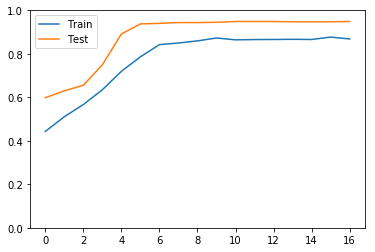

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.935287      0.935287
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.948718      0.948718
====  ======  ==========  ============


In [9]:
plt.plot(hist.history["acc"],label='Train')
plt.plot(hist.history["val_acc"],label="Test")
plt.legend()
plt.ylim(0,1)
plt.show()

from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [8]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [9]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels,ds_conf_M = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -17045.98306746402
2 	 -15025.642260843964 	0.3764	0.323838	0.118523
3 	 -14488.988500741425 	0.0448	0.279583	0.035716
4 	 -14285.71916148968 	0.0121	0.206297	0.014029
5 	 -14202.521274061704 	0.0044	550.898804	0.005824
6 	 -14169.790459423804 	0.0030	0.602096	0.002305
7 	 -14153.079709696582 	0.0018	0.051356	0.001179
8 	 -14144.465646223618 	0.0012	3.389503	0.000609
9 	 -14140.945565289585 	0.0008	0.015681	0.000249
Class marginals
[0.46 0.26 0.27]


In [10]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.6109076109076109
ACC D&S on train: 0.743996743996744


In [11]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],16,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist =model_mvsoft.fit(Xstd_train,mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

Trained model over soft-MV, Epochs to converge = 6


In [12]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],16,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

Trained model over hard-MV, Epochs to converge = 11


In [13]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],16,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

Trained model over D&S, Epochs to converge = 11


### Raykar Model (joint predict model)

In [9]:
from code.baseline import RaykarMC
#get raykar represenstation
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (2457, 100, 3)


In [42]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",16,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 3.31 sec)	logL: -16912.457	
Iter 2/50 
M step: done,  E step: done //  (in 0.17 sec)	logL: -15768.896	Tol1: 0.06762	Tol2: 0.31094	
Iter 3/50 
M step: done,  E step: done //  (in 0.12 sec)	logL: -15365.971	Tol1: 0.02555	Tol2: 0.10420	
Iter 4/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -15117.531	Tol1: 0.01617	Tol2: 0.07283	
Iter 5/50 
M step: done,  E step: done //  (in 0.13 sec)	logL: -14931.629	Tol1: 0.01230	Tol2: 0.04643	
Iter 6/50 
M step: done,  E step: done //  (in 0.12 sec)	logL: -14768.826	Tol1: 0.01090	Tol2: 0.02996	
Finished training


In [18]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
#raykarMC.define_model("keras_shallow") 
raykarMC.define_model("mlp",16,1,BatchN=False,drop=0.2)

logL_hists,i_r = raykarMC.multiples_run(30,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.70 sec)	logL: -18394.051	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -16843.637	Tol1: 0.08429	Tol2: 0.28649	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16466.242	Tol1: 0.02241	Tol2: 0.10385	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16291.468	Tol1: 0.01061	Tol2: 0.03975	
Iter 5/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16164.309	Tol1: 0.00781	Tol2: 0.01793	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.47 sec)	logL: -18630.104	
Iter 2/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -17238.738	Tol1: 0.07468	Tol2: 0.27371	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16829.703	Tol1: 0.02373	Tol2: 0.10440	
Iter 4/50 
M step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -16552.428	Tol1: 0.01619	Tol2: 0.04866	
Iter 5/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -16341.231	Tol1: 0.01276	Tol2: 0.01790	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.49 sec)	logL: -18408.697	
Iter 2/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -17004.992	Tol1: 0.07625	Tol2: 0.28043	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16586.523	Tol1: 0.02461	Tol2: 0.10321	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16351.117	Tol1: 0.01419	Tol2: 0.04669	
Iter 5/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16168.057	Tol1: 0.01120	Tol2: 0.02272	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.51 sec)	logL: -18947.812	
Iter 2/50 
M step: done,  E step: done //  (in 0.05

M step: done,  E step: done //  (in 0.04 sec)	logL: -16691.172	Tol1: 0.01438	Tol2: 0.04704	
Iter 5/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -16502.305	Tol1: 0.01132	Tol2: 0.02137	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.49 sec)	logL: -19144.320	
Iter 2/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -17696.029	Tol1: 0.07565	Tol2: 0.26832	
Iter 3/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -17230.453	Tol1: 0.02631	Tol2: 0.11001	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16975.309	Tol1: 0.01481	Tol2: 0.05051	
Iter 5/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -16773.582	Tol1: 0.01188	Tol2: 0.02202	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.49 sec)	logL: -19566.908	
Iter 2/50 
M step: done,  E step: done //  (in 0.04

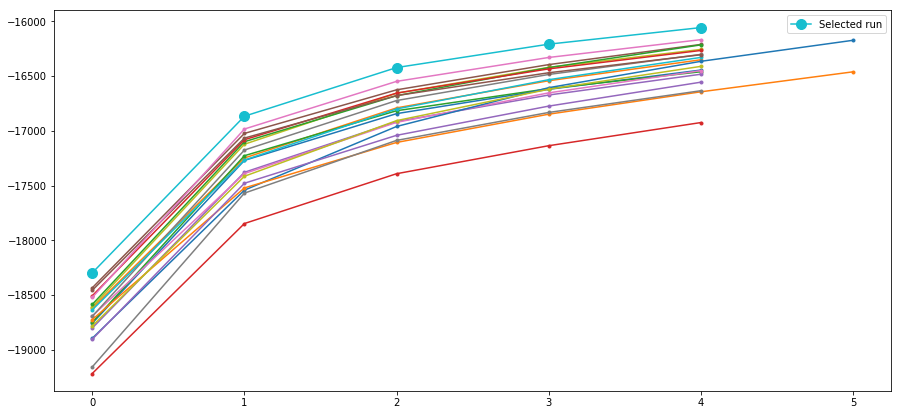

In [15]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [21]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
#r_obs = set_representation(y_obs_categorical,"repeat")
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[ 4  0  4]
 [ 0  1  6]
 [ 3  0  8]
 ...
 [ 2  0  7]
 [10  0  4]
 [ 5  0  1]]
shape: (2457, 3)


In [11]:
M_seted = 3

In [12]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",16,1,BatchN=False,drop=0.2)
gMixture_Global.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.003930 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8957351  0.14355521 0.7143383 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.89 sec)	logL: -25131.409	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24151.536	Tol1: 0.03899	Tol2: 0.45828	Tol3: 0.04370	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23588.789	Tol1: 0.02330	Tol2: 0.21774	Tol3: 0.02376	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23111.447	Tol1: 0.02024	Tol2: 0.14786	Tol3: 0.01580	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22693.645	Tol1: 0.01808	Tol2: 0.12737	Tol3: 0.01338	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22329.386	Tol1: 0.01605	Tol2: 0.11649	Tol3: 0.01303	
Iter 7/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.08 sec)	logL: -21037.253	Tol1: 0.00441	Tol2: 0.03103	Tol3: 0.01211	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20960.170	Tol1: 0.00366	Tol2: 0.02921	Tol3: 0.01171	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9230742  0.99951285 0.37515405]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -26152.832	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24664.527	Tol1: 0.05691	Tol2: 0.45920	Tol3: 0.14280	
Iter 3/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24171.750	Tol1: 0.01998	Tol2: 0.20062	Tol3: 0.02942	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23807.870	Tol1: 0.01505	Tol2: 0.13206	Tol3: 0.01369	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23451.592	Tol1: 0.01496	Tol2: 0.11251	Tol3: 0.01030	
Iter 6/50
M step: done, 

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5465917  0.6834863  0.55995405]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.01 sec)	logL: -26064.977	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25044.545	Tol1: 0.03915	Tol2: 0.38368	Tol3: 0.08498	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24555.004	Tol1: 0.01955	Tol2: 0.17620	Tol3: 0.01278	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24132.139	Tol1: 0.01722	Tol2: 0.10699	Tol3: 0.00491	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23707.020	Tol1: 0.01762	Tol2: 0.09173	Tol3: 0.00356	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23290.996	Tol1: 0.01755	Tol2: 0.09587	Tol3: 0.00359	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22886.885	Tol1: 0.01735	Tol2: 0.10125	Tol3: 0.00194	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	l

M step: done,  E step: done //  (in 0.09 sec)	logL: -22630.095	Tol1: 0.01855	Tol2: 0.09920	Tol3: 0.00697	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22231.217	Tol1: 0.01763	Tol2: 0.10385	Tol3: 0.00734	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21875.935	Tol1: 0.01598	Tol2: 0.10465	Tol3: 0.00764	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21571.353	Tol1: 0.01392	Tol2: 0.10197	Tol3: 0.00783	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21310.072	Tol1: 0.01211	Tol2: 0.09470	Tol3: 0.00685	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21099.982	Tol1: 0.00986	Tol2: 0.08337	Tol3: 0.00546	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20919.141	Tol1: 0.00857	Tol2: 0.07381	Tol3: 0.00645	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20770.082	Tol1: 0.00713	Tol2: 0.06698	Tol3: 0.00630	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20645.088	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -20253.910	Tol1: 0.00414	Tol2: 0.06735	Tol3: 0.01227	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20180.062	Tol1: 0.00365	Tol2: 0.06171	Tol3: 0.01037	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20125.519	Tol1: 0.00270	Tol2: 0.05517	Tol3: 0.00956	
Iter 16/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20078.225	Tol1: 0.00235	Tol2: 0.05014	Tol3: 0.00783	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20043.950	Tol1: 0.00171	Tol2: 0.04823	Tol3: 0.00706	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20017.686	Tol1: 0.00131	Tol2: 0.04982	Tol3: 0.00548	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19993.661	Tol1: 0.00120	Tol2: 0.04822	Tol3: 0.00382	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19974.998	Tol1: 0.00093	Tol2: 0.04717	Tol3: 0.00293	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19960.699	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -19907.468	Tol1: 0.00094	Tol2: 0.04666	Tol3: 0.00205	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19887.885	Tol1: 0.00098	Tol2: 0.04490	Tol3: 0.00187	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19866.891	Tol1: 0.00106	Tol2: 0.04146	Tol3: 0.00293	
Iter 23/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19855.142	Tol1: 0.00059	Tol2: 0.03978	Tol3: 0.00230	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19838.977	Tol1: 0.00081	Tol2: 0.03824	Tol3: 0.00259	
Iter 25/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19821.660	Tol1: 0.00087	Tol2: 0.03783	Tol3: 0.00262	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19812.235	Tol1: 0.00048	Tol2: 0.03607	Tol3: 0.00272	
Iter 27/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19800.406	Tol1: 0.00060	Tol2: 0.03396	Tol3: 0.00271	
Iter 28/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19789.969	T

In [41]:
%%time
#pre analysis

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Bayesian gaussian mixture say is 18 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters
Annotators PCA of annotations shape:  (2000, 4)
Normalized entropy (0-1) of repeats annotations: 0.647916212093615
CPU times: user 1min, sys: 5.31 s, total: 1min 5s
Wall time: 5.23 s


In [ ]:
#different M_seted??
M_seted = 3

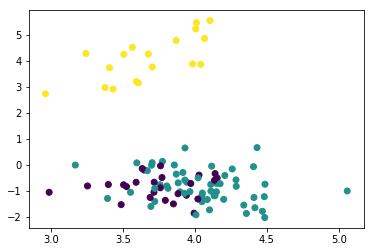

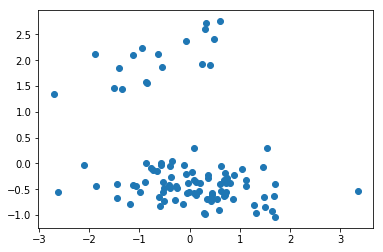

In [119]:
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c=groups_annot.argmax(axis=1))
plt.show()

std = StandardScaler()
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

In [42]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i_r = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003375 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.97 sec)	logL: -48511.162	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -48054.513	Tol1: 0.00941	Tol2: 0.06404	Tol3: 0.01810	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47719.367	Tol1: 0.00697	Tol2: 0.04276	Tol3: 0.00032	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47344.273	Tol1: 0.00786	Tol2: 0.05259	Tol3: 0.00106	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46911.728	Tol1: 0.00914	Tol2: 0.06177	Tol3: 0.00122	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -46431.422	Tol1: 0.01024	Tol2: 0.07072	Tol3: 0.00161	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -45893.800	Tol1: 0.011

M step: done,  E step: done //  (in 0.13 sec)	logL: -40500.523	Tol1: 0.00336	Tol2: 0.03107	Tol3: 0.00041	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40375.309	Tol1: 0.00309	Tol2: 0.03119	Tol3: 0.00003	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -40266.392	Tol1: 0.00270	Tol2: 0.03275	Tol3: 0.00064	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40161.242	Tol1: 0.00261	Tol2: 0.03302	Tol3: 0.00076	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40067.662	Tol1: 0.00233	Tol2: 0.03353	Tol3: 0.00131	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -39975.181	Tol1: 0.00231	Tol2: 0.03280	Tol3: 0.00107	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -39889.418	Tol1: 0.00215	Tol2: 0.03240	Tol3: 0.00166	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39812.441	Tol1: 0.00193	Tol2: 0.03166	Tol3: 0.00144	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39740.333	T

M step: done,  E step: done //  (in 8.47 sec)	logL: -49135.408	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -48382.749	Tol1: 0.01532	Tol2: 0.13605	Tol3: 0.03467	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47998.183	Tol1: 0.00795	Tol2: 0.06941	Tol3: 0.00420	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47577.439	Tol1: 0.00877	Tol2: 0.06598	Tol3: 0.00077	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47106.562	Tol1: 0.00990	Tol2: 0.06873	Tol3: 0.00060	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46584.205	Tol1: 0.01109	Tol2: 0.07345	Tol3: 0.00056	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -46019.388	Tol1: 0.01212	Tol2: 0.07792	Tol3: 0.00051	
Iter 8/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -45407.361	Tol1: 0.01330	Tol2: 0.08330	Tol3: 0.00064	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44747.044	Tol1: 0.01454	Tol2: 0.09046	Tol3: 0.00070	
Iter 10/

M step: done,  E step: done //  (in 0.16 sec)	logL: -48244.150	Tol1: 0.00553	Tol2: 0.04804	Tol3: 0.00598	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47954.478	Tol1: 0.00600	Tol2: 0.04707	Tol3: 0.00112	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47611.460	Tol1: 0.00715	Tol2: 0.04711	Tol3: 0.00064	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47209.364	Tol1: 0.00845	Tol2: 0.04988	Tol3: 0.00063	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46739.023	Tol1: 0.00996	Tol2: 0.05583	Tol3: 0.00058	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46193.662	Tol1: 0.01167	Tol2: 0.06258	Tol3: 0.00053	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -45584.213	Tol1: 0.01319	Tol2: 0.07322	Tol3: 0.00056	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -44919.751	Tol1: 0.01458	Tol2: 0.08386	Tol3: 0.00064	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -44224.556	Tol1: 0

M step: done,  E step: done //  (in 0.16 sec)	logL: -42283.403	Tol1: 0.01175	Tol2: 0.11120	Tol3: 0.00060	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41824.165	Tol1: 0.01086	Tol2: 0.10770	Tol3: 0.00130	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41413.208	Tol1: 0.00983	Tol2: 0.10170	Tol3: 0.00200	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -41056.437	Tol1: 0.00861	Tol2: 0.09417	Tol3: 0.00259	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40767.489	Tol1: 0.00704	Tol2: 0.08402	Tol3: 0.00271	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40523.278	Tol1: 0.00599	Tol2: 0.07335	Tol3: 0.00323	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40321.524	Tol1: 0.00498	Tol2: 0.06457	Tol3: 0.00367	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40144.798	Tol1: 0.00438	Tol2: 0.06029	Tol3: 0.00368	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39996.980	To

In [43]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i_r = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.004671 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03 0.04 0.58]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.81 sec)	logL: -47893.726	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -46795.137	Tol1: 0.02294	Tol2: 0.15603	Tol3: 0.00846	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45904.463	Tol1: 0.01903	Tol2: 0.09954	Tol3: 0.00415	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45109.323	Tol1: 0.01732	Tol2: 0.07261	Tol3: 0.00299	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -44392.581	Tol1: 0.01589	Tol2: 0.05718	Tol3: 0.00357	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -43708.633	Tol1: 0.01541	Tol2: 0.05617	Tol3: 0.00500	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -43069.263	Tol1

M step: done,  E step: done //  (in 0.15 sec)	logL: -48770.686	Tol1: 0.00974	Tol2: 0.07563	Tol3: 0.00499	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48406.007	Tol1: 0.00748	Tol2: 0.05467	Tol3: 0.00362	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48069.493	Tol1: 0.00695	Tol2: 0.04935	Tol3: 0.00274	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47732.295	Tol1: 0.00701	Tol2: 0.05420	Tol3: 0.00252	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47333.491	Tol1: 0.00836	Tol2: 0.06116	Tol3: 0.00215	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46855.429	Tol1: 0.01010	Tol2: 0.06882	Tol3: 0.00216	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46295.906	Tol1: 0.01194	Tol2: 0.07610	Tol3: 0.00239	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -45646.641	Tol1: 0.01402	Tol2: 0.08199	Tol3: 0.00308	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44952.155	Tol

M step: done,  E step: done //  (in 0.18 sec)	logL: -40289.915	Tol1: 0.00271	Tol2: 0.05575	Tol3: 0.00840	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40192.618	Tol1: 0.00241	Tol2: 0.05083	Tol3: 0.00726	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40103.468	Tol1: 0.00222	Tol2: 0.04976	Tol3: 0.00659	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40029.086	Tol1: 0.00185	Tol2: 0.05052	Tol3: 0.00604	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39956.745	Tol1: 0.00181	Tol2: 0.04935	Tol3: 0.00534	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39905.880	Tol1: 0.00127	Tol2: 0.05053	Tol3: 0.00486	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39845.243	Tol1: 0.00152	Tol2: 0.05038	Tol3: 0.00447	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39808.231	Tol1: 0.00093	Tol2: 0.04456	Tol3: 0.00320	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39760.909	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -41961.675	Tol1: 0.00751	Tol2: 0.08604	Tol3: 0.00386	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41686.885	Tol1: 0.00655	Tol2: 0.07965	Tol3: 0.00240	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41460.262	Tol1: 0.00544	Tol2: 0.07395	Tol3: 0.00117	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41273.626	Tol1: 0.00450	Tol2: 0.06717	Tol3: 0.00071	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41125.304	Tol1: 0.00359	Tol2: 0.06025	Tol3: 0.00030	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41001.670	Tol1: 0.00301	Tol2: 0.05130	Tol3: 0.00033	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40896.557	Tol1: 0.00256	Tol2: 0.04271	Tol3: 0.00021	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40806.601	Tol1: 0.00220	Tol2: 0.03370	Tol3: 0.00024	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40726.650	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -42921.141	Tol1: 0.01195	Tol2: 0.08532	Tol3: 0.00436	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -42443.260	Tol1: 0.01113	Tol2: 0.08519	Tol3: 0.00419	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41984.028	Tol1: 0.01082	Tol2: 0.08290	Tol3: 0.00392	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41564.574	Tol1: 0.00999	Tol2: 0.07971	Tol3: 0.00355	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -41203.304	Tol1: 0.00869	Tol2: 0.07501	Tol3: 0.00312	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40899.236	Tol1: 0.00738	Tol2: 0.06956	Tol3: 0.00263	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40626.465	Tol1: 0.00667	Tol2: 0.06359	Tol3: 0.00220	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40401.971	Tol1: 0.00553	Tol2: 0.05685	Tol3: 0.00186	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40222.830	T

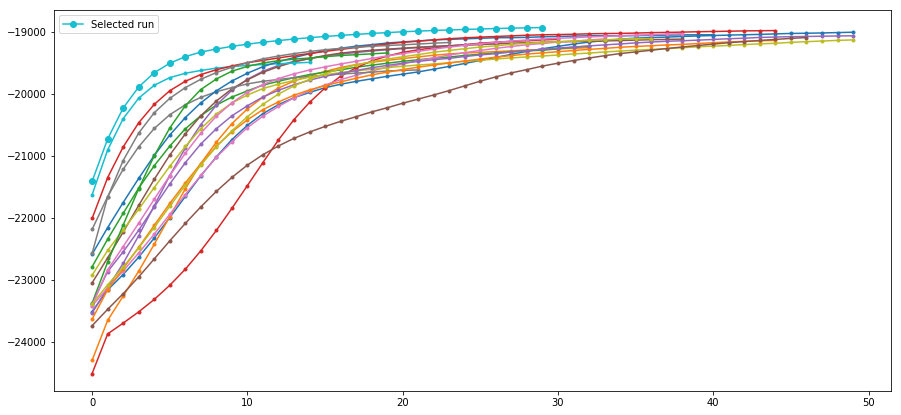

In [74]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',label="Selected run")
plt.legend()
plt.show()

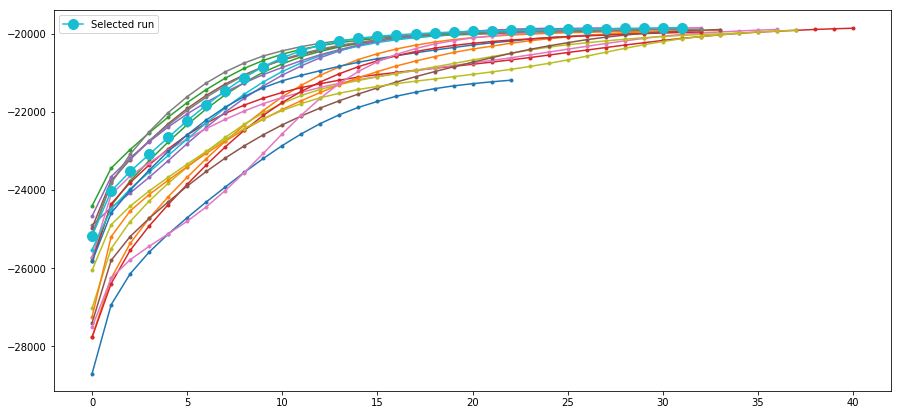

In [26]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [11]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [27]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.935287      0.935287
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.948718      0.948718
====  ======  ==========  ============


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [22]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7773707773707774


*** Soft-Majority (Train with softMV) ***
Train


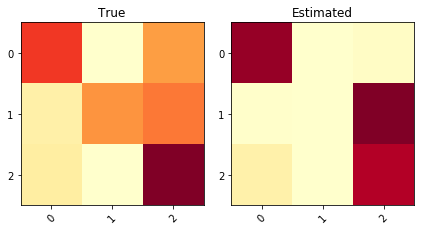

JS divergence: 0.1737	KL divergence: 2.3243


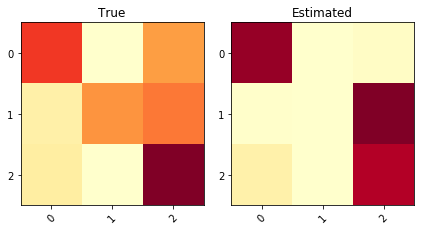

JS divergence: 0.1737	KL divergence: 2.3243


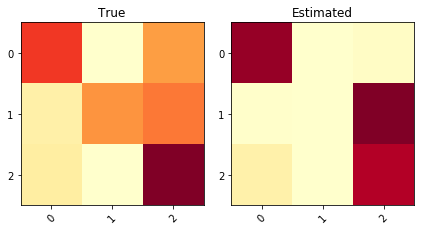

JS divergence: 0.1737	KL divergence: 2.3243


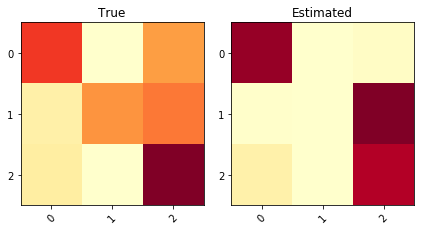

JS divergence: 0.1737	KL divergence: 2.3243


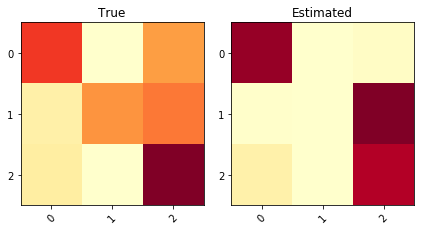

JS divergence: 0.1737	KL divergence: 2.3243


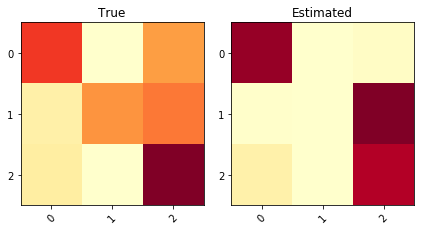

JS divergence: 0.1737	KL divergence: 2.3243


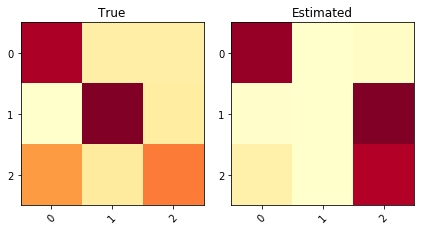

JS divergence: 0.3808	KL divergence: 6.0199


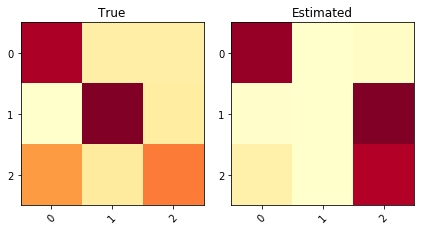

JS divergence: 0.3808	KL divergence: 6.0199


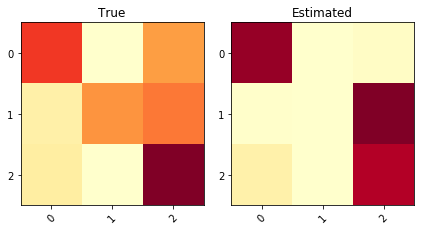

JS divergence: 0.1737	KL divergence: 2.3243


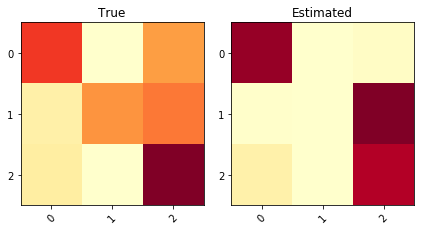

JS divergence: 0.1737	KL divergence: 2.3243


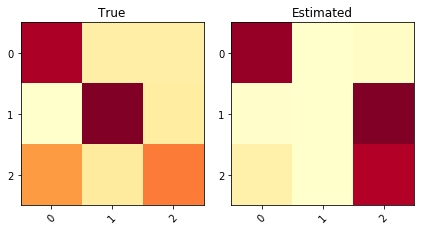

JS divergence: 0.3808	KL divergence: 6.0199


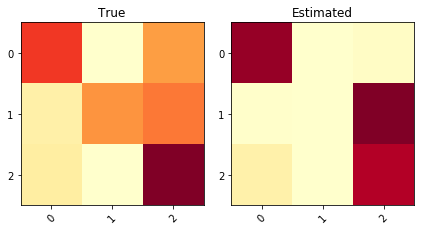

JS divergence: 0.1737	KL divergence: 2.3243


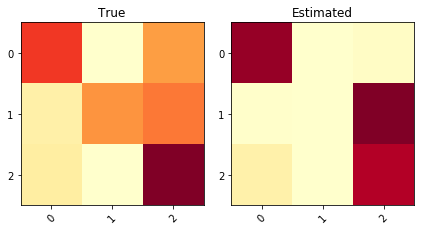

JS divergence: 0.1737	KL divergence: 2.3243


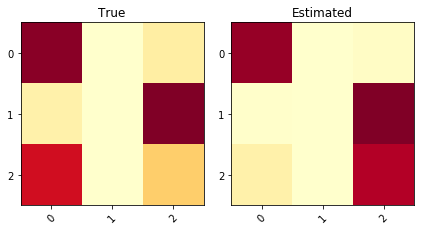

JS divergence: 0.1273	KL divergence: 0.2927


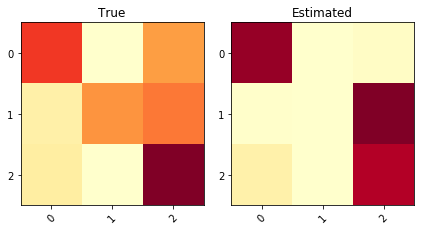

JS divergence: 0.1737	KL divergence: 2.3243
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.621083      0.621083     2.7883    0.21251
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.64591       0.64591
====  ======  ==========  ============


In [28]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


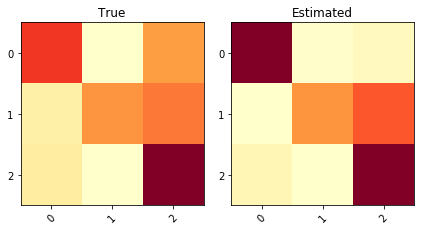

JS divergence: 0.1552	KL divergence: 0.3169


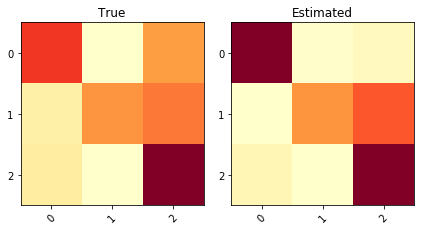

JS divergence: 0.1552	KL divergence: 0.3169


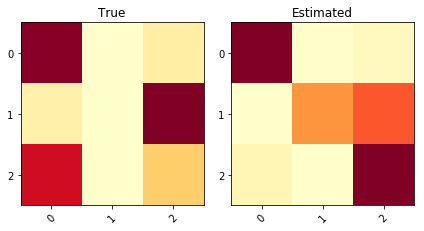

JS divergence: 0.2680	KL divergence: 0.5630


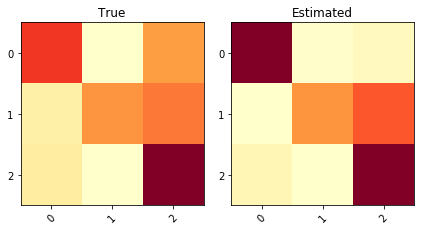

JS divergence: 0.1552	KL divergence: 0.3169


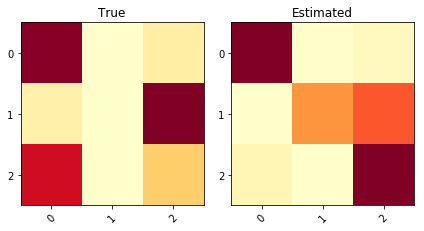

JS divergence: 0.2680	KL divergence: 0.5630


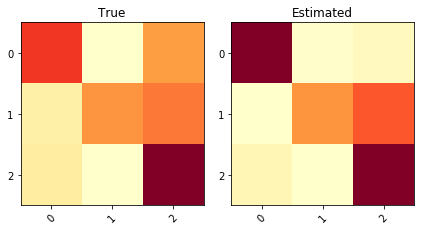

JS divergence: 0.1552	KL divergence: 0.3169


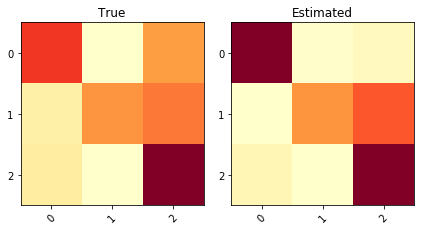

JS divergence: 0.1552	KL divergence: 0.3169


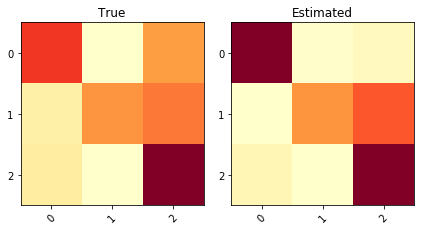

JS divergence: 0.1552	KL divergence: 0.3169


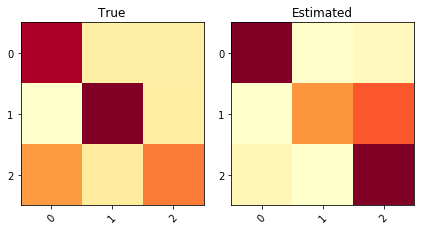

JS divergence: 0.2181	KL divergence: 0.9713


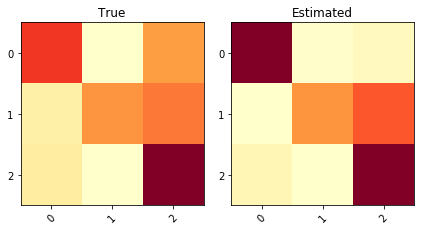

JS divergence: 0.1552	KL divergence: 0.3169


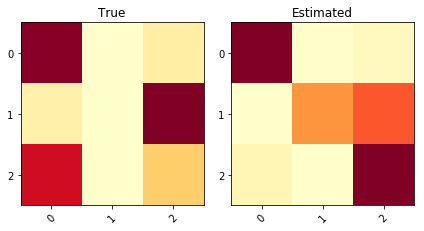

JS divergence: 0.2680	KL divergence: 0.5630


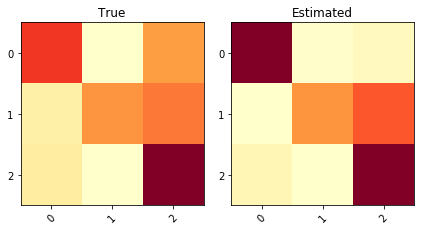

JS divergence: 0.1552	KL divergence: 0.3169


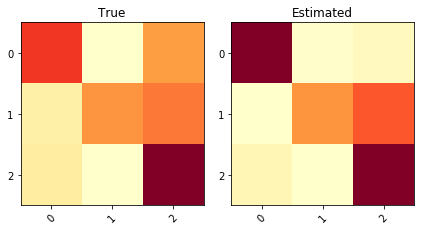

JS divergence: 0.1552	KL divergence: 0.3169


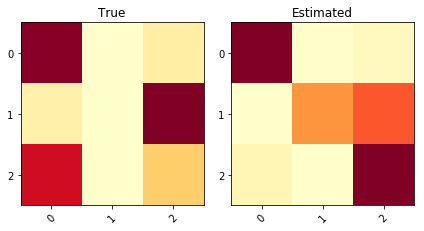

JS divergence: 0.2680	KL divergence: 0.5630


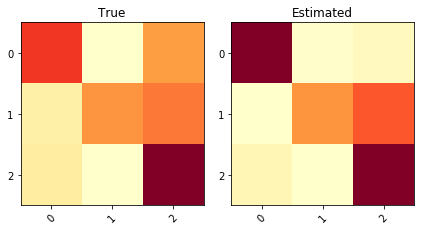

JS divergence: 0.1552	KL divergence: 0.3169
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.772894      0.772894   0.514156   0.191075
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.758242      0.758242
====  ======  ==========  ============


In [29]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


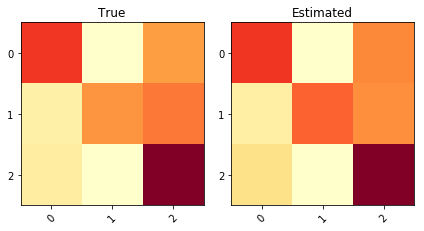

JS divergence: 0.0032	KL divergence: 0.0086


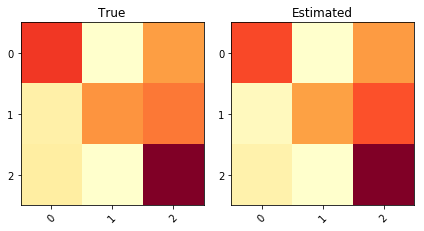

JS divergence: 0.0042	KL divergence: 0.0130


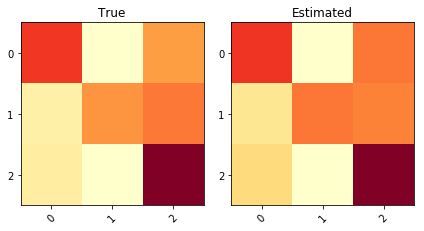

JS divergence: 0.0053	KL divergence: 0.0139


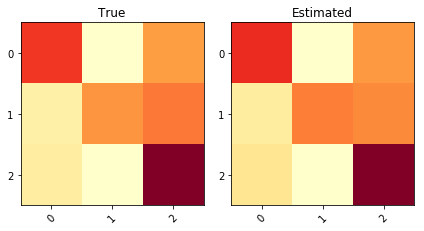

JS divergence: 0.0014	KL divergence: 0.0037


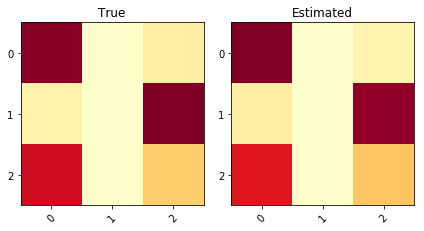

JS divergence: 0.0014	KL divergence: 0.0041


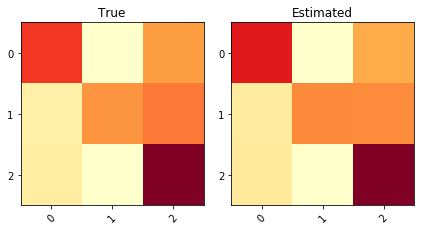

JS divergence: 0.0016	KL divergence: 0.0043


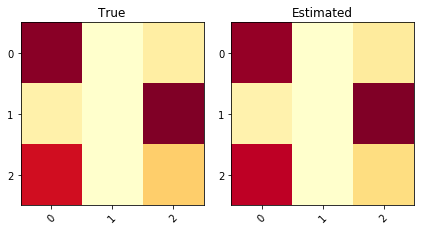

JS divergence: 0.0014	KL divergence: 0.0039


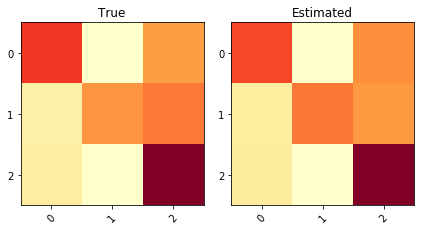

JS divergence: 0.0020	KL divergence: 0.0057


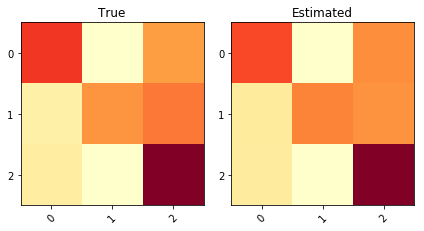

JS divergence: 0.0018	KL divergence: 0.0049


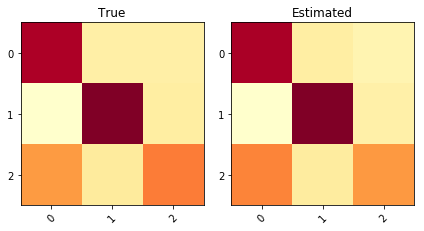

JS divergence: 0.0017	KL divergence: 0.0049


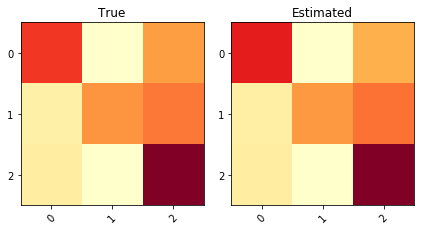

JS divergence: 0.0008	KL divergence: 0.0023


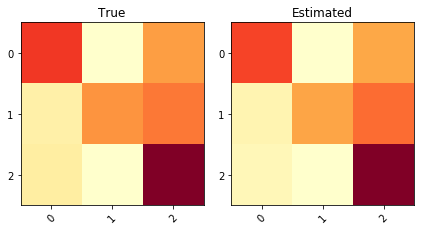

JS divergence: 0.0028	KL divergence: 0.0083


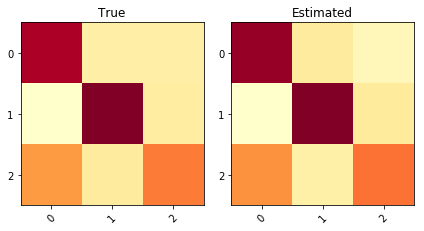

JS divergence: 0.0031	KL divergence: 0.0094


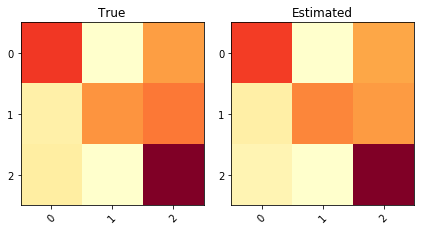

JS divergence: 0.0021	KL divergence: 0.0059


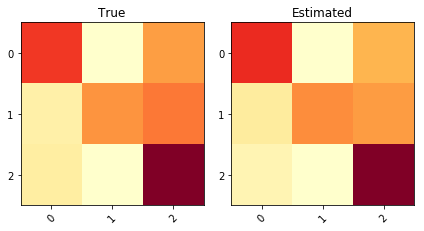

JS divergence: 0.0031	KL divergence: 0.0088
A result
 ====  ======  ==========  ============  =========  ==========
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS
====  ======  ==========  ============  =========  ==========
   0  Global    0.930403      0.930403  0.0083941  0.00291665
====  ======  ==========  ============  =========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.946276      0.946276
====  ======  ==========  ============


In [30]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


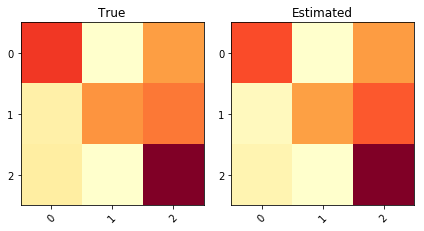

JS divergence: 0.0069	KL divergence: 0.0165


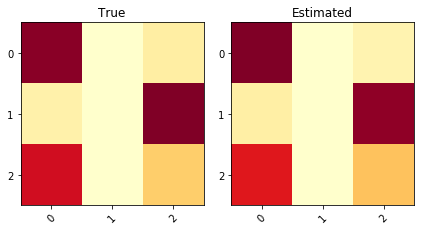

JS divergence: 0.0076	KL divergence: 0.0163


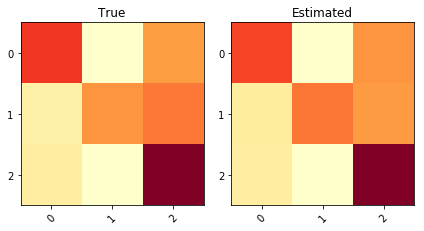

JS divergence: 0.0073	KL divergence: 0.0165


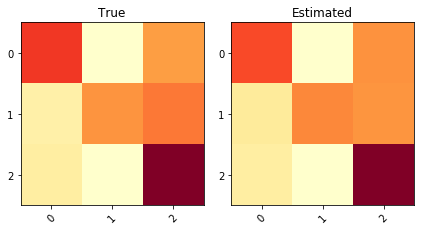

JS divergence: 0.0054	KL divergence: 0.0122


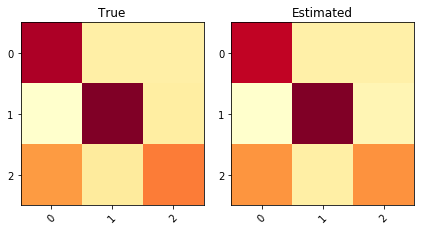

JS divergence: 0.0037	KL divergence: 0.0085


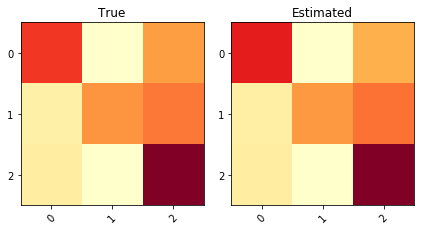

JS divergence: 0.0046	KL divergence: 0.0100


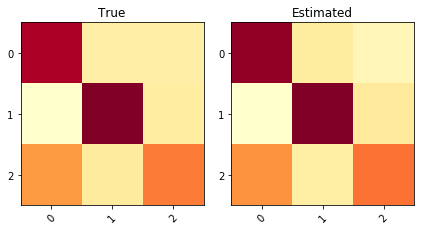

JS divergence: 0.0039	KL divergence: 0.0093


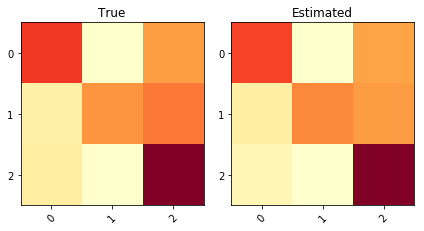

JS divergence: 0.0062	KL divergence: 0.0143


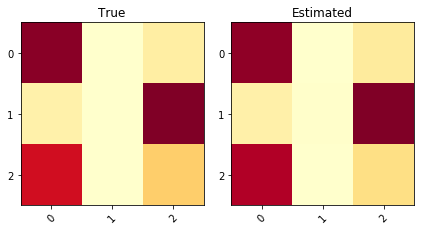

JS divergence: 0.0073	KL divergence: 0.0163


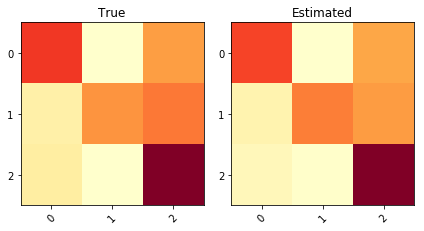

JS divergence: 0.0076	KL divergence: 0.0175


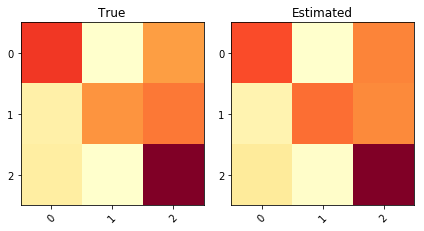

JS divergence: 0.0076	KL divergence: 0.0169


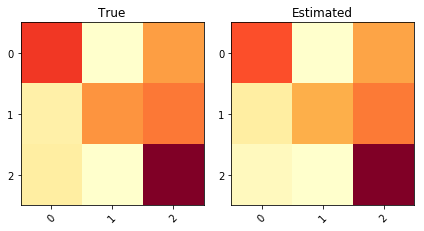

JS divergence: 0.0078	KL divergence: 0.0194


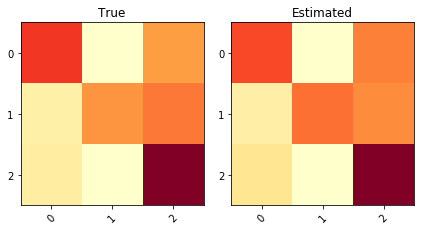

JS divergence: 0.0070	KL divergence: 0.0162


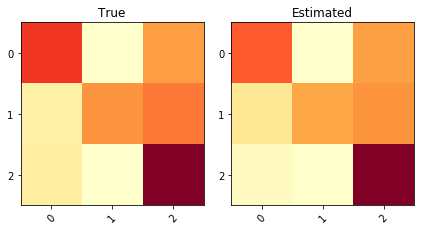

JS divergence: 0.0097	KL divergence: 0.0251


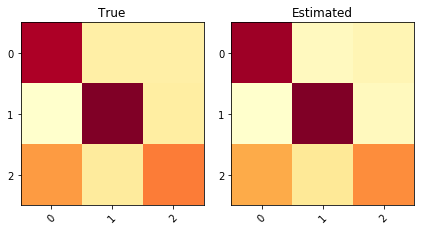

JS divergence: 0.0077	KL divergence: 0.0216
A result
 ====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
   0  Global    0.928368      0.928368  0.0152216  0.00659816   0.0151807  0.00658186     0.134587      0.134227
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.673373              0.738767          

In [19]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


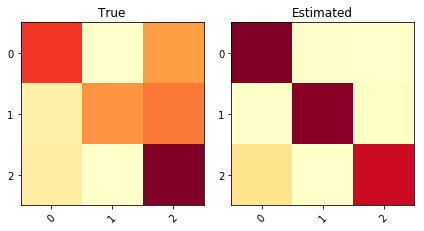

JS divergence: 0.1762	KL divergence: 0.9932


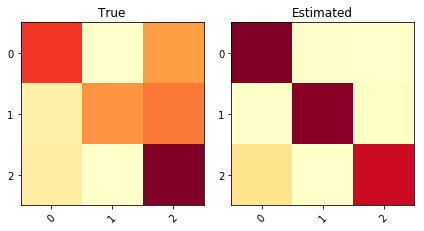

JS divergence: 0.1762	KL divergence: 0.9932


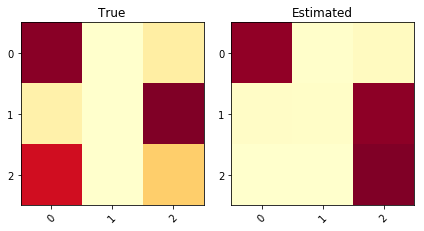

JS divergence: 0.1865	KL divergence: 1.1322


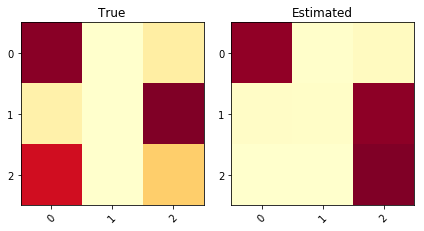

JS divergence: 0.1865	KL divergence: 1.1322


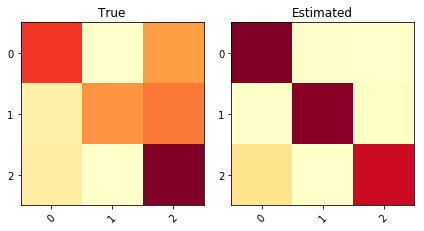

JS divergence: 0.1762	KL divergence: 0.9932


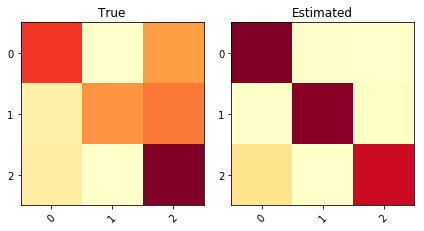

JS divergence: 0.1762	KL divergence: 0.9932


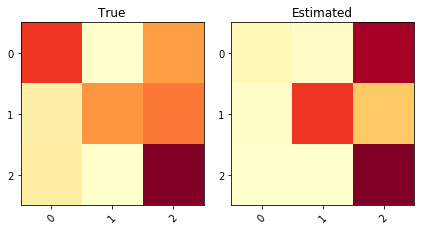

JS divergence: 0.1243	KL divergence: 0.4768


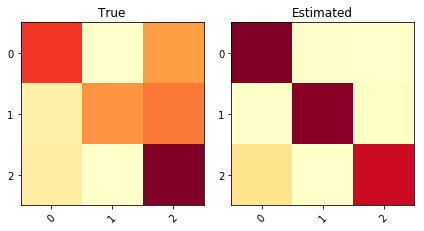

JS divergence: 0.1762	KL divergence: 0.9929


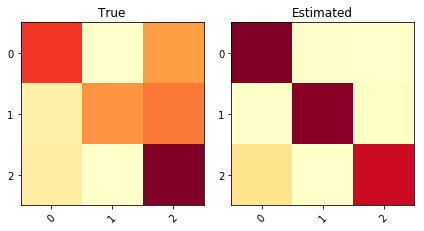

JS divergence: 0.1762	KL divergence: 0.9932


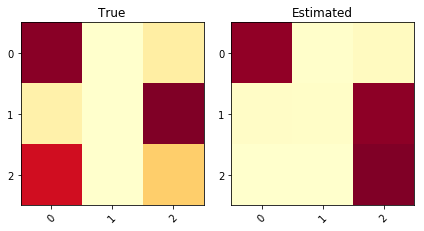

JS divergence: 0.1865	KL divergence: 1.1322


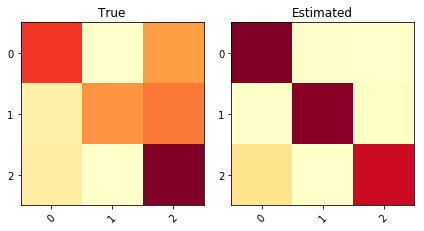

JS divergence: 0.1762	KL divergence: 0.9932


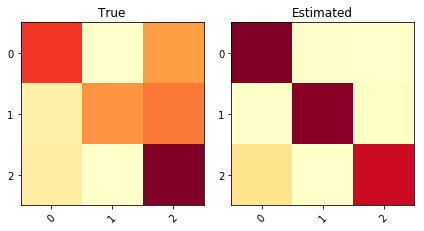

JS divergence: 0.1762	KL divergence: 0.9932


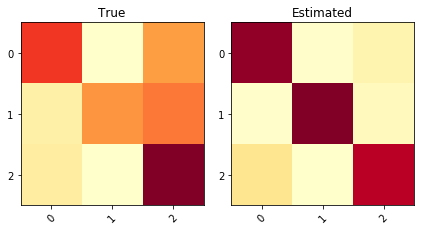

JS divergence: 0.1236	KL divergence: 0.4734


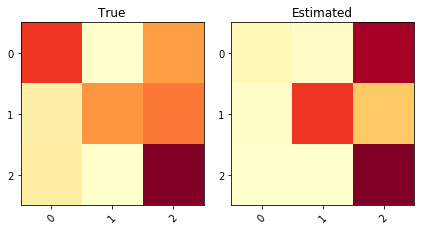

JS divergence: 0.1244	KL divergence: 0.4775


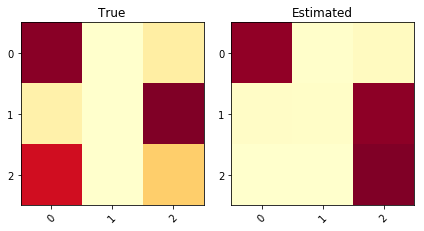

JS divergence: 0.1865	KL divergence: 1.1322
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.918193      0.918193   0.687677   0.133918    0.690313      0.1343     0.162385       0.16299
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.621899                0.858369
====  =======================  ======================
Test


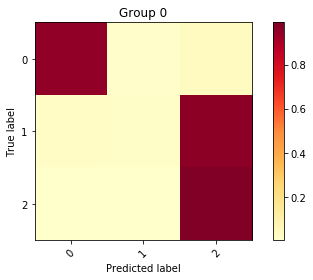

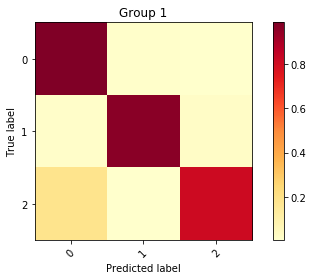

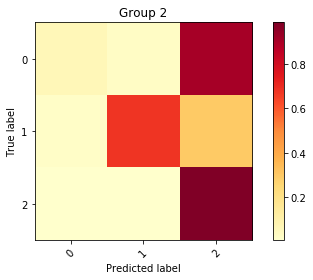

Inertia: 0.3423373032036343
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.352306      35   0.151112     0.65381   1.37247         0.535801   0.480715    0.647131      0.647131
   1         1  0.420217      42   0.243015     0.923692  0.0831219       0.941532   0.885538    0.848596      0.848596
   2         2  0.227477      22   0.373458     0.577493  1.05694         0.511502   0.36624     0.494505      0.494505
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [32]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


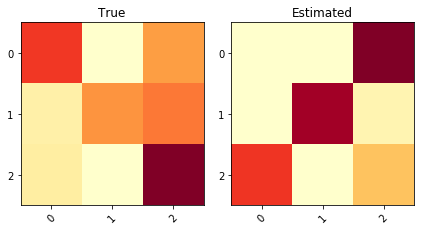

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


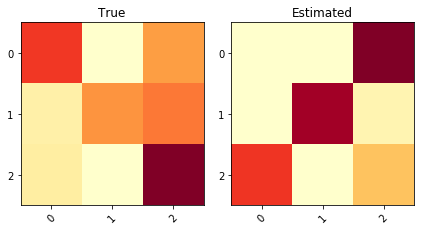

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


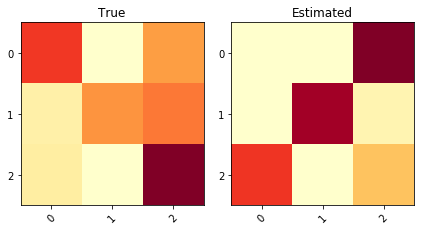

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


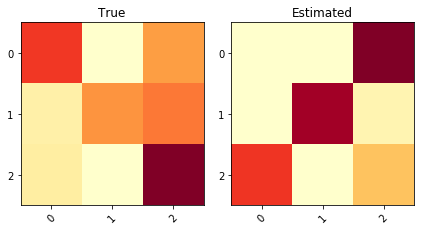

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


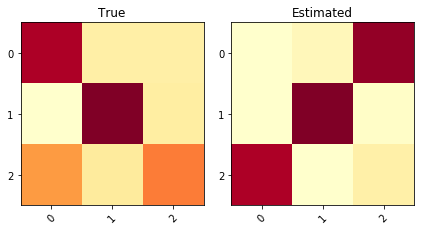

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


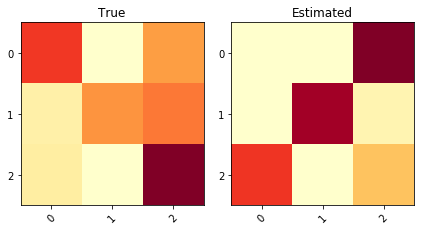

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


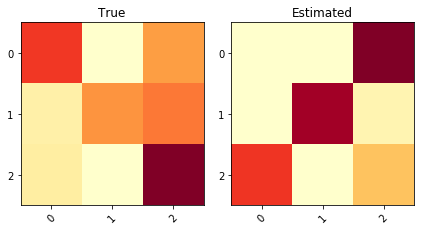

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


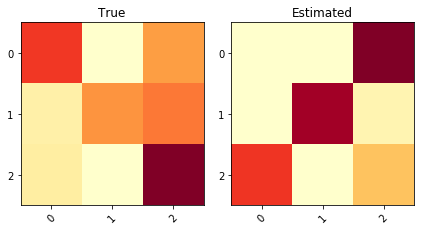

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


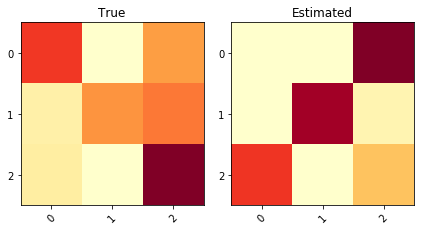

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


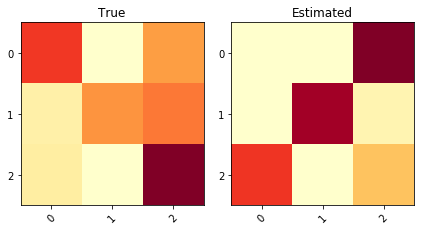

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


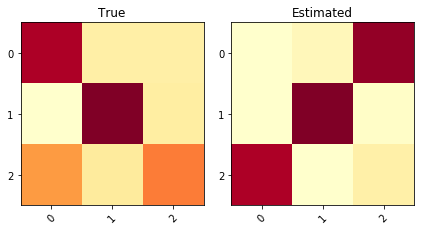

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


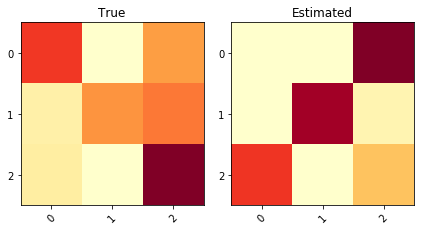

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


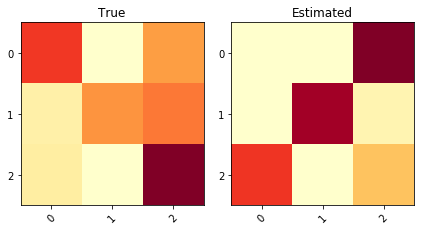

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


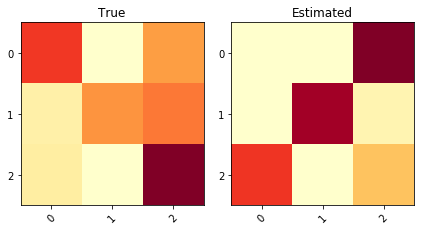

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


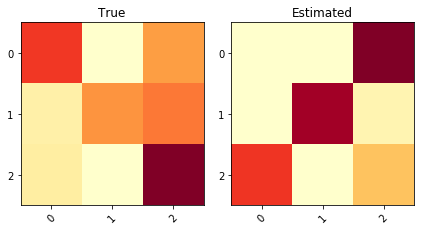

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.387464      0.387464    1.46138   0.203843           -0.344831       0.0975104
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.661312                0.727459
====  =======================  ======================
Test


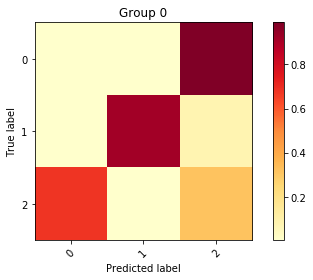

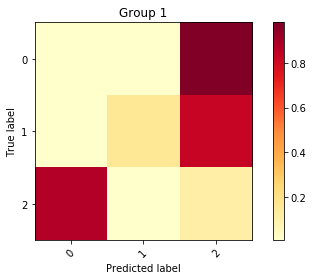

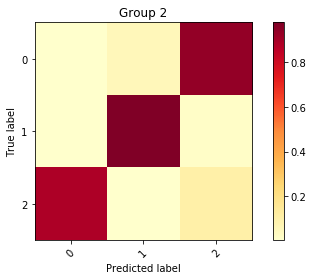

Inertia: 0.09433624582986037
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.548259      54   0.332222    0.413273     2.34267       0.499222   0.0799397    0.802198      0.802198
   1         1  0.16093       16   0.34057     0.0939899    2.8462        0.213318  -0.239343     0.630037      0.630037
   2         2  0.290811      29   0.252397    0.363872     2.39851       0.424208   0.0305391    0.882784      0.882784
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [34]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


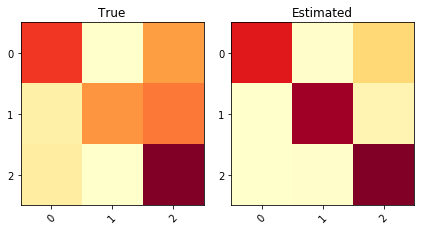

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


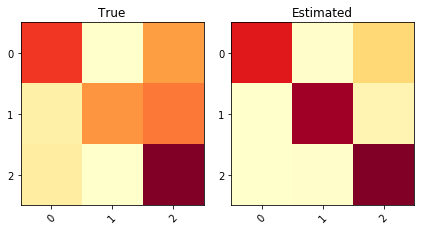

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


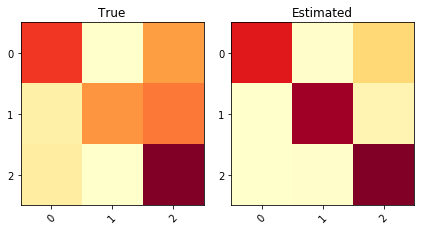

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


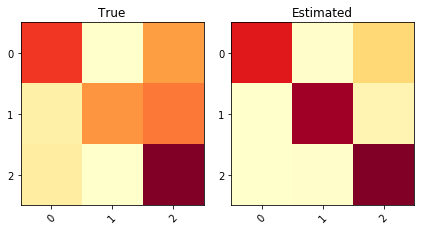

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


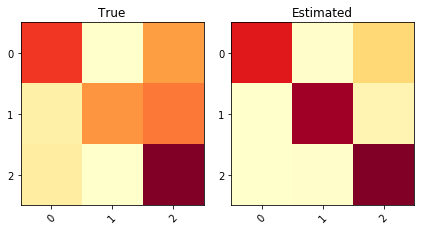

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


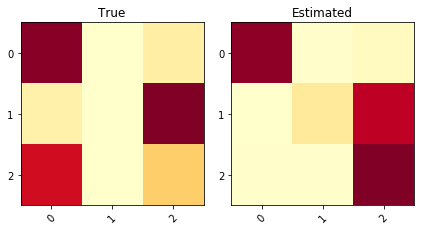

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


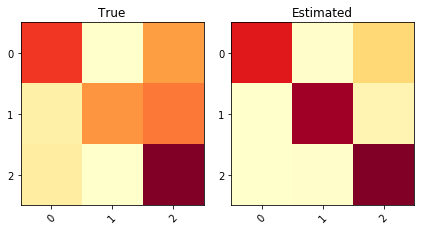

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


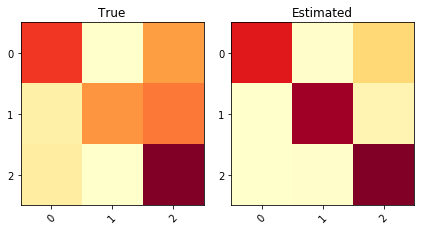

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


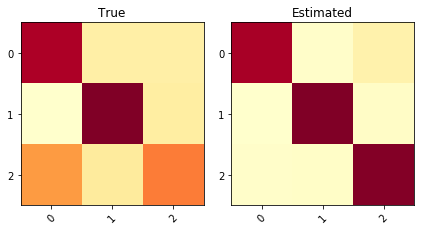

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


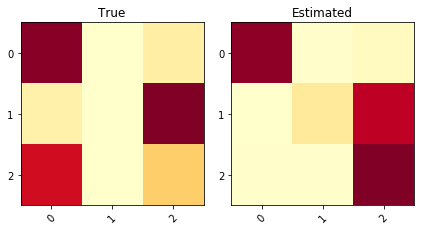

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


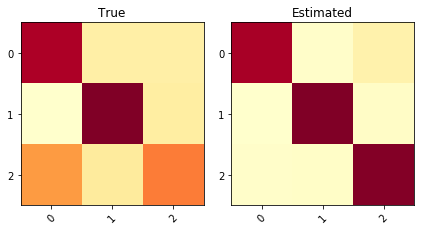

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


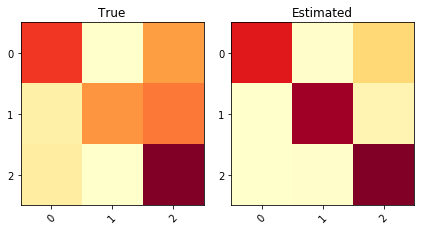

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


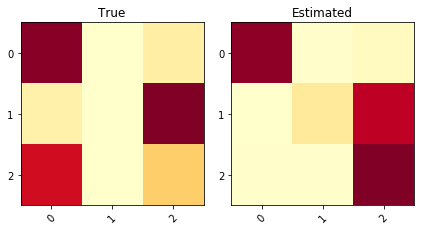

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


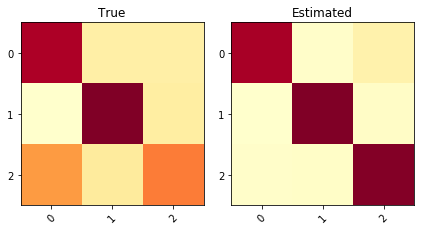

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


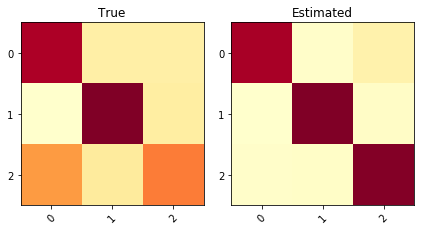

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.892552      0.892552   0.600229  0.0875265            0.289699       0.0963832
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.658511                 0.73373
====  =======================  ======================
Test


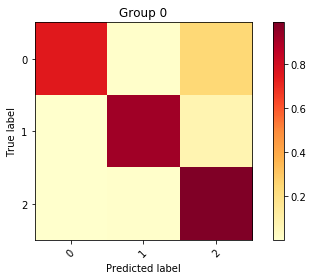

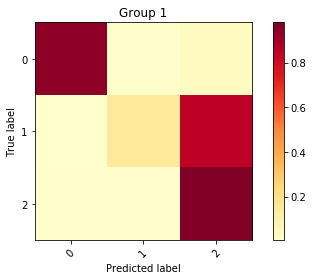

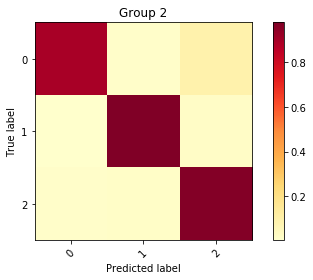

Inertia: 0.0972544342900316
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.544033      54   0.310449     0.8868    0.12712         0.938615   0.553466    0.84127       0.84127
   1         1  0.181161      18   0.261901     0.689919  0.675244        0.757545   0.356585    0.634921      0.634921
   2         2  0.274806      27   0.211517     0.948153  0.0540261       0.973305   0.614819    0.910867      0.910867
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [35]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [46]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6133496133496134


In [ ]:
T_weights = np.sum(y_obs != -1,axis=0)

*** Soft-Majority (Train with softMV) ***
Train


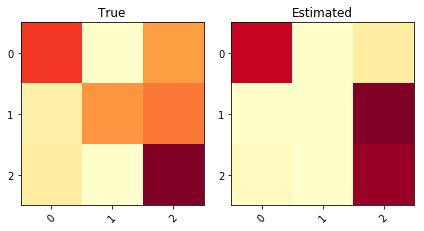

JS divergence: 0.1737	KL divergence: 2.3243


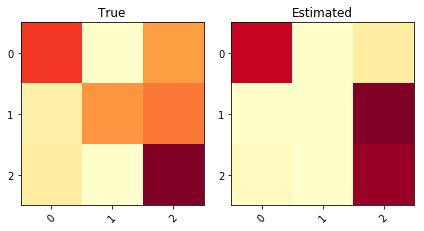

JS divergence: 0.1737	KL divergence: 2.3243


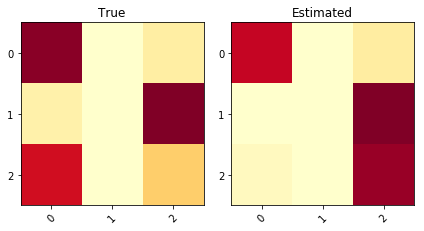

JS divergence: 0.1273	KL divergence: 0.2927


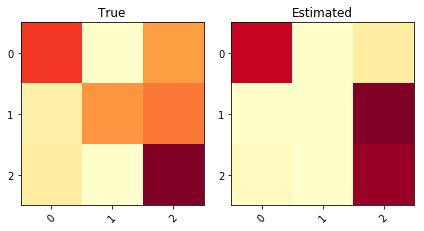

JS divergence: 0.1737	KL divergence: 2.3243


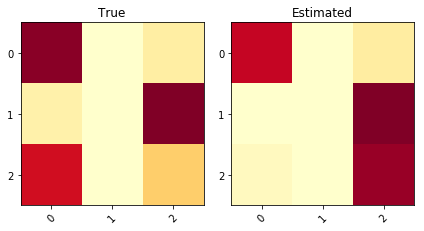

JS divergence: 0.1273	KL divergence: 0.2927


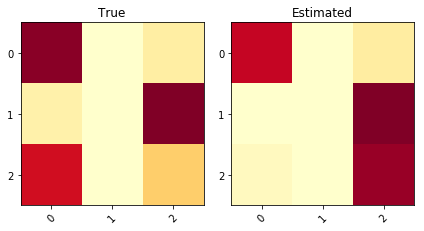

JS divergence: 0.1273	KL divergence: 0.2927


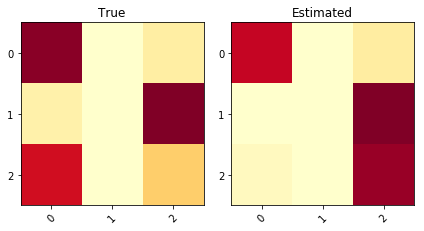

JS divergence: 0.1273	KL divergence: 0.2927


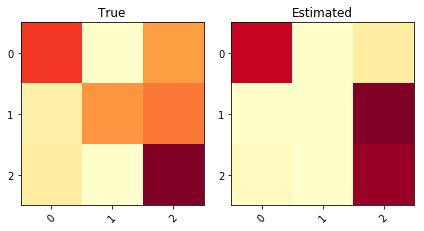

JS divergence: 0.1737	KL divergence: 2.3243


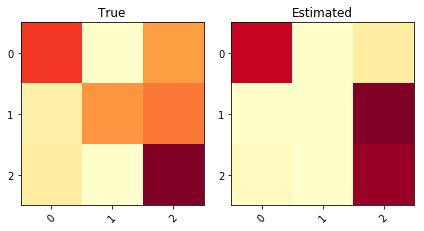

JS divergence: 0.1737	KL divergence: 2.3243


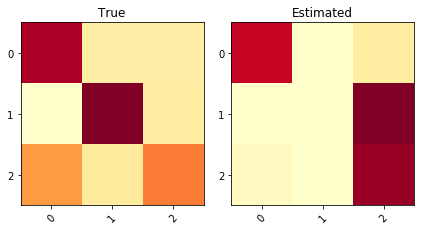

JS divergence: 0.3808	KL divergence: 6.0199


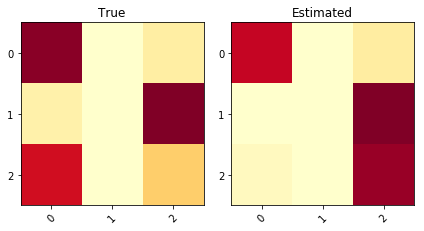

JS divergence: 0.1273	KL divergence: 0.2927


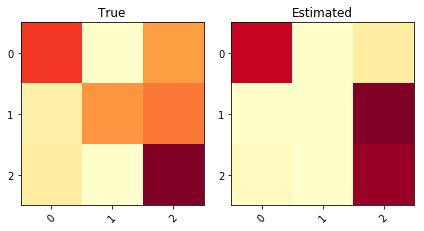

JS divergence: 0.1737	KL divergence: 2.3243


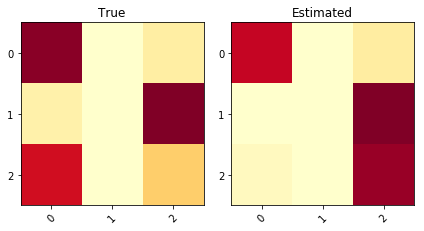

JS divergence: 0.1273	KL divergence: 0.2927


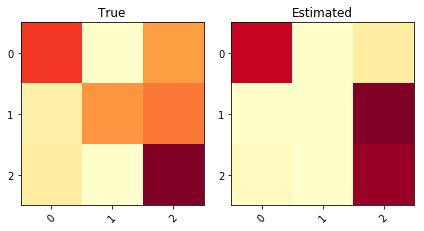

JS divergence: 0.1737	KL divergence: 2.3243


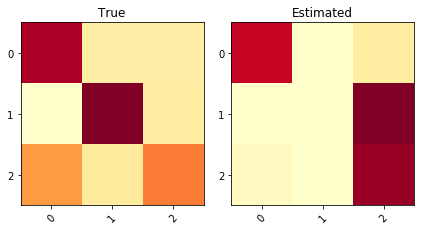

JS divergence: 0.3808	KL divergence: 6.0199
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.606838      0.606838    2.25078   0.196564
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.638584      0.638584
====  ======  ==========  ============


In [47]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical) #no more,,,
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


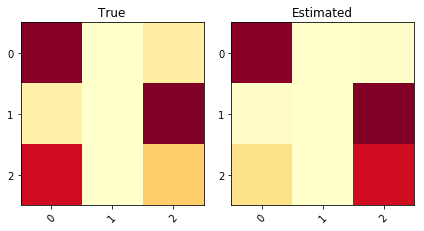

JS divergence: 0.1273	KL divergence: 0.2927


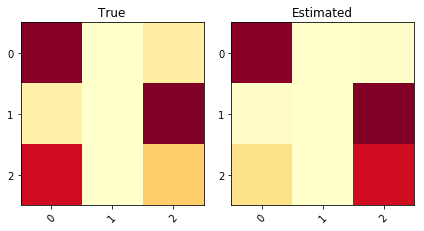

JS divergence: 0.1273	KL divergence: 0.2927


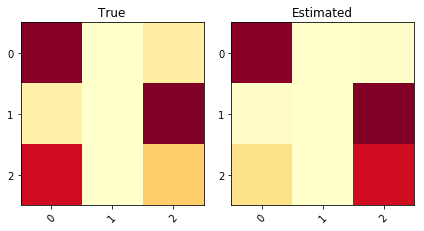

JS divergence: 0.1273	KL divergence: 0.2927


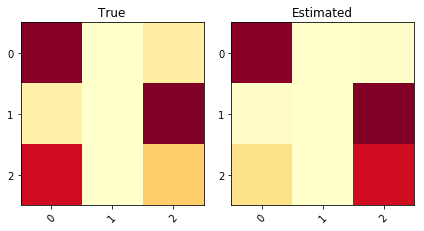

JS divergence: 0.1273	KL divergence: 0.2927


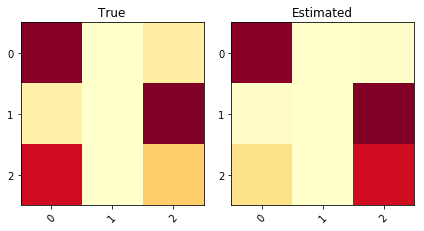

JS divergence: 0.1273	KL divergence: 0.2927


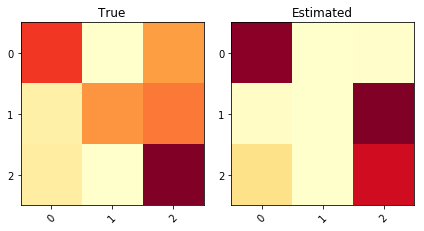

JS divergence: 0.1737	KL divergence: 2.3243


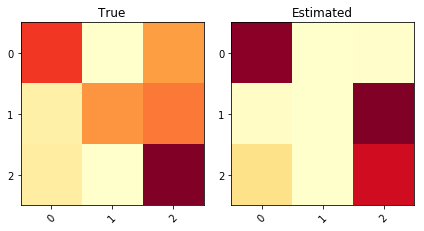

JS divergence: 0.1737	KL divergence: 2.3243


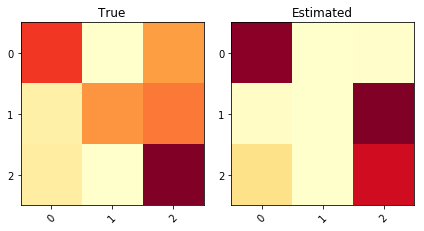

JS divergence: 0.1737	KL divergence: 2.3243


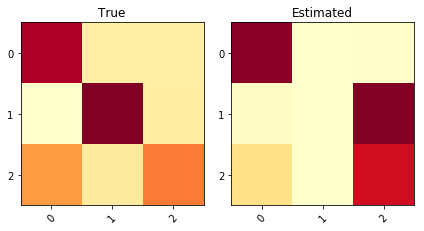

JS divergence: 0.3808	KL divergence: 6.0199


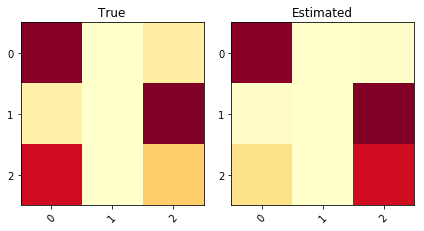

JS divergence: 0.1273	KL divergence: 0.2927


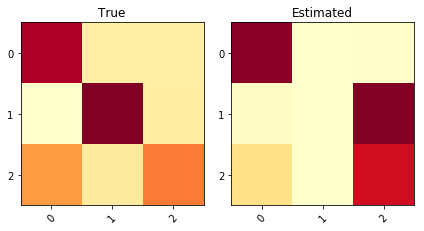

JS divergence: 0.3808	KL divergence: 6.0199


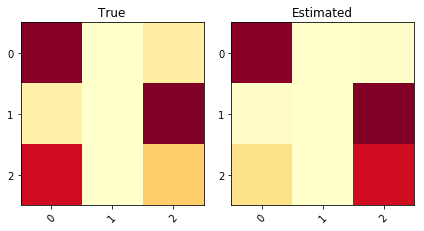

JS divergence: 0.1273	KL divergence: 0.2927


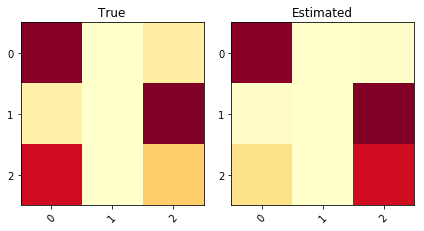

JS divergence: 0.1273	KL divergence: 0.2927


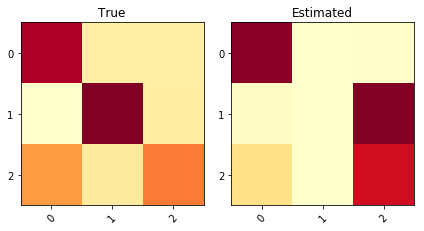

JS divergence: 0.3808	KL divergence: 6.0199


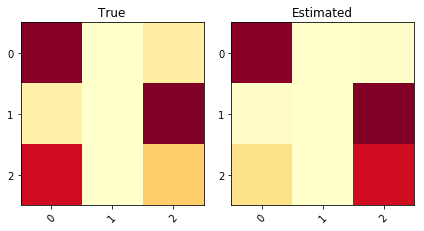

JS divergence: 0.1273	KL divergence: 0.2927
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.595035      0.595035    2.25078   0.196564
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.619048      0.619048
====  ======  ==========  ============


In [48]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


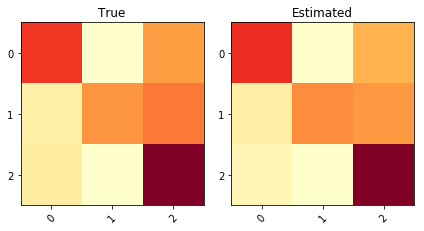

JS divergence: 0.0027	KL divergence: 0.0077


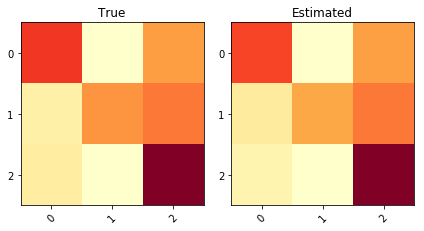

JS divergence: 0.0017	KL divergence: 0.0047


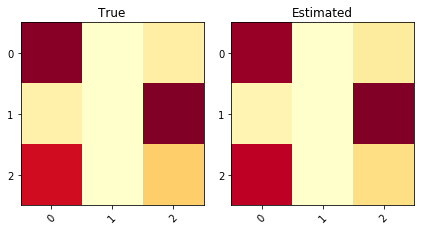

JS divergence: 0.0018	KL divergence: 0.0053


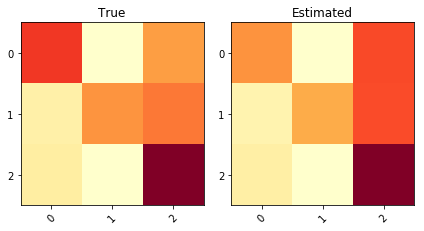

JS divergence: 0.0094	KL divergence: 0.0260


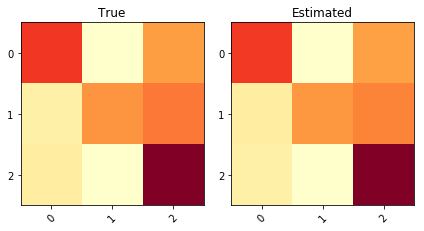

JS divergence: 0.0004	KL divergence: 0.0010


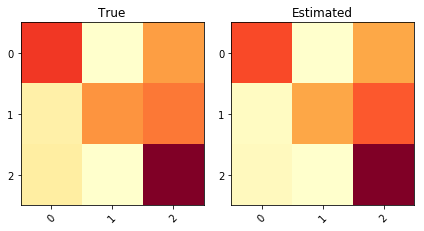

JS divergence: 0.0093	KL divergence: 0.0306


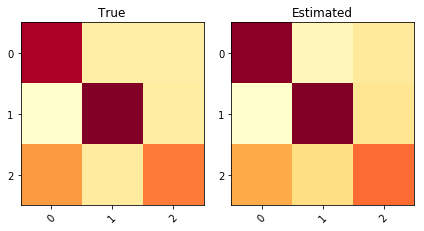

JS divergence: 0.0057	KL divergence: 0.0164


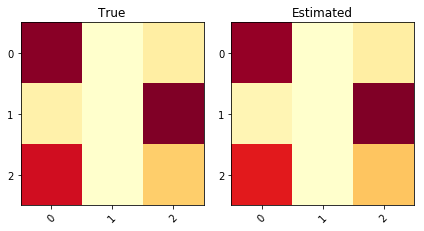

JS divergence: 0.0008	KL divergence: 0.0024


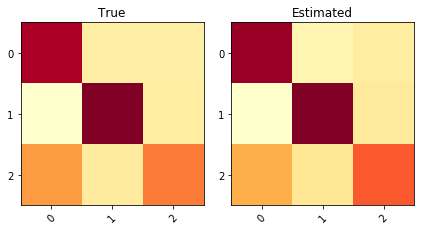

JS divergence: 0.0020	KL divergence: 0.0058


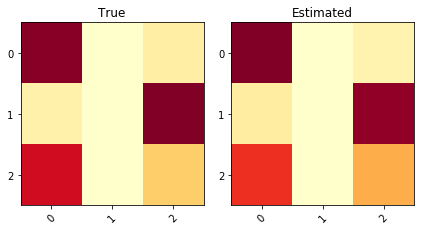

JS divergence: 0.0038	KL divergence: 0.0103


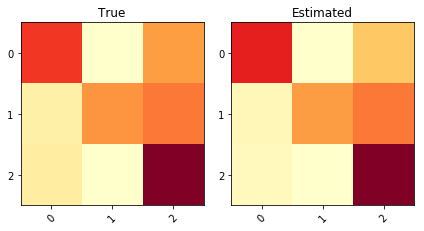

JS divergence: 0.0082	KL divergence: 0.0255


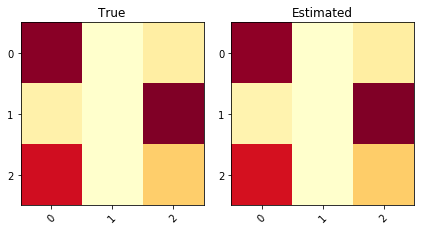

JS divergence: 0.0001	KL divergence: 0.0002


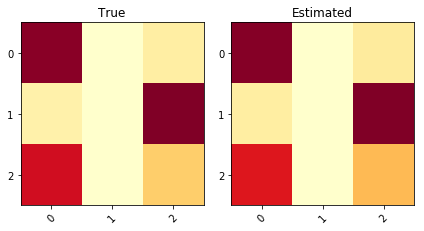

JS divergence: 0.0013	KL divergence: 0.0036


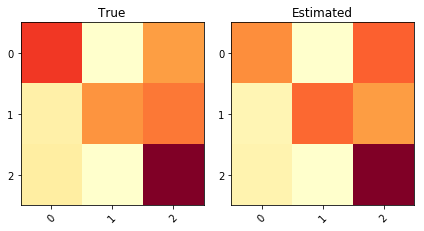

JS divergence: 0.0088	KL divergence: 0.0244


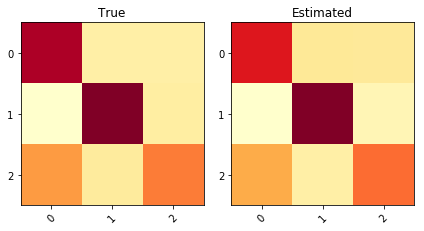

JS divergence: 0.0051	KL divergence: 0.0144
A result
 ====  ======  ==========  ============  =========  ==========
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS
====  ======  ==========  ============  =========  ==========
   0  Global     0.92267       0.92267  0.0106255  0.00363264
====  ======  ==========  ============  =========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.941392      0.941392
====  ======  ==========  ============


In [49]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


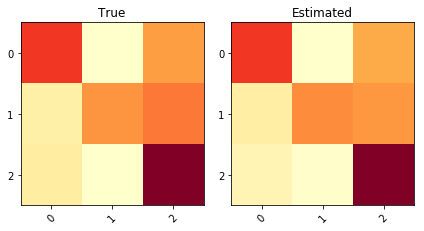

JS divergence: 0.0056	KL divergence: 0.0127


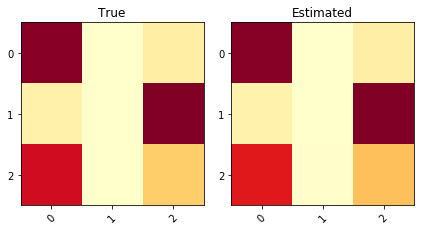

JS divergence: 0.0069	KL divergence: 0.0144


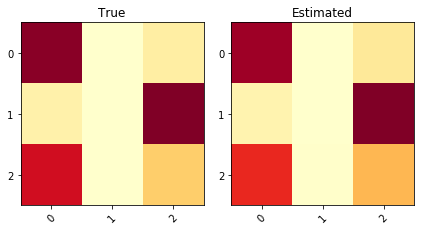

JS divergence: 0.0085	KL divergence: 0.0188


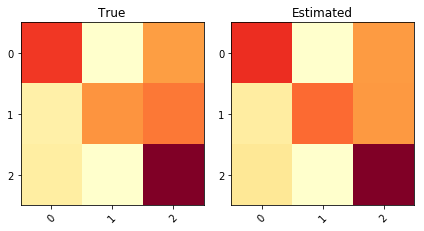

JS divergence: 0.0066	KL divergence: 0.0152


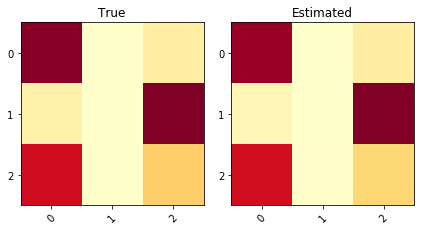

JS divergence: 0.0070	KL divergence: 0.0143


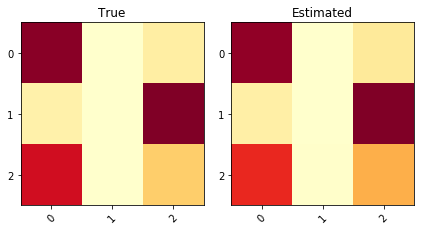

JS divergence: 0.0089	KL divergence: 0.0202


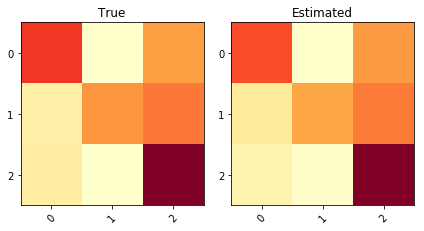

JS divergence: 0.0057	KL divergence: 0.0129


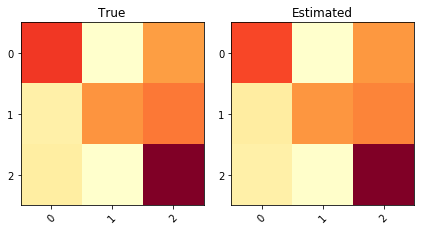

JS divergence: 0.0050	KL divergence: 0.0106


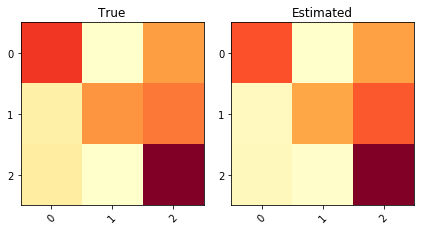

JS divergence: 0.0105	KL divergence: 0.0268


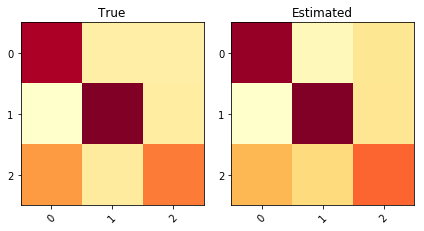

JS divergence: 0.0100	KL divergence: 0.0262


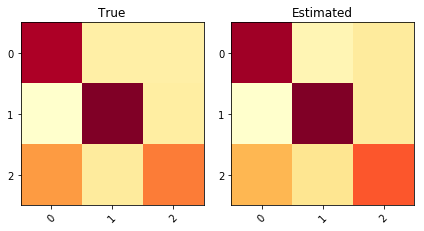

JS divergence: 0.0054	KL divergence: 0.0134


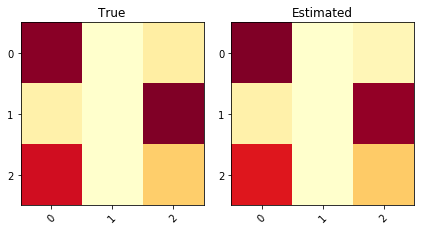

JS divergence: 0.0073	KL divergence: 0.0162


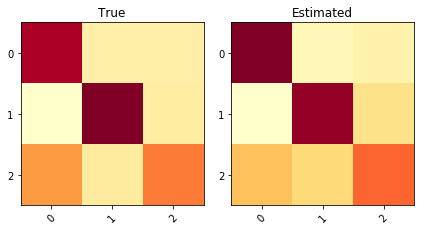

JS divergence: 0.0110	KL divergence: 0.0288


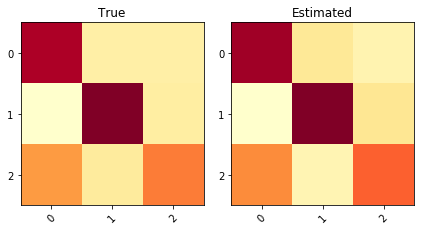

JS divergence: 0.0058	KL divergence: 0.0146


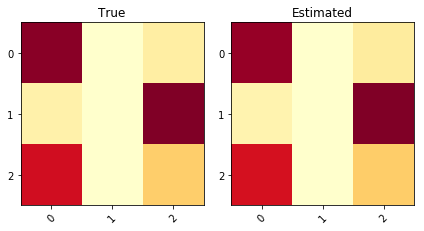

JS divergence: 0.0059	KL divergence: 0.0122
A result
 ====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
   0  Global    0.857143      0.857143  0.0185737  0.00792219   0.0184869  0.00788742     0.100131      0.100583
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.720928                0.664723
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ==

In [50]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


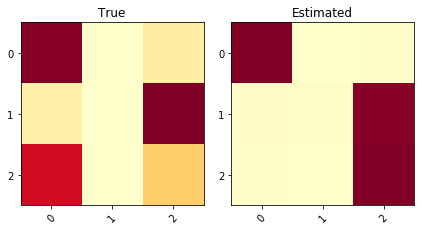

JS divergence: 0.1906	KL divergence: 1.0949


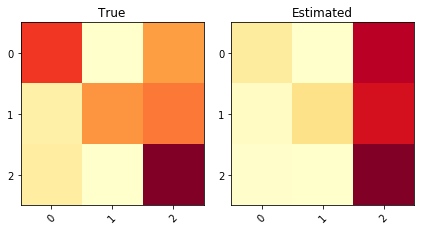

JS divergence: 0.0944	KL divergence: 0.3080


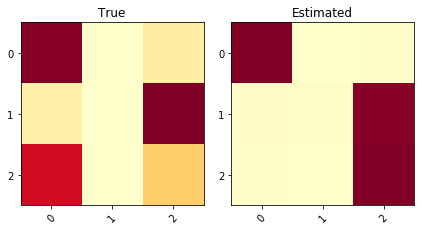

JS divergence: 0.1906	KL divergence: 1.0949


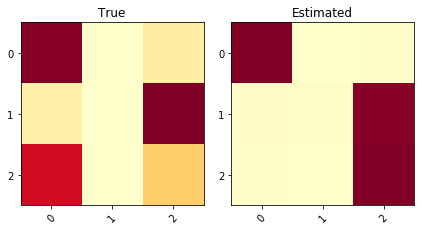

JS divergence: 0.1906	KL divergence: 1.0949


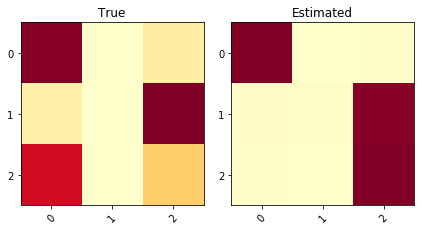

JS divergence: 0.1906	KL divergence: 1.0949


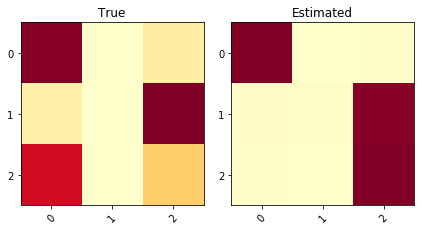

JS divergence: 0.1906	KL divergence: 1.0949


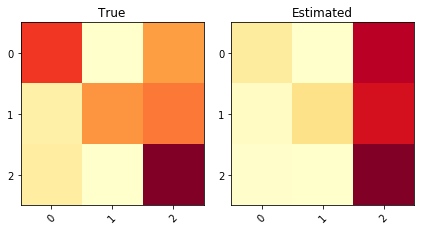

JS divergence: 0.0944	KL divergence: 0.3079


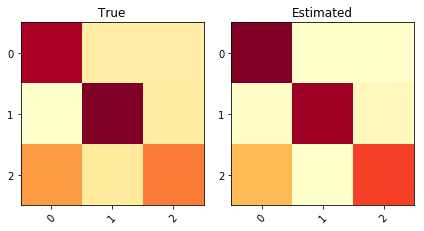

JS divergence: 0.0550	KL divergence: 0.2829


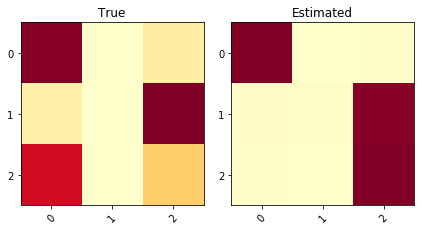

JS divergence: 0.1906	KL divergence: 1.0949


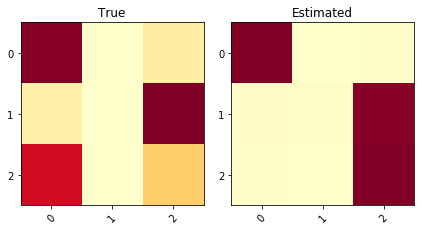

JS divergence: 0.1906	KL divergence: 1.0949


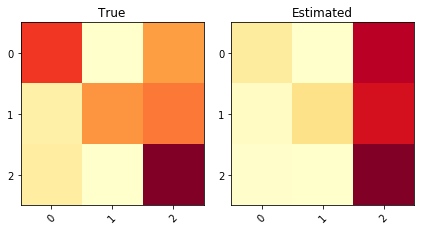

JS divergence: 0.0944	KL divergence: 0.3080


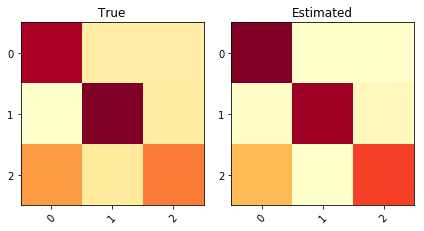

JS divergence: 0.0550	KL divergence: 0.2829


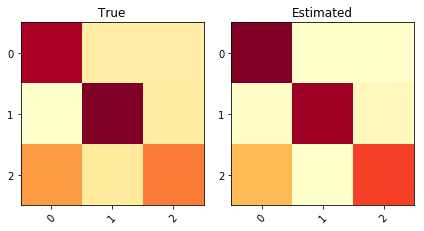

JS divergence: 0.0550	KL divergence: 0.2829


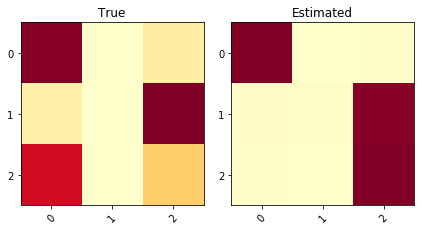

JS divergence: 0.1906	KL divergence: 1.0949


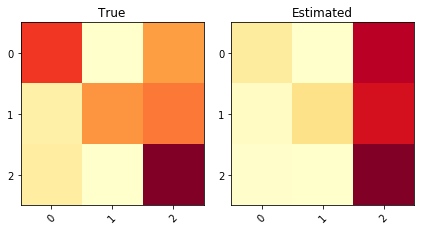

JS divergence: 0.0944	KL divergence: 0.3080
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.898657      0.898657   0.662962   0.131436     0.66243    0.131367     0.204277      0.204795
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.638595                0.757481
====  =======================  ======================
Test


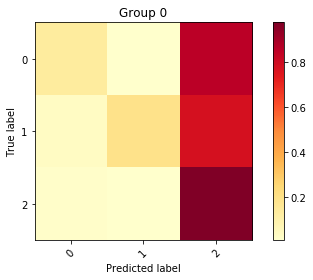

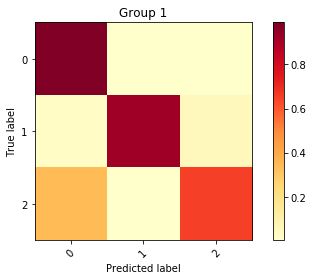

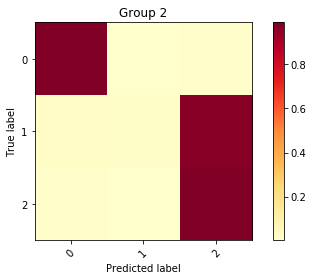

Inertia: 0.3327145621693054
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.142365      14   0.400844     0.433028   1.2309         0.356577   0.149542    0.333333      0.333333
   1         1  0.436689      43   0.34196      0.857342   0.169871       0.883939   0.786013    0.65812       0.65812
   2         2  0.420947      42   0.101514     0.664065   1.41194        0.54045    0.496098    0.631258      0.631258
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [51]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


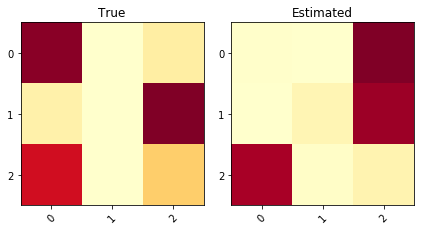

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


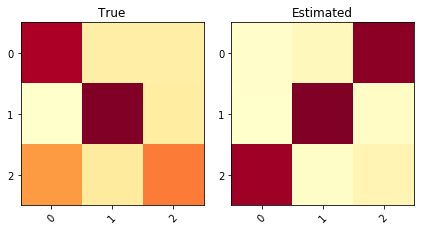

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


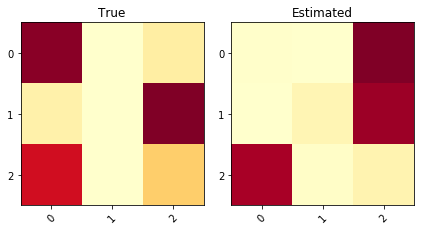

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


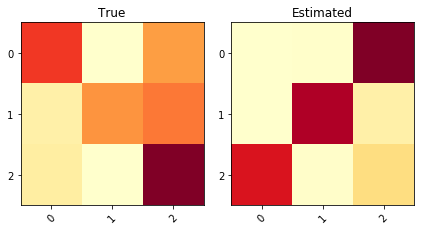

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


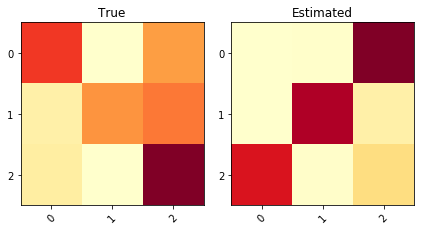

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


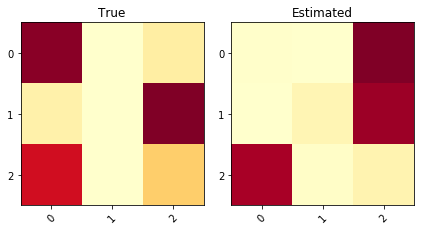

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


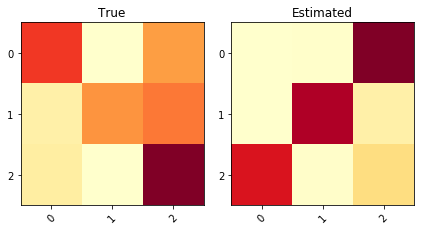

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


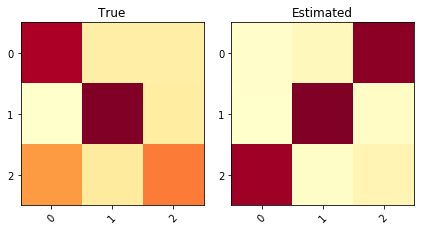

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


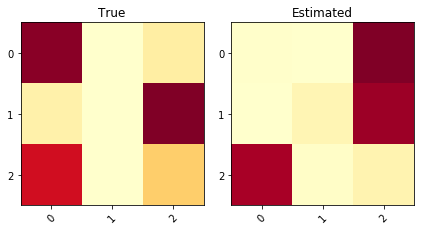

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


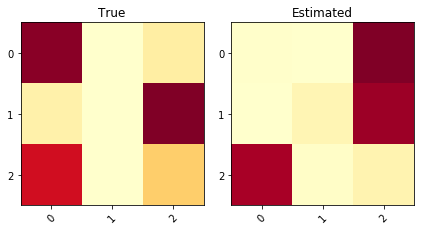

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


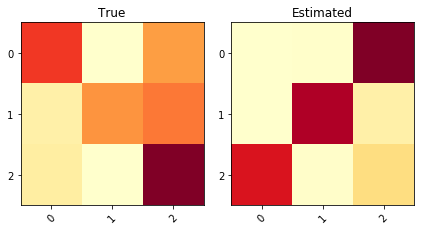

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


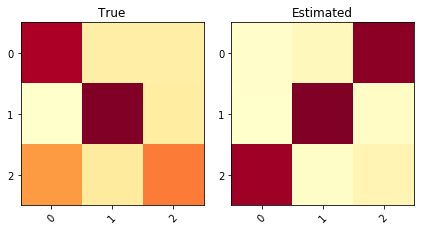

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


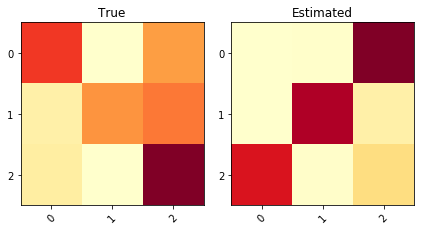

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


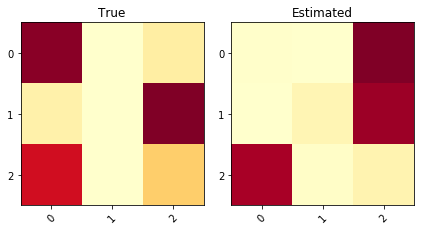

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


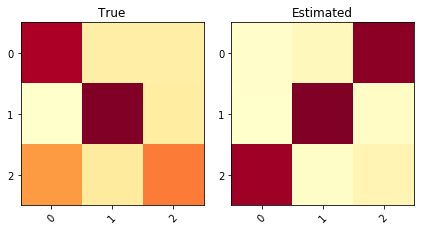

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.597884      0.597884     1.5097   0.208986           -0.348053        0.148848
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.680813                0.703747
====  =======================  ======================
Test


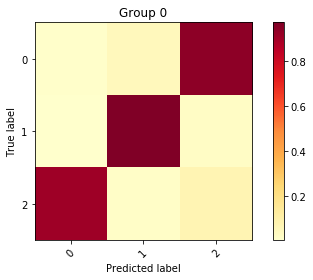

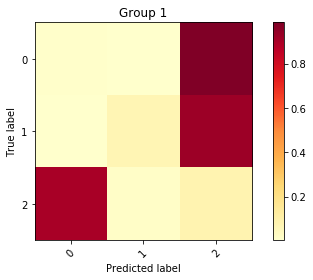

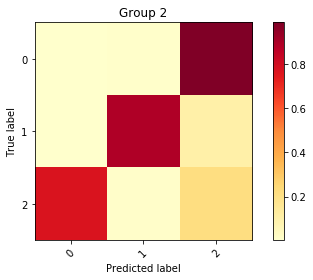

Inertia: 0.10848995065316558
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.326825      32   0.232576    0.351229     2.55813       0.402764   0.0178953    0.711844      0.711844
   1         1  0.286561      28   0.236939    0.0529269    3.31976       0.14267   -0.280406     0.565324      0.565324
   2         2  0.386613      38   0.336965    0.371128     2.42394       0.457802   0.0377947    0.896215      0.896215
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [59]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


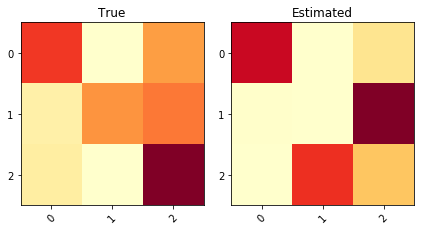

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


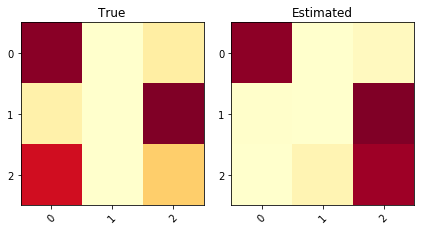

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


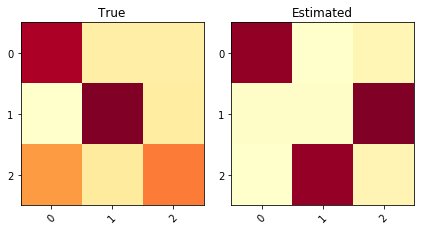

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


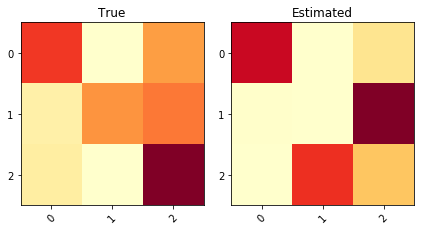

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


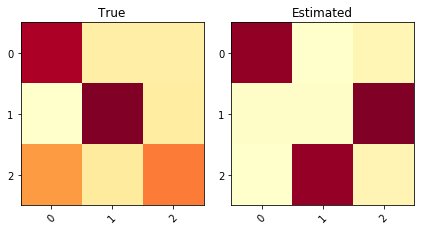

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


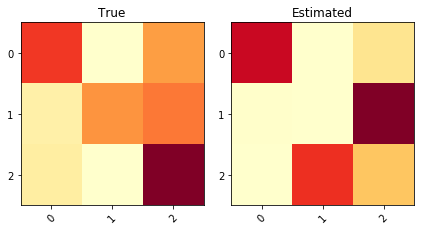

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


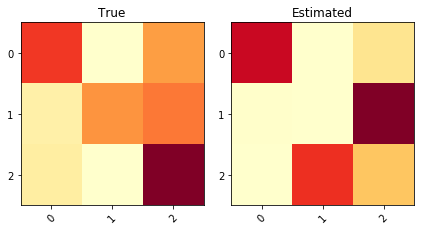

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


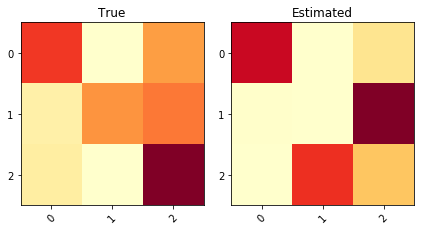

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


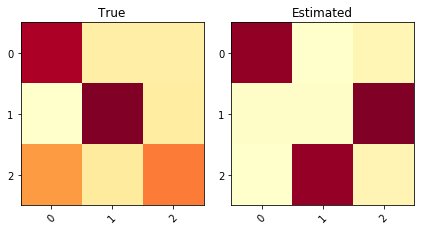

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


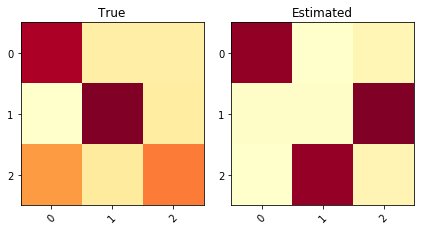

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


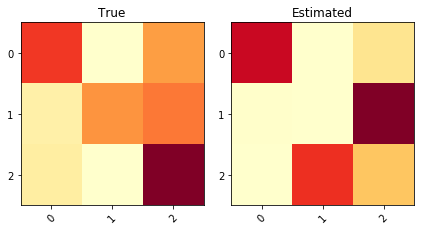

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


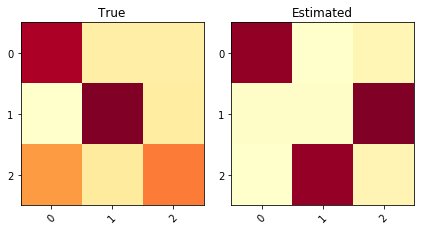

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


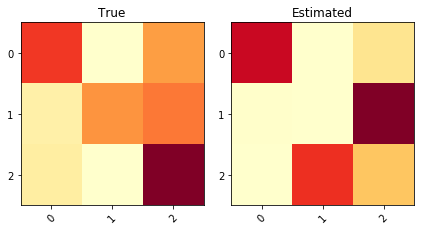

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


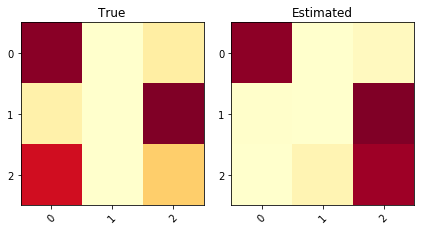

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


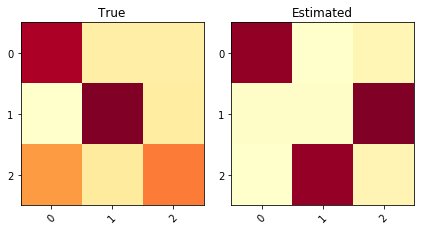

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.350834      0.350834     1.4957   0.205557            0.428808        0.150335
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.677046                0.699032
====  =======================  ======================
Test


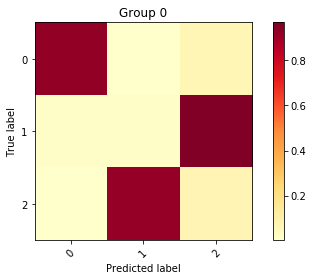

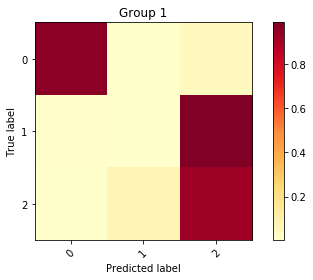

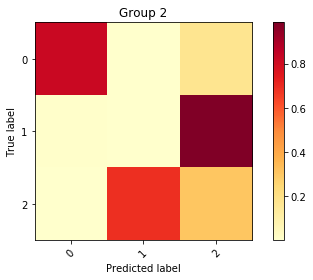

Inertia: 0.08358287128309409
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.300226      30   0.236477     0.338454    2.29225       0.403617  0.0051209    0.808303      0.808303
   1         1  0.337198      33   0.176395     0.628844    1.98815       0.651583  0.29551      0.579976      0.579976
   2         2  0.362576      36   0.398023     0.378613    2.25763       0.48055   0.0452801    0.796093      0.796093
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [60]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [27]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7802197802197802


In [ ]:
T_weights = np.sum(y_obs != -1,axis=0)

*** Soft-Majority (Train with softMV) ***
Train


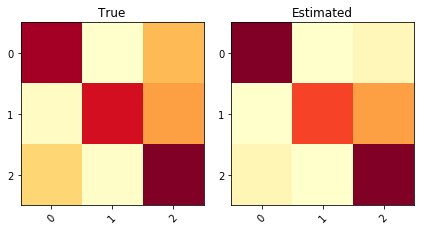

JS divergence: 0.1240	KL divergence: 0.3989


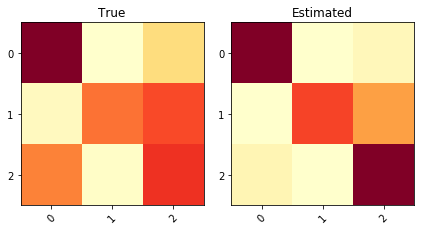

JS divergence: 0.1151	KL divergence: 0.3568


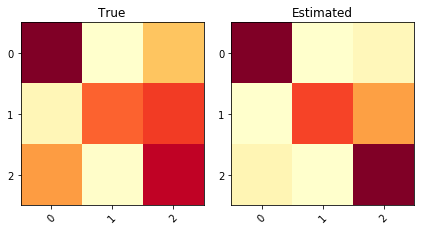

JS divergence: 0.1122	KL divergence: 0.3187


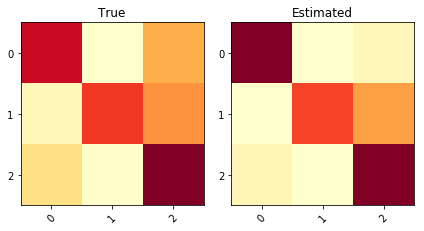

JS divergence: 0.1260	KL divergence: 0.3539


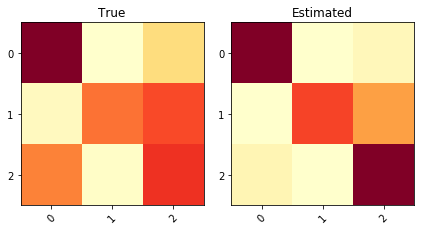

JS divergence: 0.1151	KL divergence: 0.3568


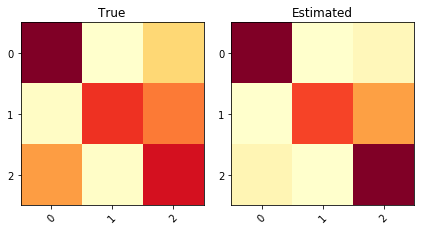

JS divergence: 0.1147	KL divergence: 0.3834


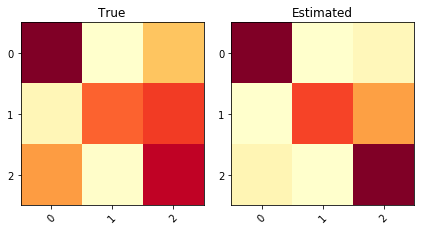

JS divergence: 0.1122	KL divergence: 0.3187


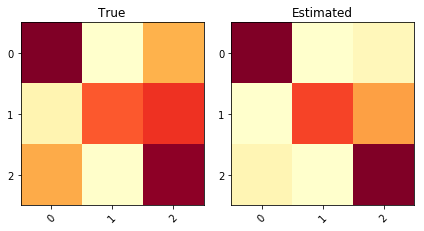

JS divergence: 0.1138	KL divergence: 0.3036


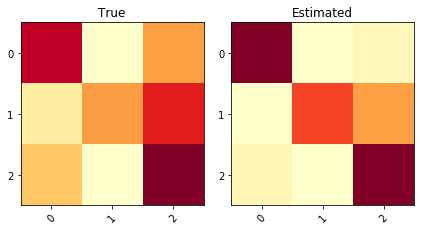

JS divergence: 0.1314	KL divergence: 0.2688


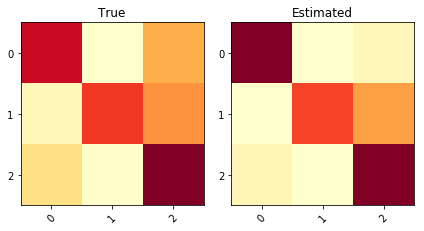

JS divergence: 0.1260	KL divergence: 0.3539


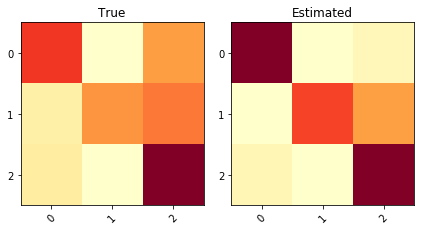

JS divergence: 0.1525	KL divergence: 0.3169


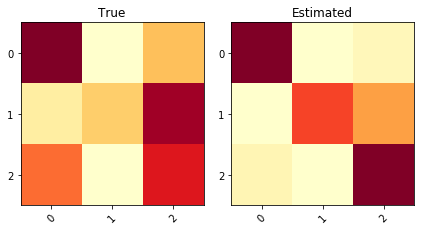

JS divergence: 0.1391	KL divergence: 0.2847


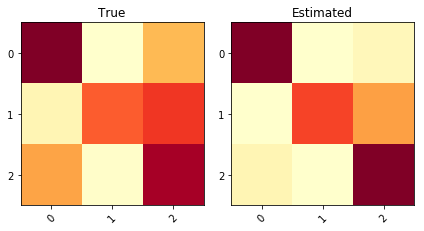

JS divergence: 0.1128	KL divergence: 0.3096


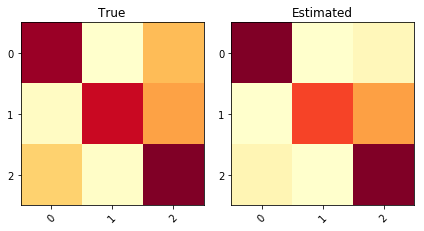

JS divergence: 0.1243	KL divergence: 0.4096


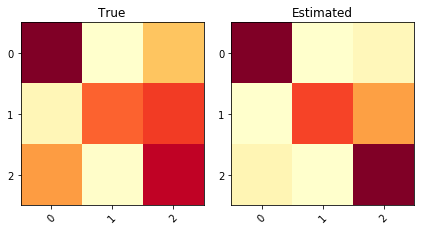

JS divergence: 0.1122	KL divergence: 0.3187
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.826211      0.826211   0.368424   0.138044
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.815629      0.815629
====  ======  ==========  ============


In [21]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


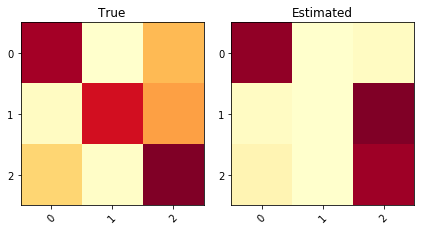

JS divergence: 0.2154	KL divergence: 3.5992


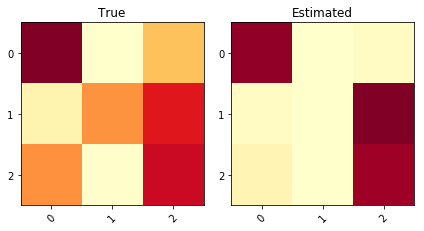

JS divergence: 0.1417	KL divergence: 2.0715


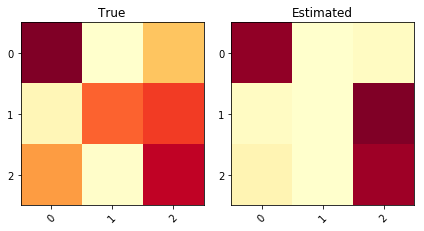

JS divergence: 0.1624	KL divergence: 2.5519


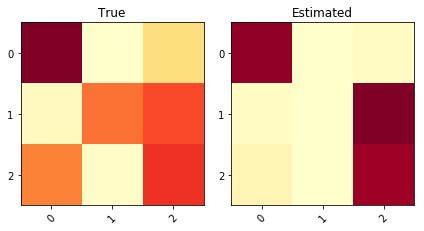

JS divergence: 0.1729	KL divergence: 2.6653


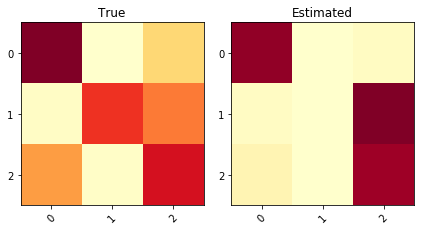

JS divergence: 0.1944	KL divergence: 3.2077


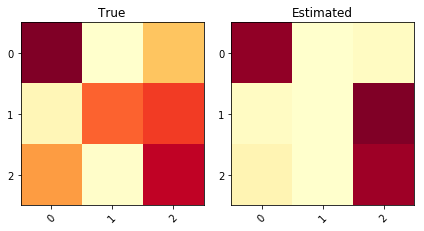

JS divergence: 0.1624	KL divergence: 2.5519


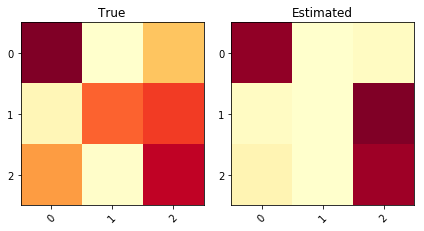

JS divergence: 0.1624	KL divergence: 2.5519


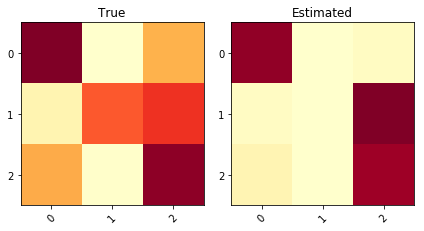

JS divergence: 0.1593	KL divergence: 2.4917


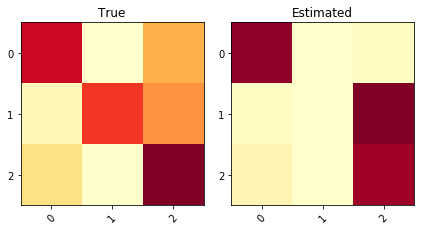

JS divergence: 0.1975	KL divergence: 3.1566


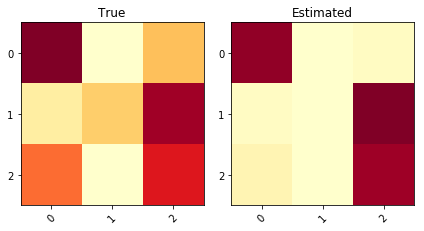

JS divergence: 0.1047	KL divergence: 1.1533


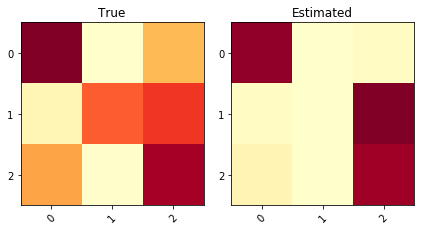

JS divergence: 0.1604	KL divergence: 2.5177


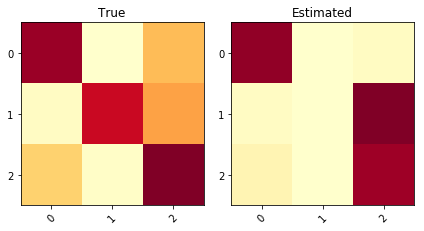

JS divergence: 0.2194	KL divergence: 3.6894


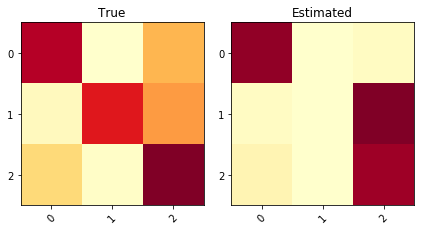

JS divergence: 0.2090	KL divergence: 3.4502


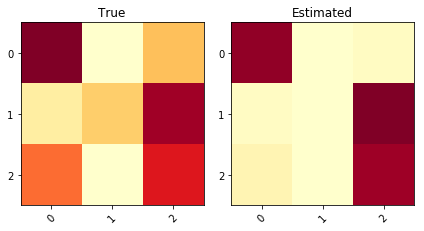

JS divergence: 0.1047	KL divergence: 1.1533


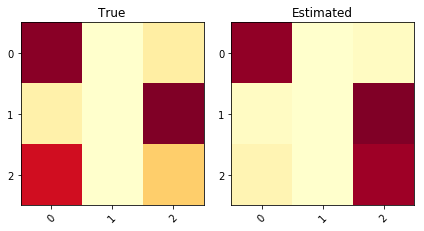

JS divergence: 0.1273	KL divergence: 0.2927
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.627188      0.627188    2.59514   0.176469
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.652015      0.652015
====  ======  ==========  ============


In [22]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


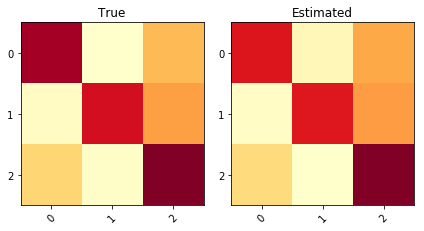

JS divergence: 0.0033	KL divergence: 0.0088


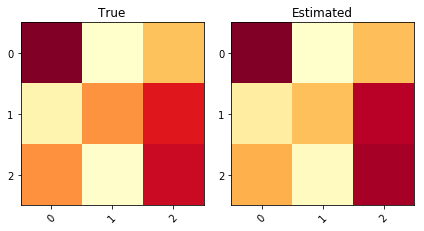

JS divergence: 0.0065	KL divergence: 0.0179


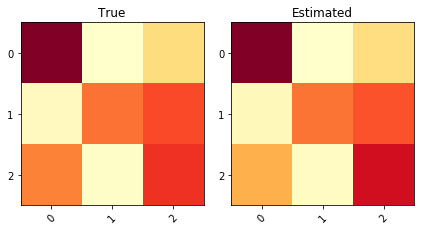

JS divergence: 0.0097	KL divergence: 0.1361


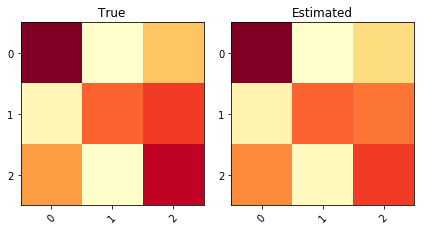

JS divergence: 0.0053	KL divergence: 0.0143


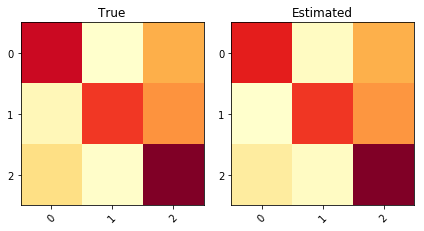

JS divergence: 0.0054	KL divergence: 0.0163


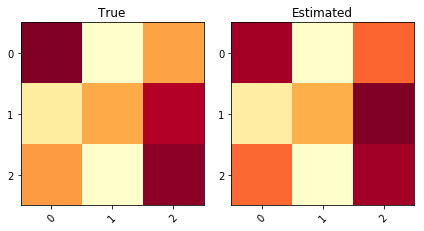

JS divergence: 0.0036	KL divergence: 0.0097


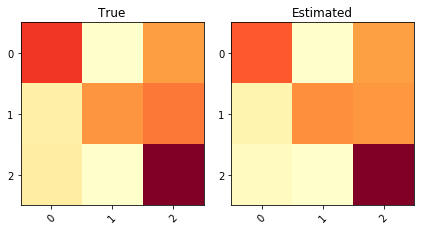

JS divergence: 0.0059	KL divergence: 0.0195


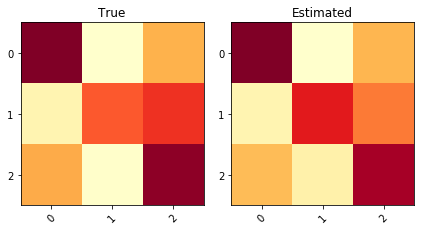

JS divergence: 0.0098	KL divergence: 0.0501


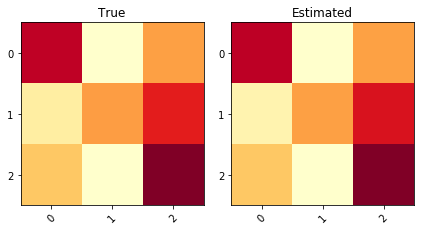

JS divergence: 0.0006	KL divergence: 0.0018


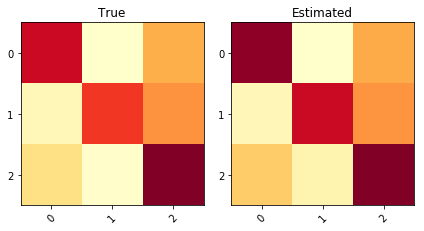

JS divergence: 0.0040	KL divergence: 0.0105


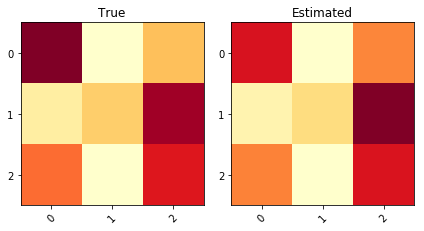

JS divergence: 0.0075	KL divergence: 0.0205


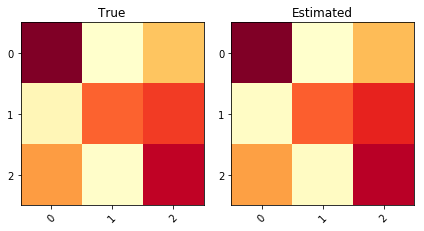

JS divergence: 0.0015	KL divergence: 0.0040


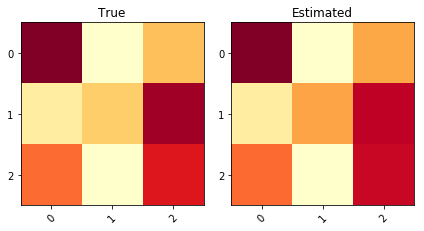

JS divergence: 0.0030	KL divergence: 0.0080


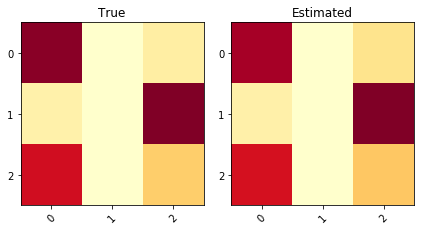

JS divergence: 0.0020	KL divergence: 0.0052


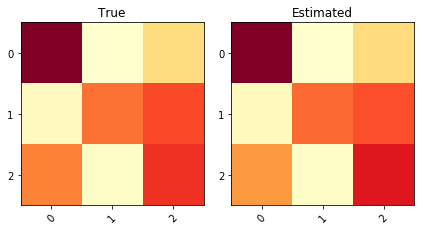

JS divergence: 0.0030	KL divergence: 0.0092
A result
 ====  ======  ==========  ============  =========  ==========
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS
====  ======  ==========  ============  =========  ==========
   0  Global    0.906797      0.906797  0.0239761  0.00460544
====  ======  ==========  ============  =========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.918193      0.918193
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


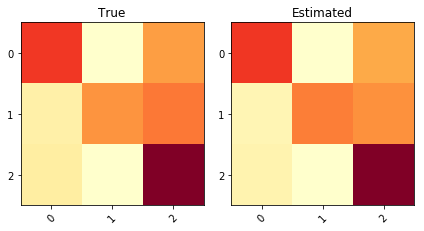

JS divergence: 0.0052	KL divergence: 0.0113


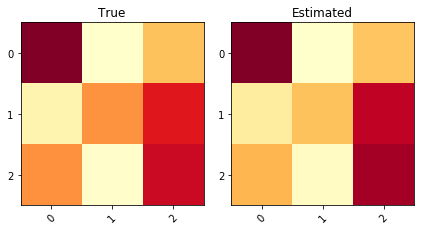

JS divergence: 0.0084	KL divergence: 0.0226


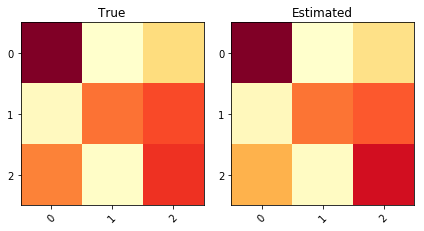

JS divergence: 0.0048	KL divergence: 0.0140


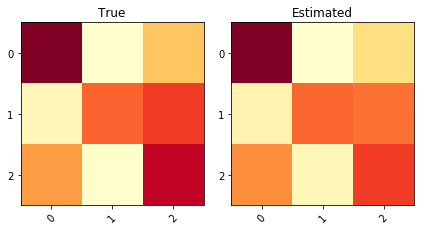

JS divergence: 0.0070	KL divergence: 0.0183


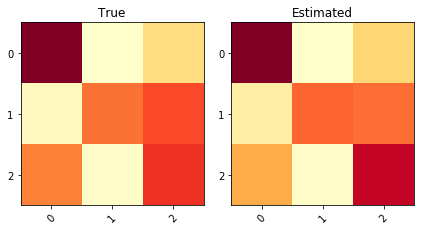

JS divergence: 0.0055	KL divergence: 0.0149


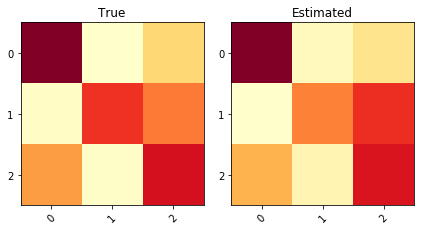

JS divergence: 0.0089	KL divergence: 0.0233


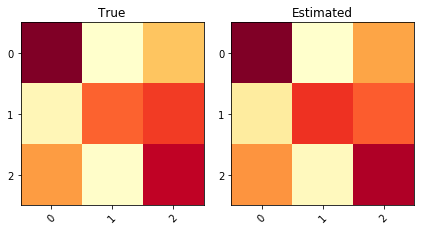

JS divergence: 0.0031	KL divergence: 0.0087


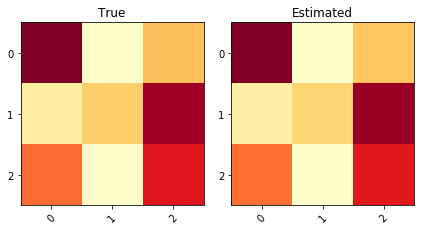

JS divergence: 0.0038	KL divergence: 0.0076


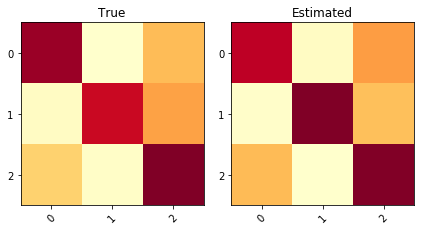

JS divergence: 0.0051	KL divergence: 0.0139


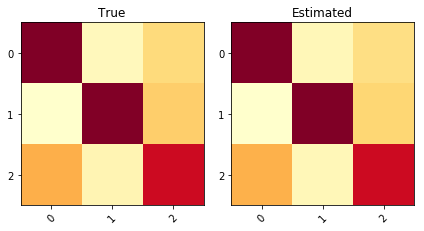

JS divergence: 0.0006	KL divergence: 0.0015


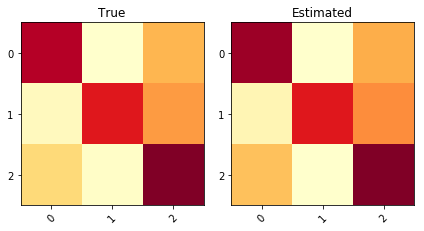

JS divergence: 0.0025	KL divergence: 0.0065


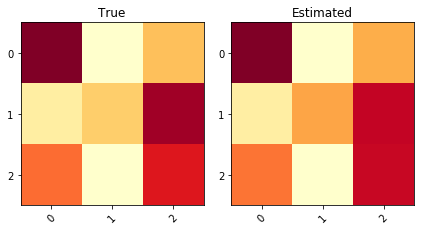

JS divergence: 0.0078	KL divergence: 0.0180


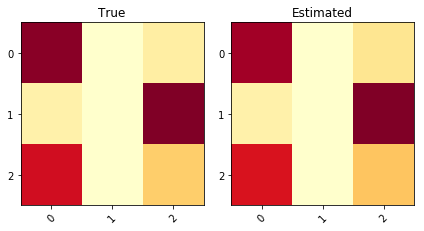

JS divergence: 0.0074	KL divergence: 0.0161


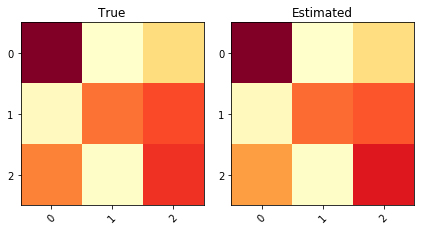

JS divergence: 0.0014	KL divergence: 0.0041


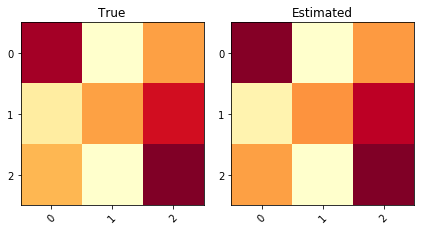

JS divergence: 0.0047	KL divergence: 0.0101
A result
 ====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
   0  Global    0.924705      0.924705  0.0132561  0.00531207     0.01322  0.00529579     0.128172      0.126848
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.617248                0.824658
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ==

In [24]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


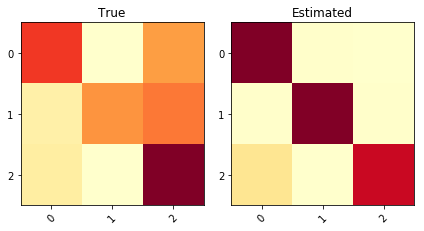

JS divergence: 0.1833	KL divergence: 1.0713


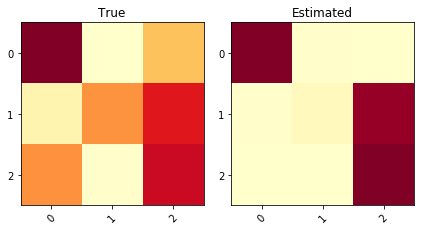

JS divergence: 0.1605	KL divergence: 0.8892


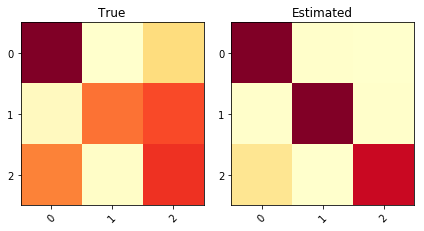

JS divergence: 0.1603	KL divergence: 0.8398


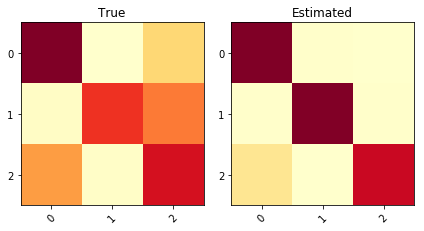

JS divergence: 0.1352	KL divergence: 0.7218


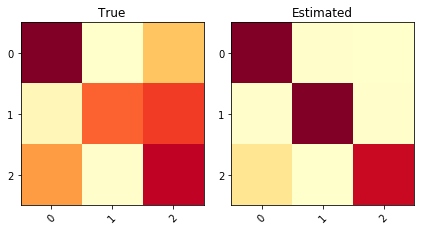

JS divergence: 0.1585	KL divergence: 0.8695


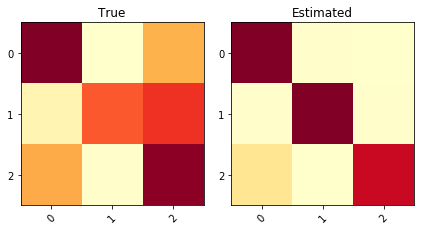

JS divergence: 0.1593	KL divergence: 0.8952


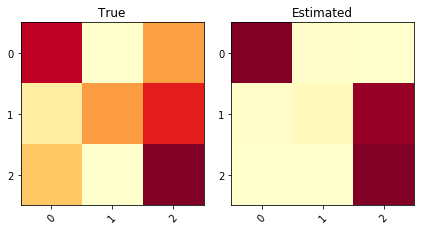

JS divergence: 0.1476	KL divergence: 0.8025


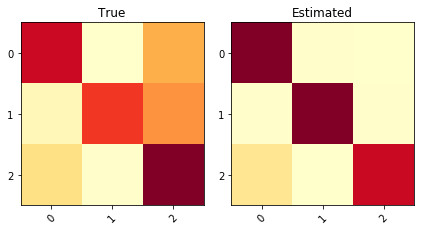

JS divergence: 0.1361	KL divergence: 0.7919


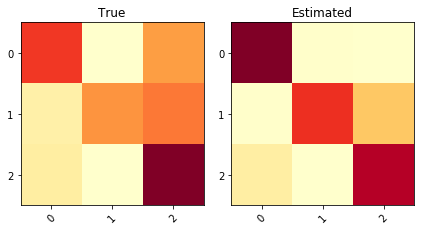

JS divergence: 0.0959	KL divergence: 0.5630


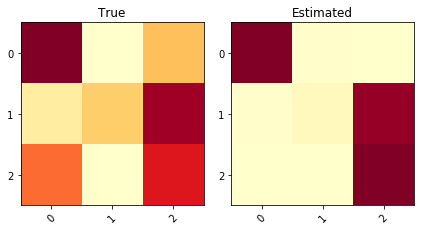

JS divergence: 0.1473	KL divergence: 0.8735


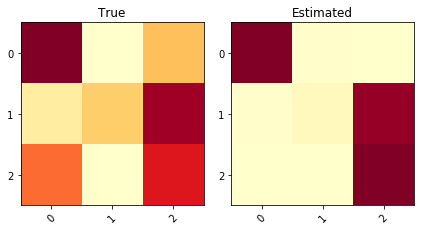

JS divergence: 0.1473	KL divergence: 0.8735


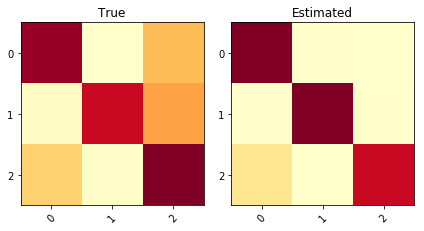

JS divergence: 0.1166	KL divergence: 0.6577


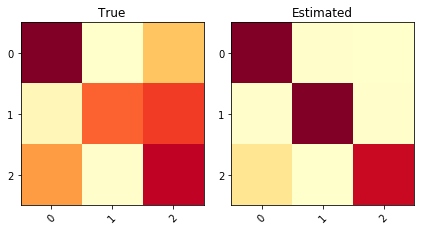

JS divergence: 0.1585	KL divergence: 0.8695


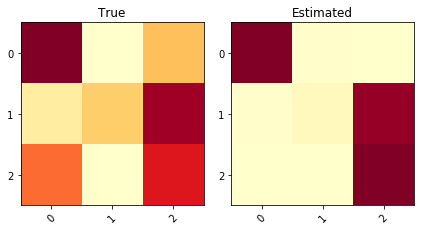

JS divergence: 0.1473	KL divergence: 0.8735


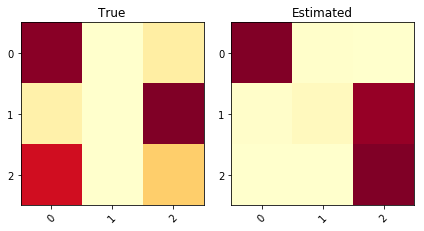

JS divergence: 0.2033	KL divergence: 1.2435
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.921856      0.921856   0.815297   0.148338    0.816889    0.148567     0.158634      0.159153
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.601312                0.908474
====  =======================  ======================
Test


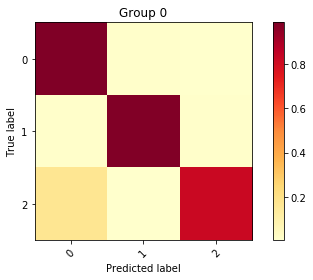

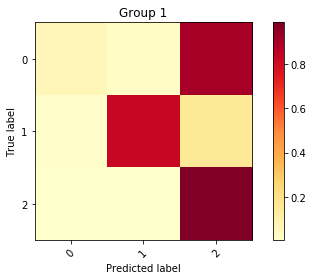

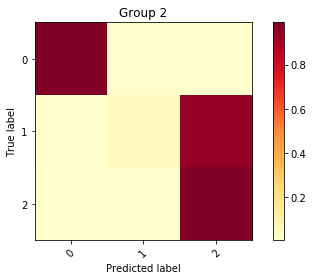

Inertia: 0.34872377145426786
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.404531      40   0.225762     0.930967  0.0749187       0.94724    0.896451    0.848596      0.848596
   1         1  0.225204      22   0.309648     0.628846  0.971932        0.559046   0.443269    0.578755      0.578755
   2         2  0.370265      37   0.127029     0.673543  1.0514          0.576449   0.510314    0.644689      0.644689
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [25]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [33]:
predictions_m,prob_Gt,prob_Yzt,prob_Yxt = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)

In [34]:
prob_Gt

array([[1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.69, 0.  , 0.31],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.99, 0.01, 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
 

*** Ours (1) multiples runs***
Train


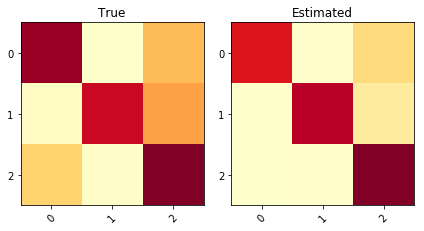

KL divergence: 0.3232	Pearson Correlation between diagonals: 0.3613


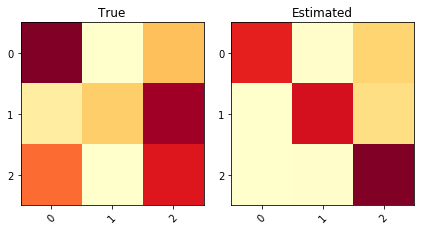

KL divergence: 0.8276	Pearson Correlation between diagonals: -0.0154


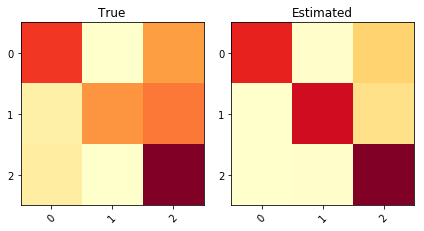

KL divergence: 0.2438	Pearson Correlation between diagonals: 0.7721


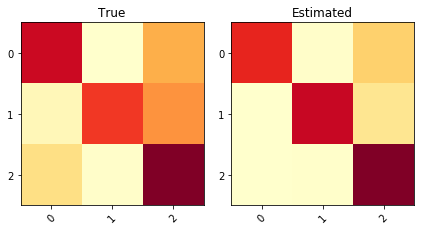

KL divergence: 0.2599	Pearson Correlation between diagonals: 0.6147


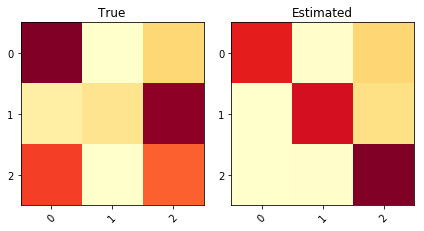

KL divergence: 1.0898	Pearson Correlation between diagonals: -0.2214


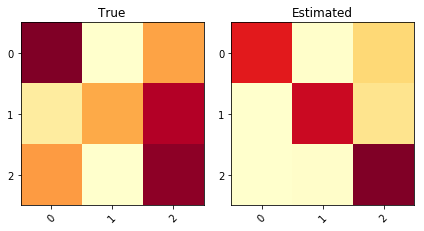

KL divergence: 0.6288	Pearson Correlation between diagonals: 0.1700


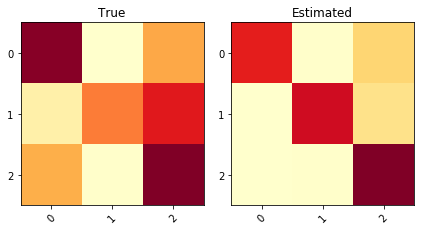

KL divergence: 0.4777	Pearson Correlation between diagonals: 0.2675


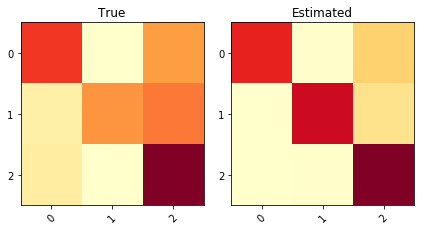

KL divergence: 0.2488	Pearson Correlation between diagonals: 0.7393


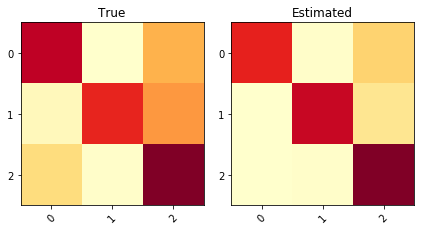

KL divergence: 0.2724	Pearson Correlation between diagonals: 0.6012


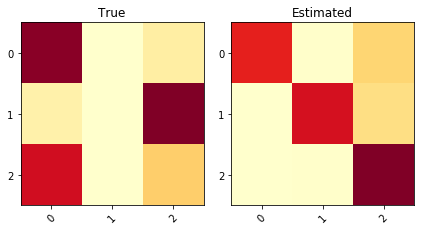

KL divergence: 1.7259	Pearson Correlation between diagonals: -0.4344


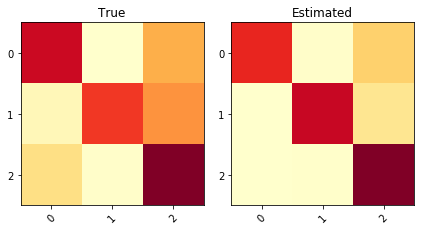

KL divergence: 0.2591	Pearson Correlation between diagonals: 0.6131


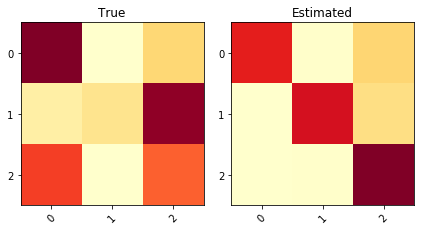

KL divergence: 1.0866	Pearson Correlation between diagonals: -0.2120


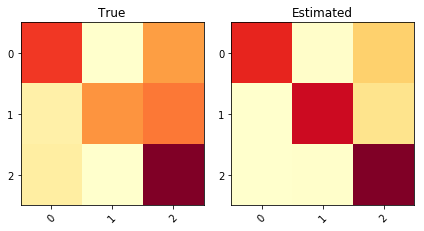

KL divergence: 0.2478	Pearson Correlation between diagonals: 0.7236


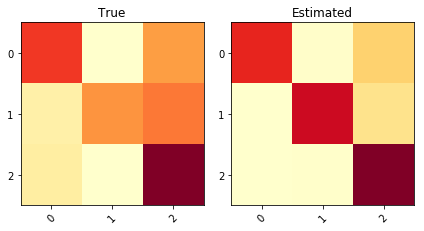

KL divergence: 0.2480	Pearson Correlation between diagonals: 0.7300


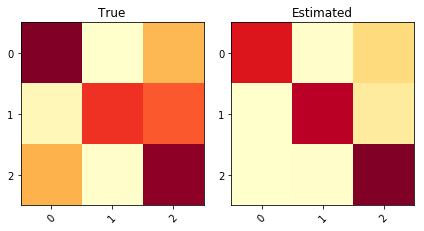

KL divergence: 0.4554	Pearson Correlation between diagonals: -0.0444
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.820513      0.820513   0.520173  0.0737737           0.0394929       0.0691972
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.620714                0.792509
====  =======================  ======================
Test


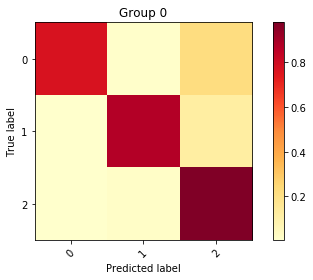

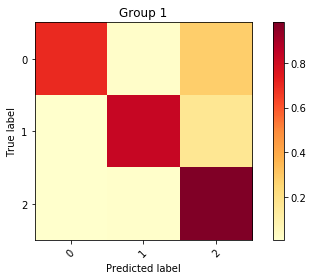

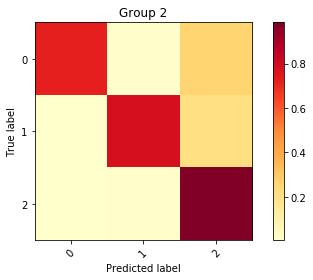

Inertia: 0.001852757598195846
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.367625      36   0.364847     0.874186   0.139261       0.932436   0.540853    0.769231      0.769231
   1         1  0.268373      26   0.415645     0.838624   0.185258       0.911159   0.50529     0.688645      0.688645
   2         2  0.364003      36   0.42033      0.831836   0.192676       0.907515   0.498502    0.661783      0.661783
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [84]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


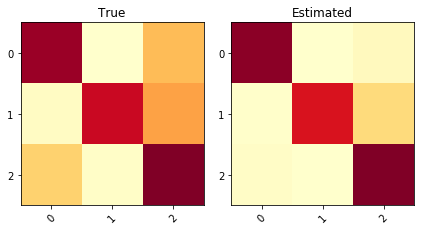

KL divergence: 0.3171	Pearson Correlation between diagonals: 0.9744


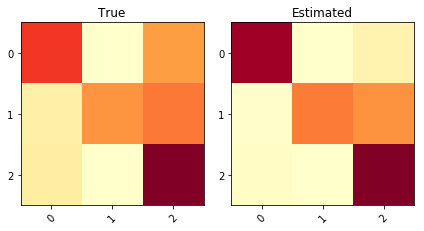

KL divergence: 0.1976	Pearson Correlation between diagonals: 0.8653


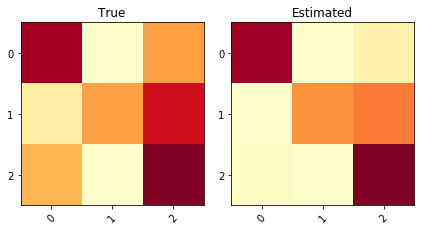

KL divergence: 0.2630	Pearson Correlation between diagonals: 1.0000


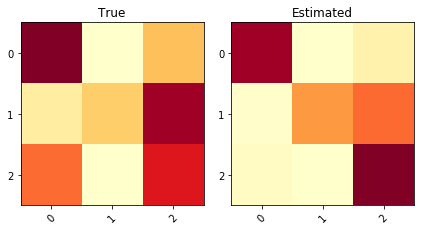

KL divergence: 0.3929	Pearson Correlation between diagonals: 0.9058


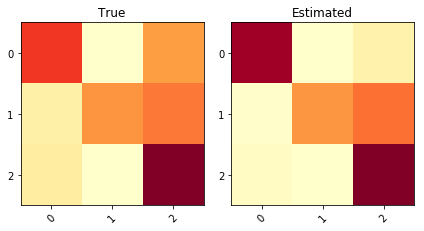

KL divergence: 0.1846	Pearson Correlation between diagonals: 0.8607


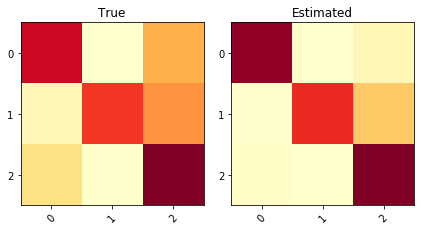

KL divergence: 0.2575	Pearson Correlation between diagonals: 0.9122


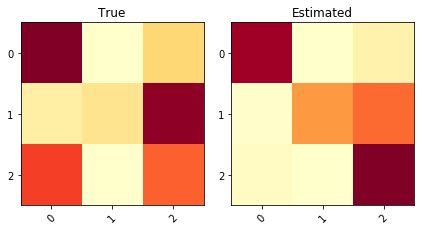

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


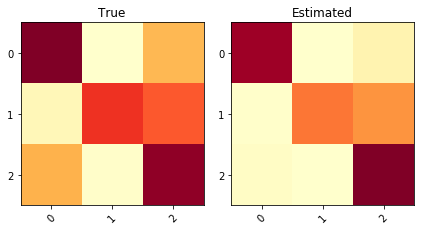

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9753


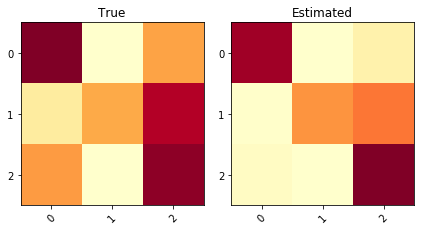

KL divergence: 0.3003	Pearson Correlation between diagonals: 0.9871


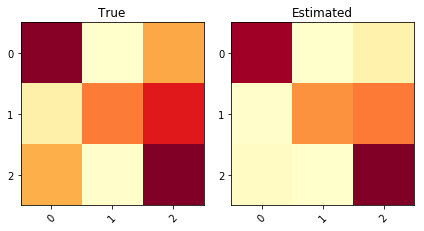

KL divergence: 0.2502	Pearson Correlation between diagonals: 0.9966


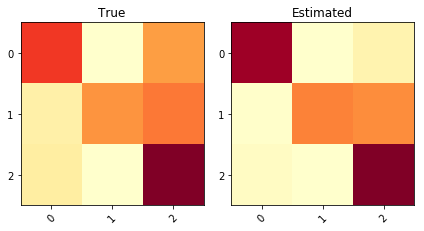

KL divergence: 0.1947	Pearson Correlation between diagonals: 0.8643


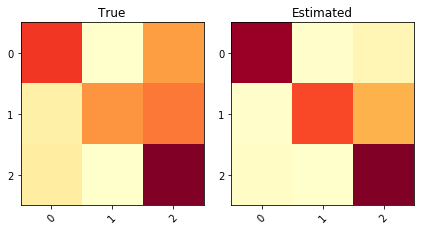

KL divergence: 0.2346	Pearson Correlation between diagonals: 0.8737


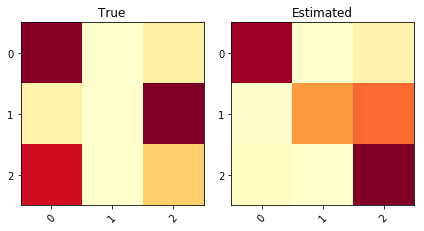

KL divergence: 0.9132	Pearson Correlation between diagonals: 0.6389


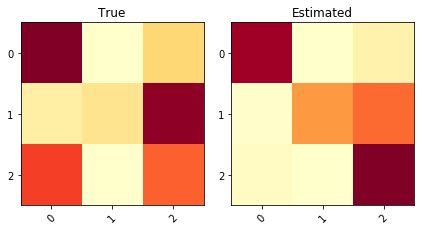

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


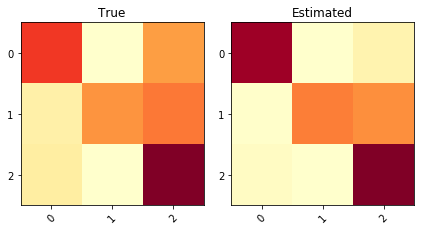

KL divergence: 0.1963	Pearson Correlation between diagonals: 0.8649
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.922263      0.922263   0.353131  0.0592165            0.703907       0.0559583
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.634365                0.789554
====  =======================  ======================
Test


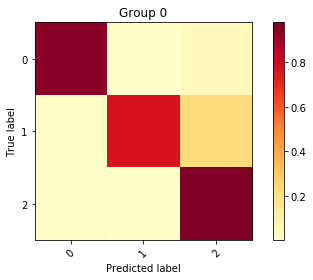

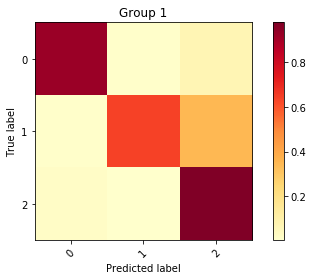

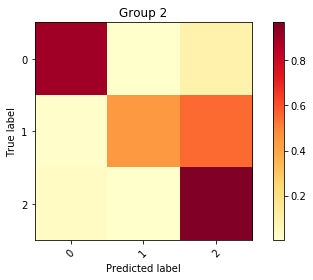

Inertia: 0.010852160902383426
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.389124      38   0.295749     0.899965   0.111069       0.946175   0.566631    0.879121      0.879121
   1         1  0.270756      27   0.367987     0.847832   0.18157        0.914092   0.514498    0.726496      0.726496
   2         2  0.34012       34   0.405299     0.770491   0.31794        0.857818   0.437158    0.649573      0.649573
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [85]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 10 )

In [20]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7716727716727717


In [ ]:
T_weights = np.sum(y_obs != -1,axis=0)

*** Soft-Majority (Train with softMV) ***
Train


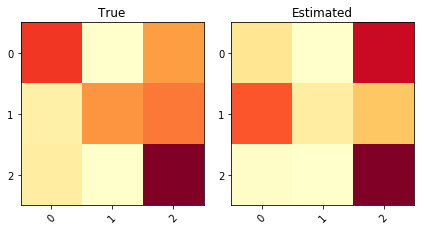

JS divergence: 0.0820	KL divergence: 0.1817


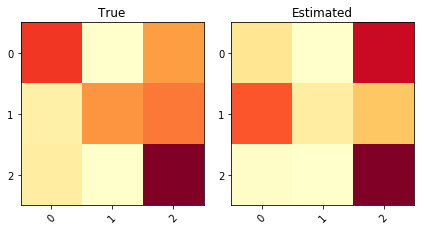

JS divergence: 0.0820	KL divergence: 0.1817


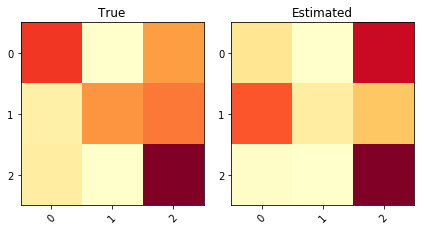

JS divergence: 0.0820	KL divergence: 0.1817


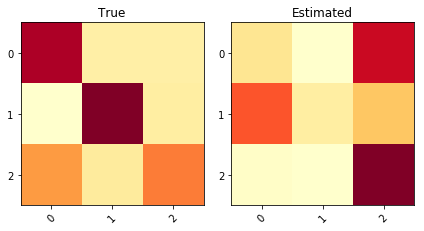

JS divergence: 0.2130	KL divergence: 1.3479


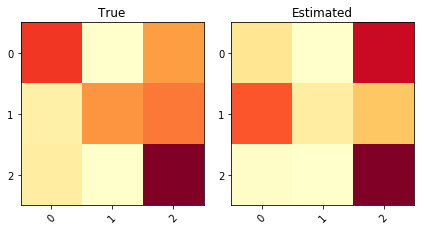

JS divergence: 0.0820	KL divergence: 0.1817


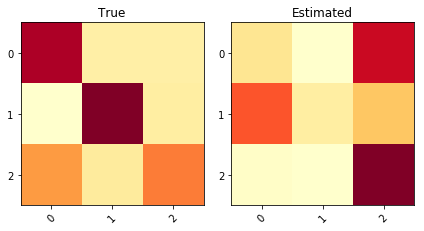

JS divergence: 0.2130	KL divergence: 1.3479


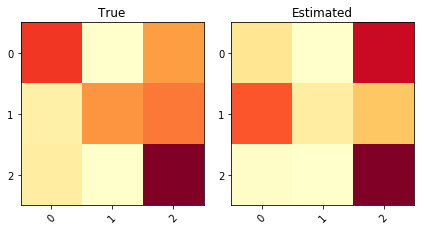

JS divergence: 0.0820	KL divergence: 0.1817


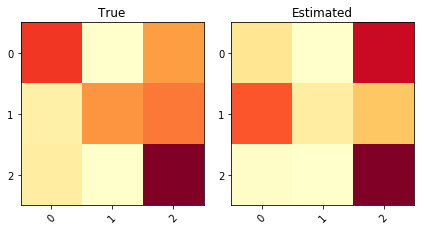

JS divergence: 0.0820	KL divergence: 0.1817


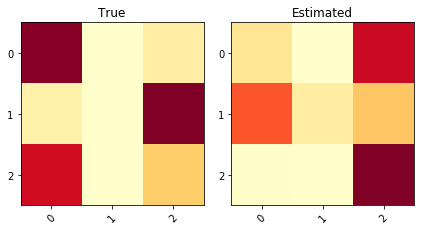

JS divergence: 0.1975	KL divergence: 0.4278


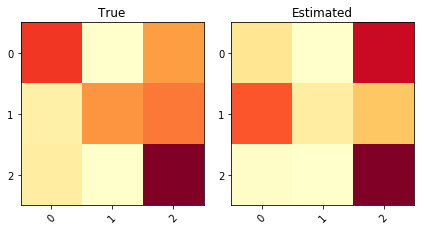

JS divergence: 0.0820	KL divergence: 0.1817


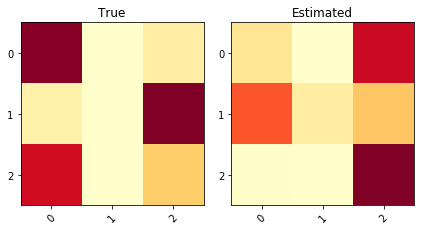

JS divergence: 0.1975	KL divergence: 0.4278


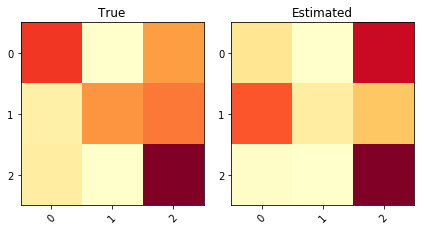

JS divergence: 0.0820	KL divergence: 0.1817


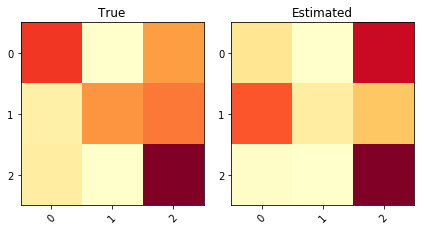

JS divergence: 0.0820	KL divergence: 0.1817


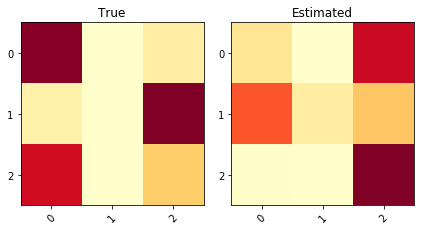

JS divergence: 0.1975	KL divergence: 0.4278


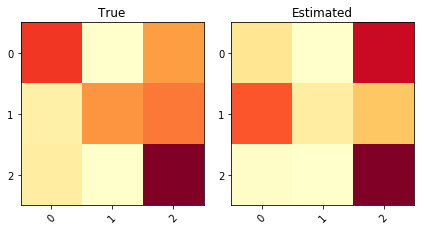

JS divergence: 0.0820	KL divergence: 0.1817
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.421652      0.421652   0.512505   0.137152
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.42735       0.42735
====  ======  ==========  ============


In [21]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


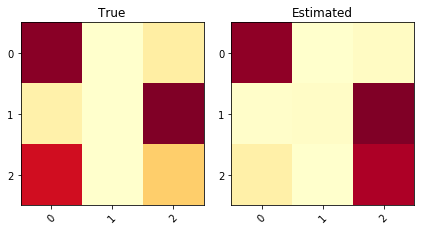

JS divergence: 0.1975	KL divergence: 0.4278


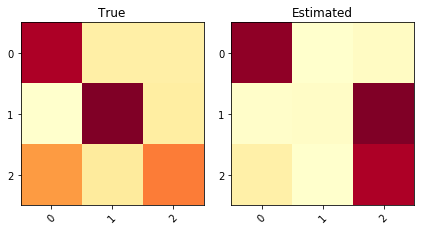

JS divergence: 0.2130	KL divergence: 1.3479


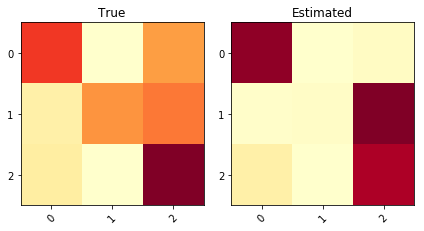

JS divergence: 0.0820	KL divergence: 0.1817


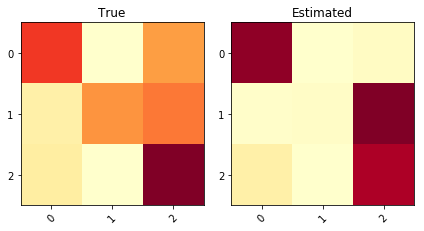

JS divergence: 0.0820	KL divergence: 0.1817


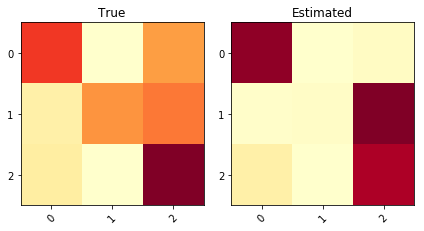

JS divergence: 0.0820	KL divergence: 0.1817


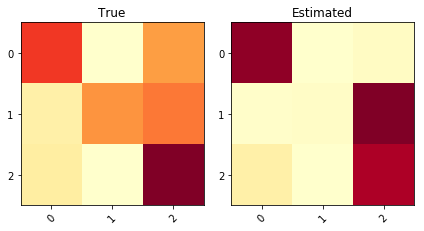

JS divergence: 0.0820	KL divergence: 0.1817


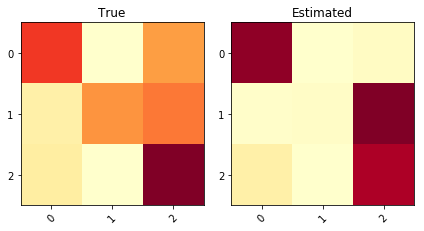

JS divergence: 0.0820	KL divergence: 0.1817


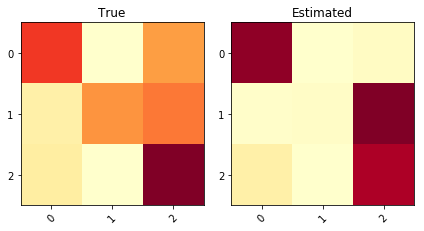

JS divergence: 0.0820	KL divergence: 0.1817


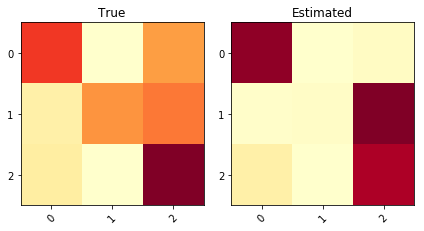

JS divergence: 0.0820	KL divergence: 0.1817


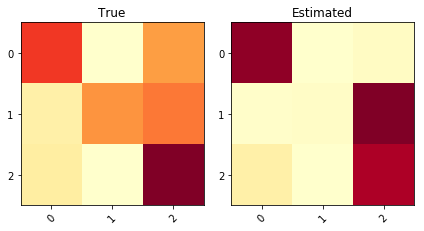

JS divergence: 0.0820	KL divergence: 0.1817


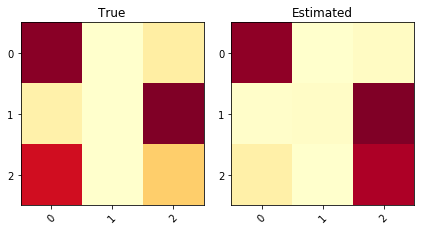

JS divergence: 0.1975	KL divergence: 0.4278


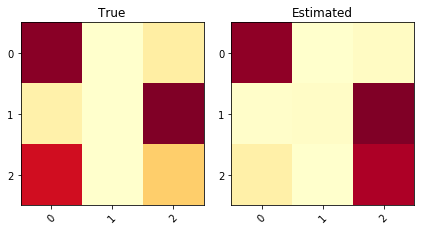

JS divergence: 0.1975	KL divergence: 0.4278


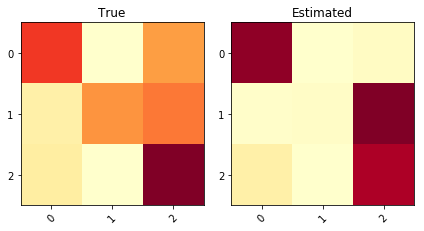

JS divergence: 0.0820	KL divergence: 0.1817


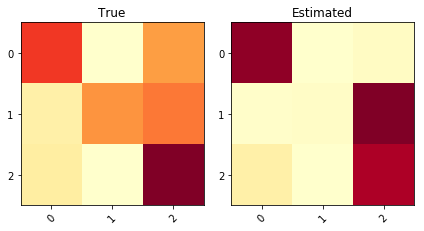

JS divergence: 0.0820	KL divergence: 0.1817


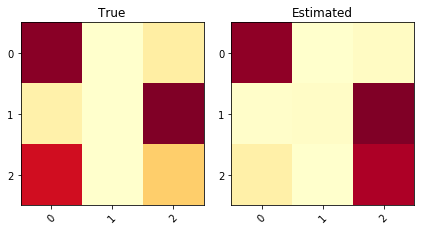

JS divergence: 0.1975	KL divergence: 0.4278
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.624339      0.624339   0.512505   0.137152
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.650794      0.650794
====  ======  ==========  ============


In [22]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


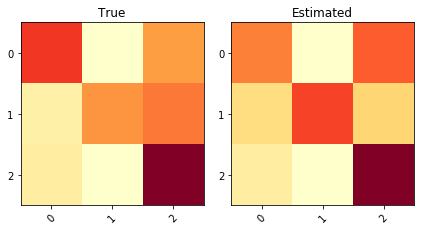

JS divergence: 0.0236	KL divergence: 0.0686


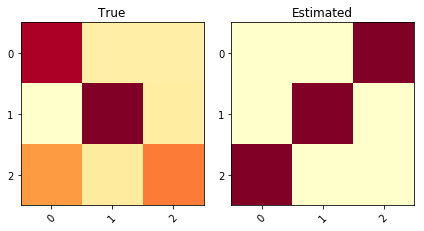

JS divergence: 0.4048	KL divergence: 7.9905


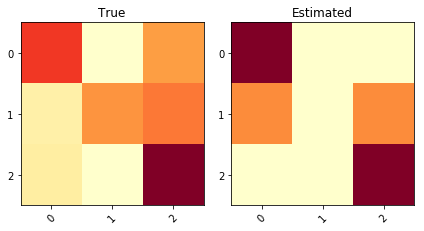

JS divergence: 0.2035	KL divergence: 4.4405


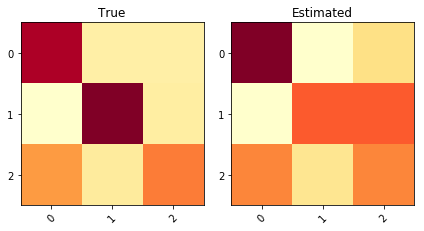

JS divergence: 0.0661	KL divergence: 0.5320


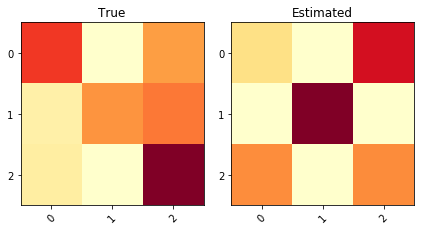

JS divergence: 0.2149	KL divergence: 3.0340


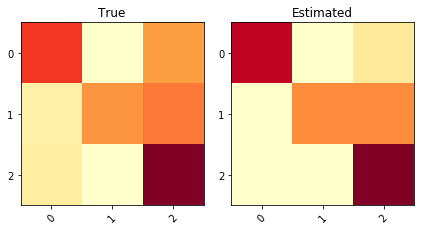

JS divergence: 0.0540	KL divergence: 0.9052


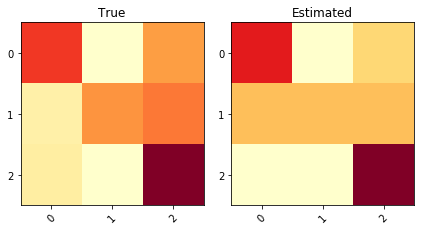

JS divergence: 0.0461	KL divergence: 0.5246


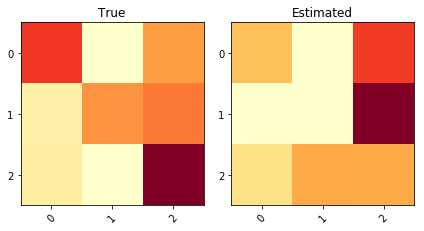

JS divergence: 0.2213	KL divergence: 2.4597


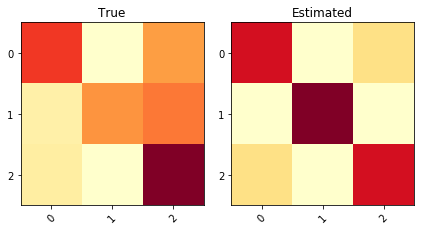

JS divergence: 0.1399	KL divergence: 2.8272


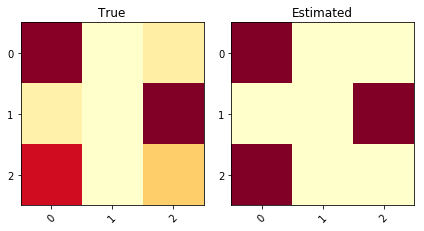

JS divergence: 0.0808	KL divergence: 2.0172


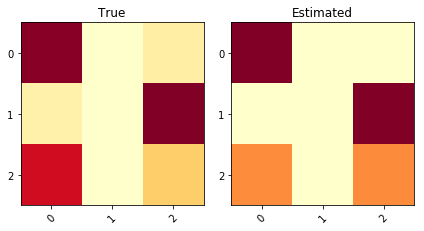

JS divergence: 0.0481	KL divergence: 0.8583


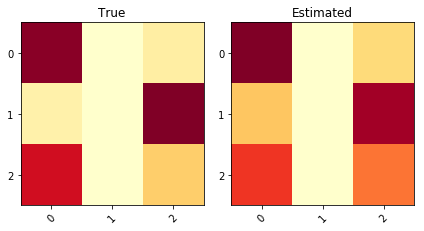

JS divergence: 0.0246	KL divergence: 0.0632


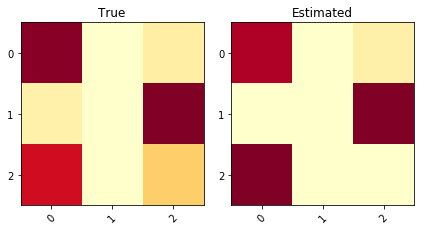

JS divergence: 0.0626	KL divergence: 1.5639


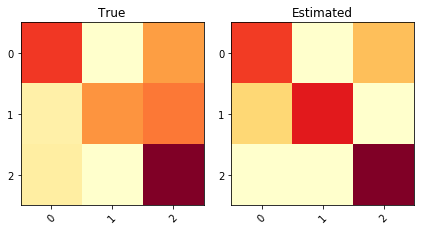

JS divergence: 0.1174	KL divergence: 2.4724


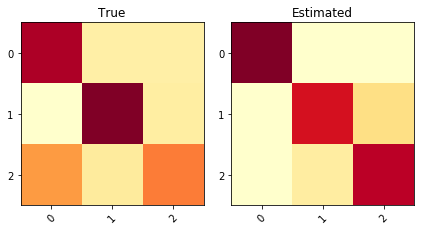

JS divergence: 0.1205	KL divergence: 2.7743
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global     0.93081       0.93081    1.96961   0.115499
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.948718      0.948718
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


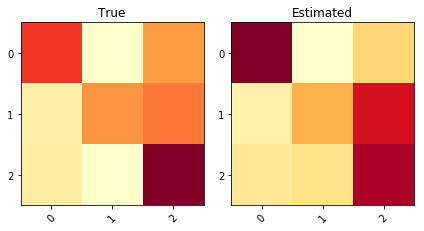

JS divergence: 0.0800	KL divergence: 0.1779


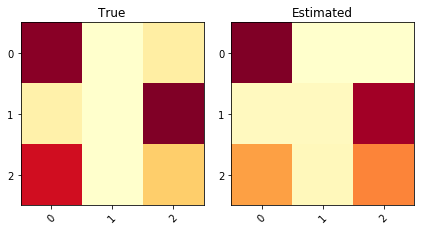

JS divergence: 0.0941	KL divergence: 0.2105


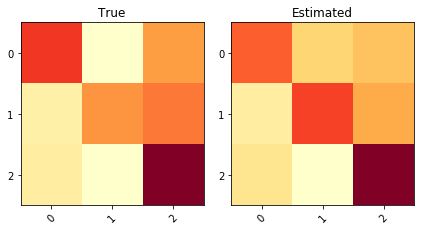

JS divergence: 0.0744	KL divergence: 0.1620


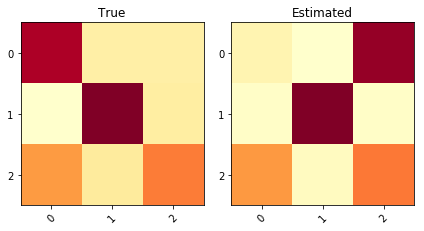

JS divergence: 0.1401	KL divergence: 0.3706


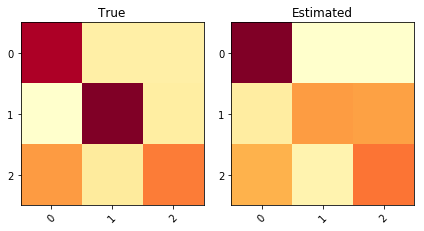

JS divergence: 0.0813	KL divergence: 0.1998


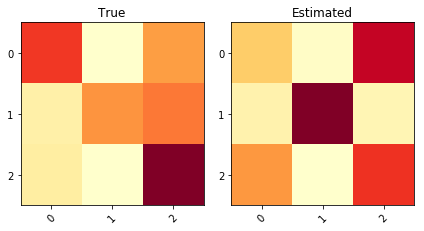

JS divergence: 0.1265	KL divergence: 0.3282


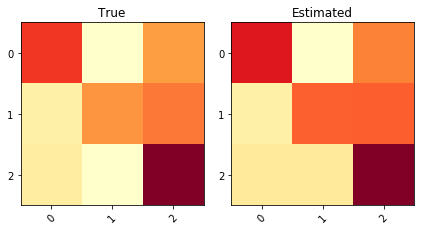

JS divergence: 0.0840	KL divergence: 0.1845


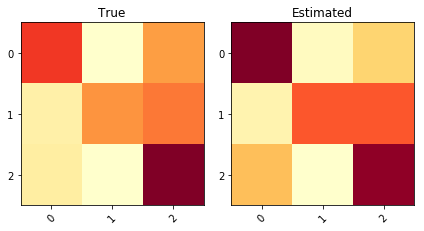

JS divergence: 0.0599	KL divergence: 0.1356


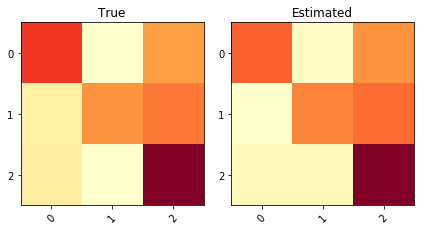

JS divergence: 0.0613	KL divergence: 0.1302


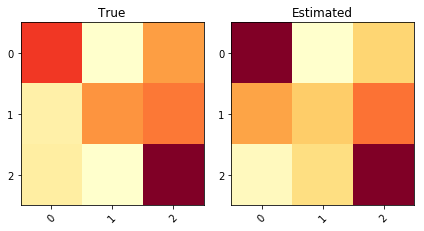

JS divergence: 0.1005	KL divergence: 0.2234


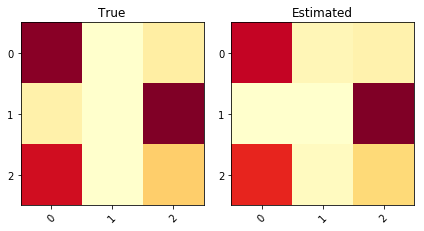

JS divergence: 0.0845	KL divergence: 0.1789


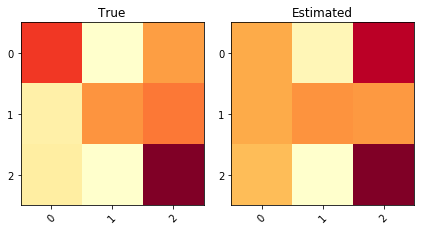

JS divergence: 0.0984	KL divergence: 0.2326


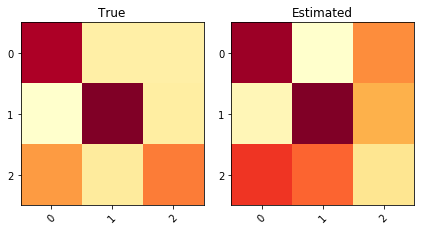

JS divergence: 0.0990	KL divergence: 0.2492


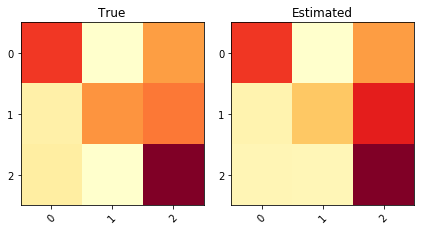

JS divergence: 0.0445	KL divergence: 0.0960


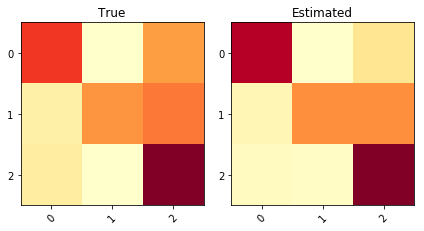

JS divergence: 0.0459	KL divergence: 0.1019
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.913309      0.913309   0.211611   0.089661    0.200617   0.0851504     0.138719      0.138591
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.737901                0.777487
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ====== 

In [24]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


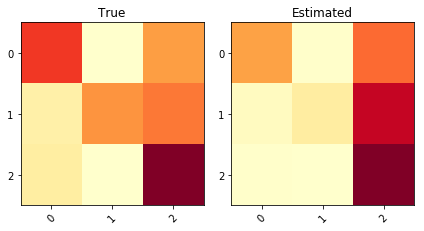

JS divergence: 0.0579	KL divergence: 0.2035


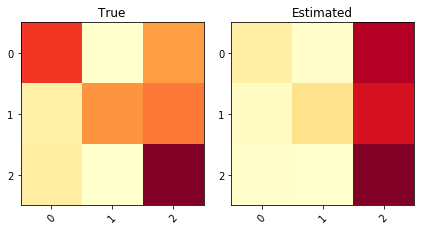

JS divergence: 0.1062	KL divergence: 0.3697


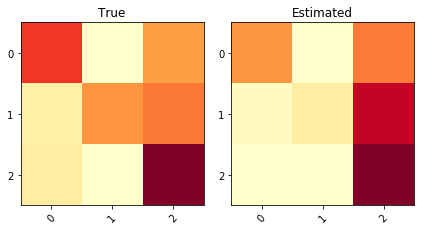

JS divergence: 0.0548	KL divergence: 0.1909


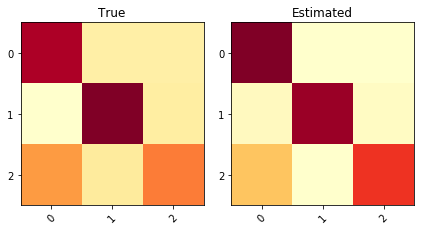

JS divergence: 0.0640	KL divergence: 0.3381


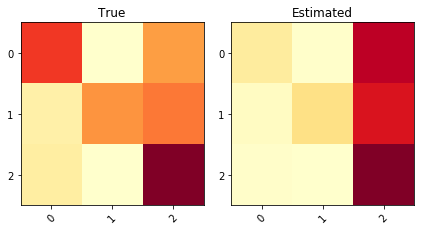

JS divergence: 0.0946	KL divergence: 0.3139


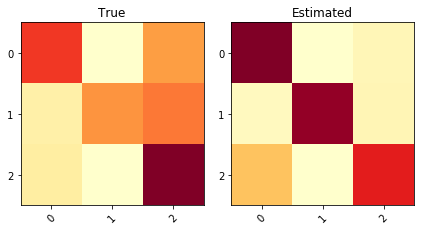

JS divergence: 0.1265	KL divergence: 0.4540


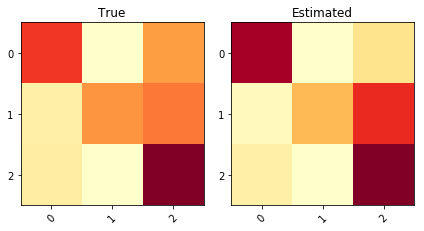

JS divergence: 0.0239	KL divergence: 0.0715


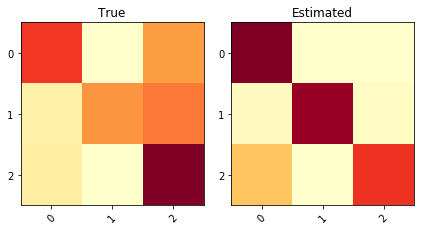

JS divergence: 0.1769	KL divergence: 0.9377


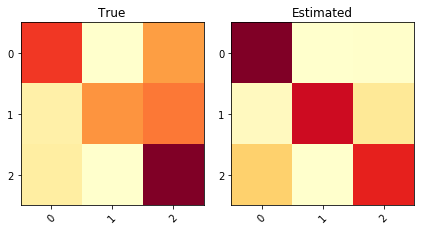

JS divergence: 0.1223	KL divergence: 0.6072


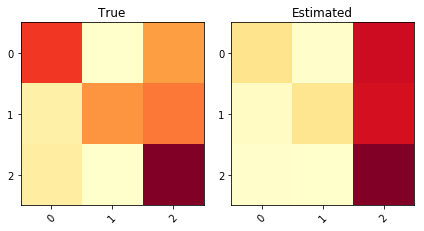

JS divergence: 0.0861	KL divergence: 0.2835


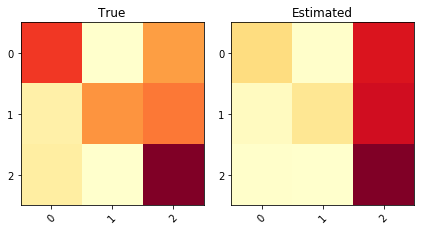

JS divergence: 0.0798	KL divergence: 0.2652


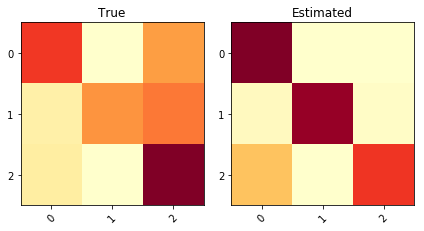

JS divergence: 0.1816	KL divergence: 0.9878


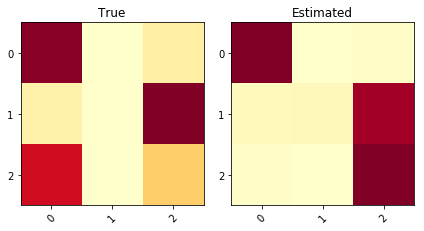

JS divergence: 0.1829	KL divergence: 0.9208


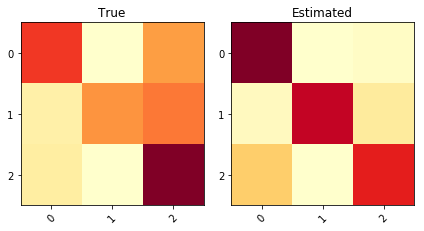

JS divergence: 0.1158	KL divergence: 0.4513


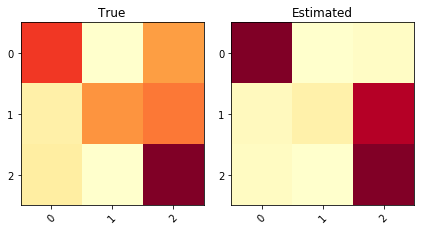

JS divergence: 0.1066	KL divergence: 0.4352
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.921042      0.921042   0.546081   0.112395    0.553363    0.113131      0.17486      0.173596
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.693291                0.692693
====  =======================  ======================
Test


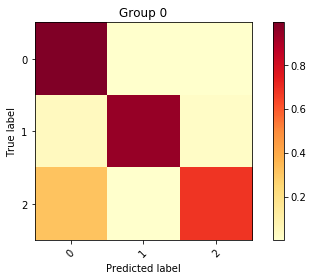

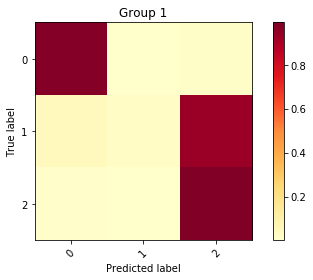

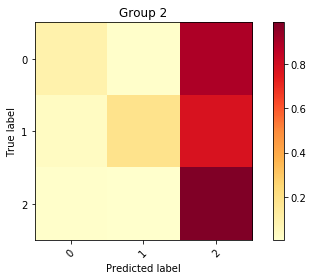

Inertia: 0.3565015471036346
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.4499       899   0.309464     0.873135   0.149125       0.897652   0.809702    0.720391      0.720391
   1         1  0.348645     697   0.144021     0.663803   1.31673        0.546121   0.495704    0.648352      0.648352
   2         2  0.201455     402   0.348241     0.423376   1.35363        0.325574   0.135063    0.333333      0.333333
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [25]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


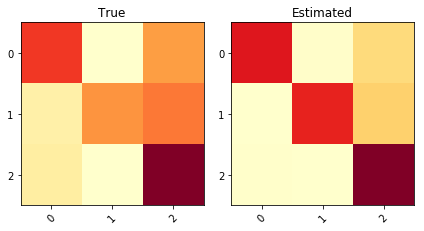

KL divergence: 0.2348	Pearson Correlation between diagonals: 0.9614


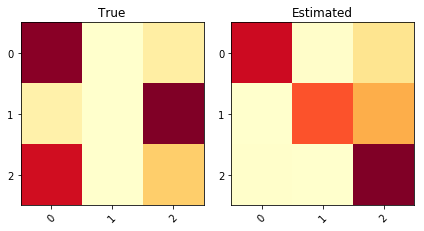

KL divergence: 1.3918	Pearson Correlation between diagonals: 0.3209


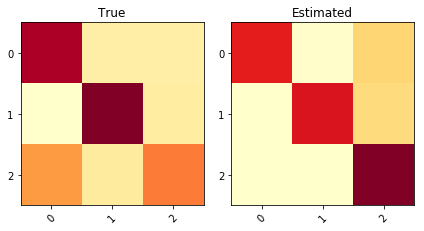

KL divergence: 0.7059	Pearson Correlation between diagonals: -0.9483


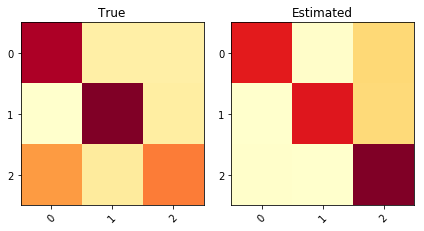

KL divergence: 0.7015	Pearson Correlation between diagonals: -0.9683


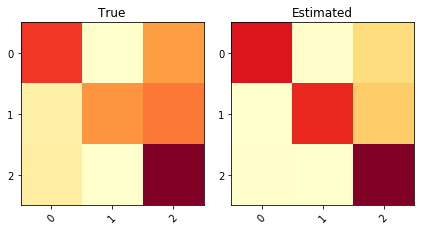

KL divergence: 0.2301	Pearson Correlation between diagonals: 0.9772


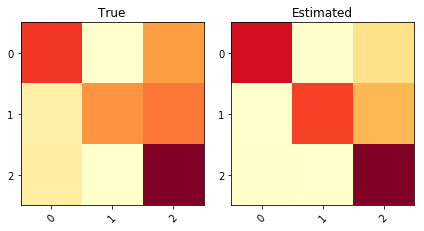

KL divergence: 0.2154	Pearson Correlation between diagonals: 0.9987


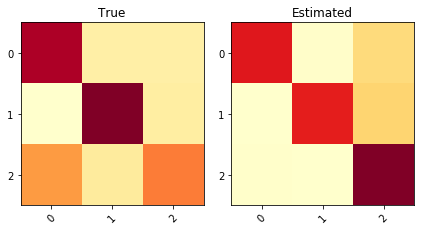

KL divergence: 0.6946	Pearson Correlation between diagonals: -0.9927


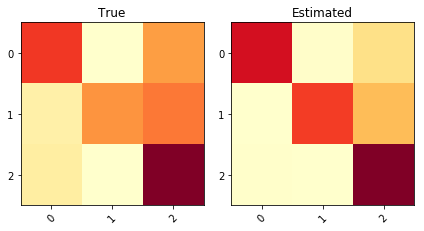

KL divergence: 0.2175	Pearson Correlation between diagonals: 1.0000


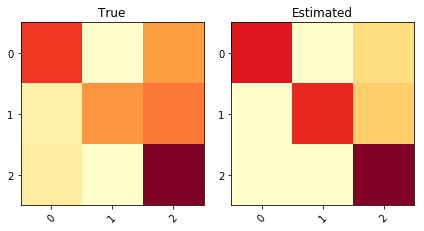

KL divergence: 0.2318	Pearson Correlation between diagonals: 0.9719


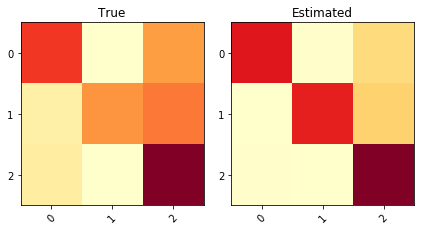

KL divergence: 0.2370	Pearson Correlation between diagonals: 0.9526


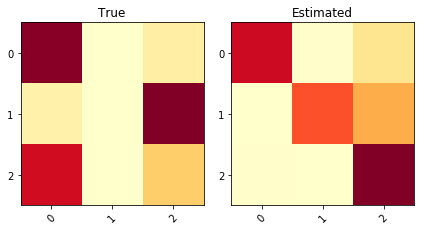

KL divergence: 1.3941	Pearson Correlation between diagonals: 0.3164


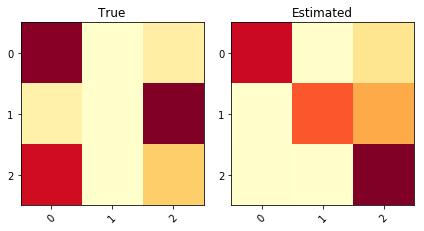

KL divergence: 1.3802	Pearson Correlation between diagonals: 0.3438


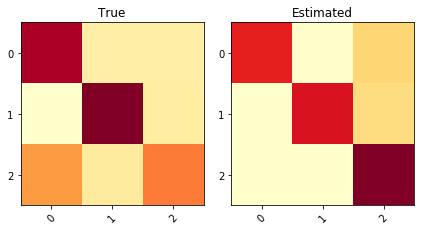

KL divergence: 0.7092	Pearson Correlation between diagonals: -0.9320


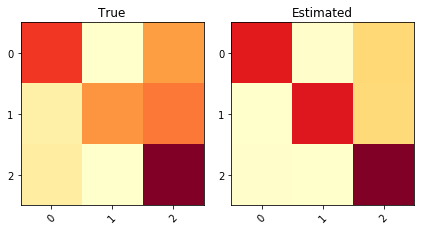

KL divergence: 0.2494	Pearson Correlation between diagonals: 0.8984


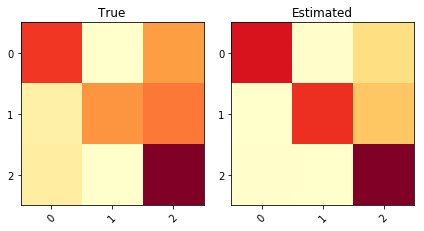

KL divergence: 0.2242	Pearson Correlation between diagonals: 0.9924
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.89825       0.89825   0.577248   0.084947            0.328995        0.151221
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.630185                0.786908
====  =======================  ======================
Test


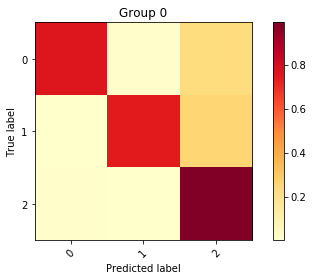

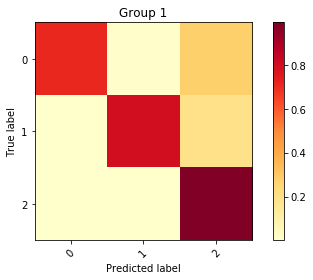

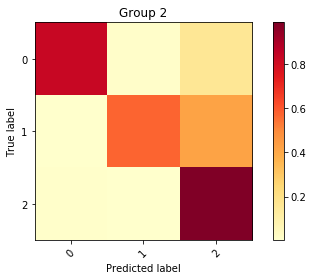

Inertia: 0.007227727444842458
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.29693      593   0.411571     0.831426   0.193448       0.907181   0.498093    0.715507      0.715507
   1         1  0.419679     839   0.398301     0.836052   0.18867        0.909572   0.502719    0.805861      0.805861
   2         2  0.283392     566   0.418249     0.798585   0.249393       0.883511   0.465252    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [103]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


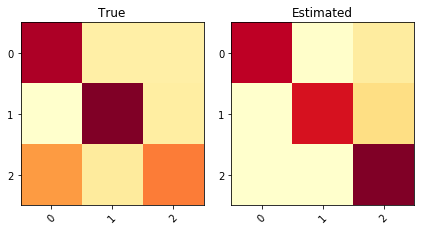

KL divergence: 0.8500	Pearson Correlation between diagonals: -0.9831


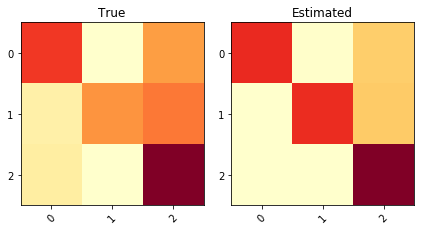

KL divergence: 0.2617	Pearson Correlation between diagonals: 0.9333


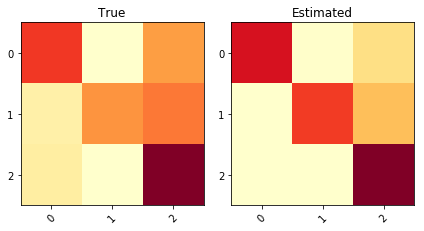

KL divergence: 0.2636	Pearson Correlation between diagonals: 0.9996


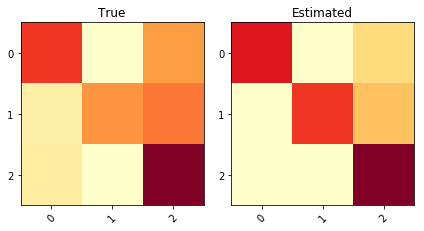

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9898


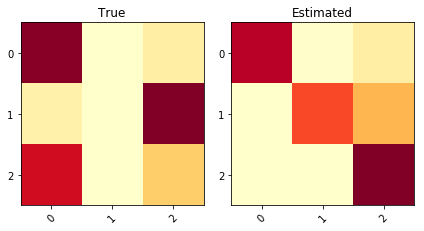

KL divergence: 1.7264	Pearson Correlation between diagonals: 0.4592


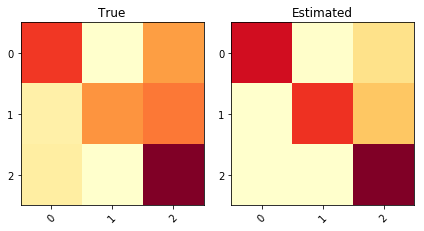

KL divergence: 0.2774	Pearson Correlation between diagonals: 0.9998


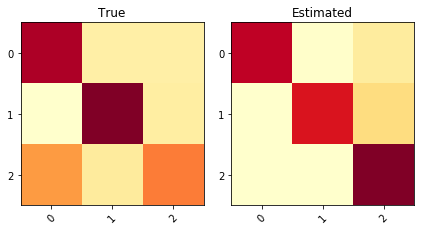

KL divergence: 0.8532	Pearson Correlation between diagonals: -0.9805


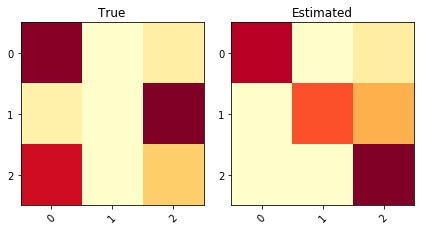

KL divergence: 1.7082	Pearson Correlation between diagonals: 0.4647


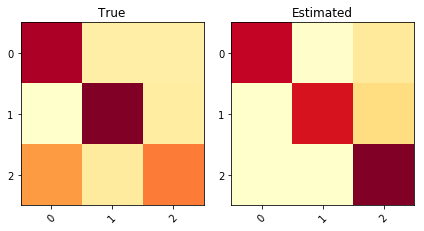

KL divergence: 0.8563	Pearson Correlation between diagonals: -0.9934


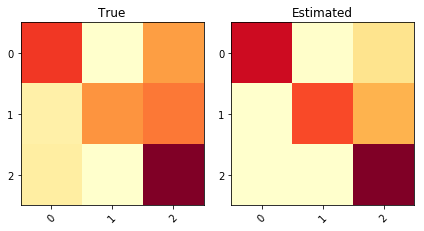

KL divergence: 0.2637	Pearson Correlation between diagonals: 0.9915


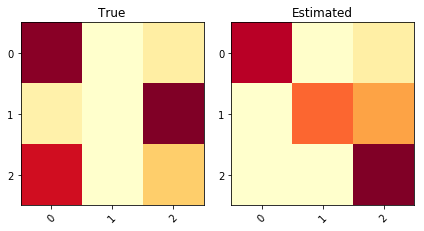

KL divergence: 1.6701	Pearson Correlation between diagonals: 0.5103


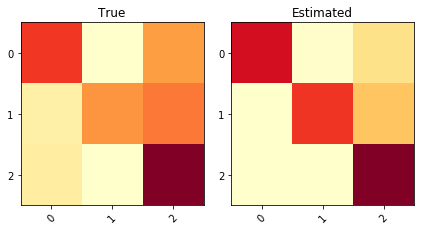

KL divergence: 0.2729	Pearson Correlation between diagonals: 0.9997


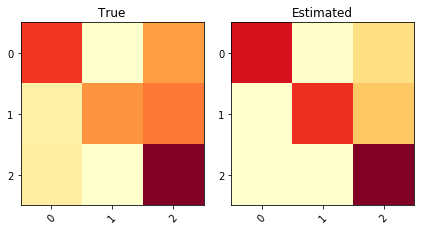

KL divergence: 0.2725	Pearson Correlation between diagonals: 0.9956


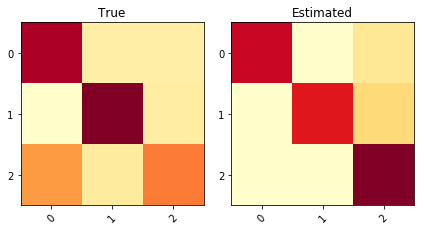

KL divergence: 0.8648	Pearson Correlation between diagonals: -0.9929


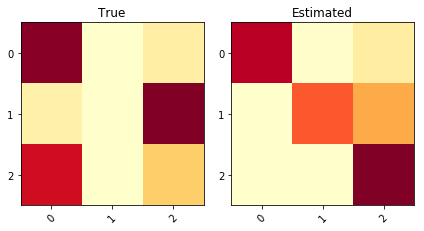

KL divergence: 1.6948	Pearson Correlation between diagonals: 0.4763
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.904762      0.904762   0.690459  0.0839284            0.382153        0.135871
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.647914                0.774467
====  =======================  ======================
Test


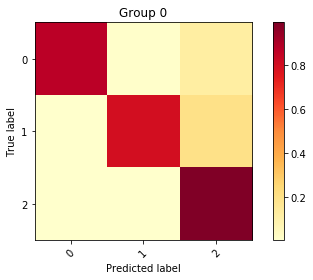

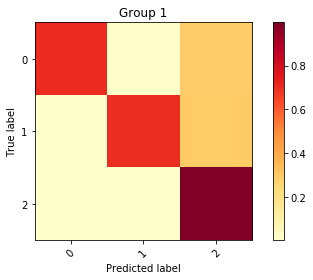

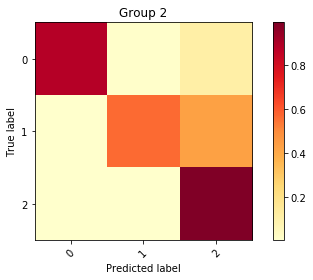

Inertia: 0.010683130628118912
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.308806     617   0.312619     0.890473   0.120068       0.941563   0.55714     0.837607      0.837607
   1         1  0.394164     788   0.422838     0.802826   0.233353       0.889142   0.469493    0.705739      0.705739
   2         2  0.29703      594   0.36901      0.815786   0.231375       0.892482   0.482453    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [104]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T$ = 10000, $T_{data}$ = 20 )

In [20]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8070818070818071


*** Soft-Majority (Train with softMV) ***
Train


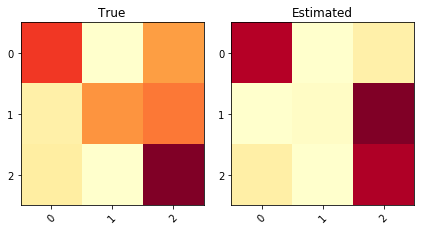

JS divergence: 0.0820	KL divergence: 0.1817


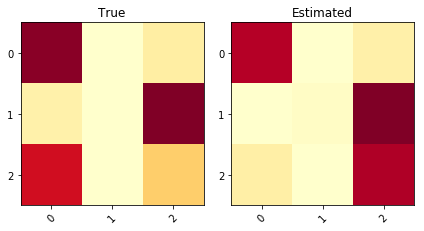

JS divergence: 0.1975	KL divergence: 0.4278


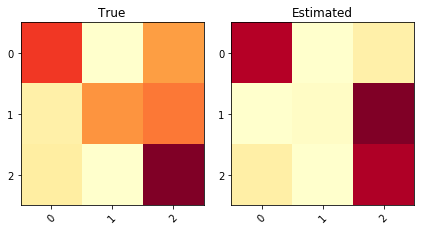

JS divergence: 0.0820	KL divergence: 0.1817


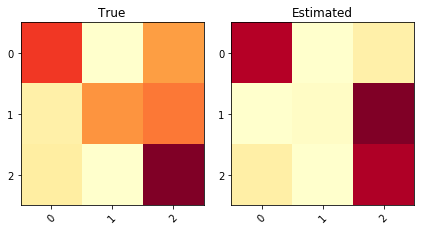

JS divergence: 0.0820	KL divergence: 0.1817


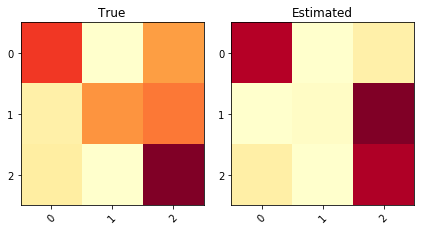

JS divergence: 0.0820	KL divergence: 0.1817


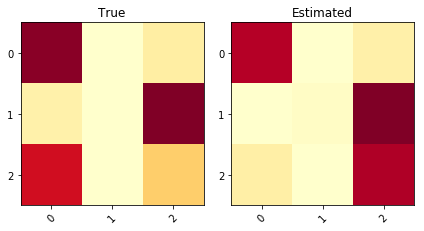

JS divergence: 0.1975	KL divergence: 0.4278


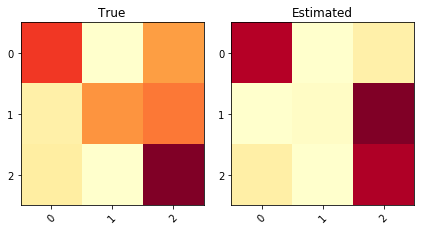

JS divergence: 0.0820	KL divergence: 0.1817


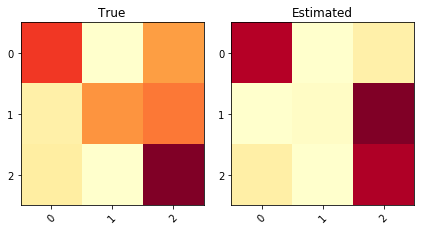

JS divergence: 0.0820	KL divergence: 0.1817


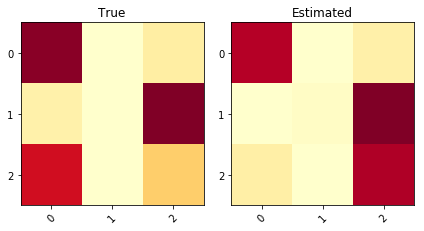

JS divergence: 0.1975	KL divergence: 0.4278


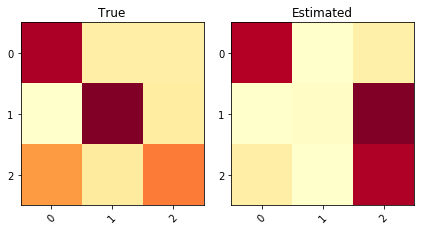

JS divergence: 0.2130	KL divergence: 1.3479


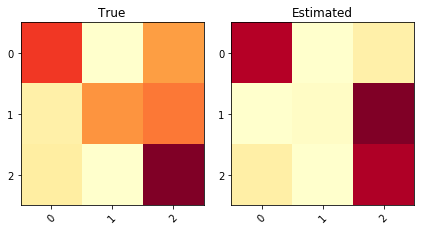

JS divergence: 0.0820	KL divergence: 0.1817


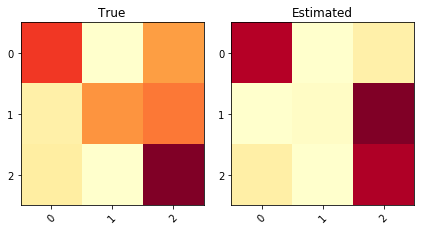

JS divergence: 0.0820	KL divergence: 0.1817


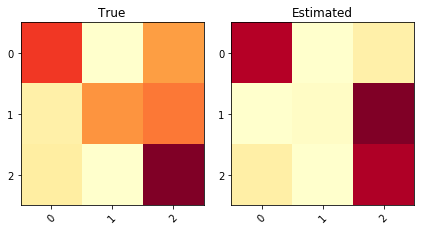

JS divergence: 0.0820	KL divergence: 0.1817


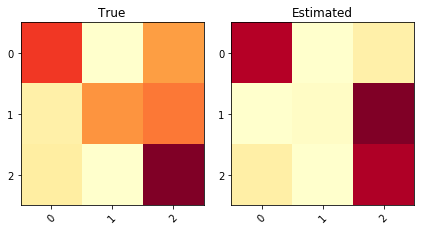

JS divergence: 0.0820	KL divergence: 0.1817


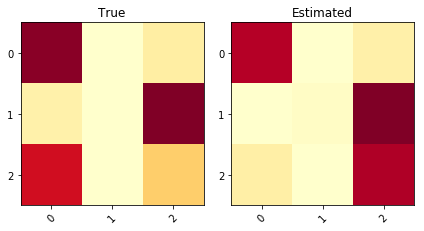

JS divergence: 0.1975	KL divergence: 0.4278
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.599105      0.599105   0.515963   0.136899    0.512335    0.136548
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.615385      0.615385
====  ======  ==========  ============


In [21]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


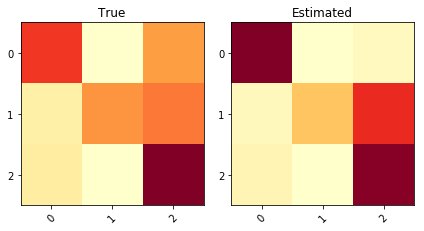

JS divergence: 0.0820	KL divergence: 0.1817


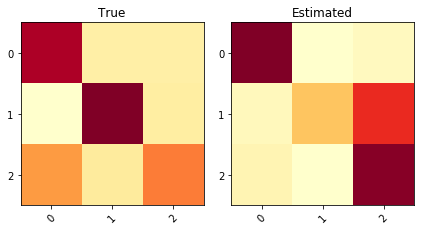

JS divergence: 0.2130	KL divergence: 1.3479


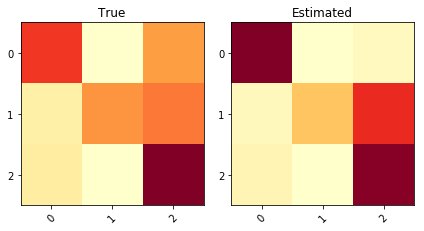

JS divergence: 0.0820	KL divergence: 0.1817


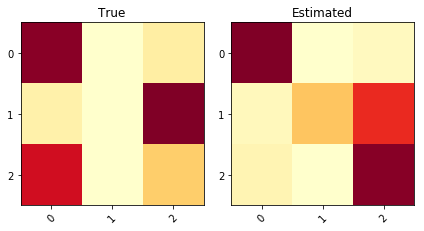

JS divergence: 0.1975	KL divergence: 0.4278


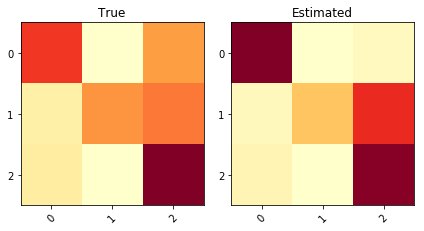

JS divergence: 0.0820	KL divergence: 0.1817


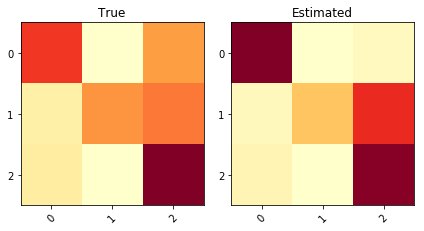

JS divergence: 0.0820	KL divergence: 0.1817


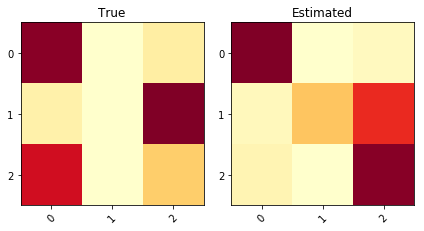

JS divergence: 0.1975	KL divergence: 0.4278


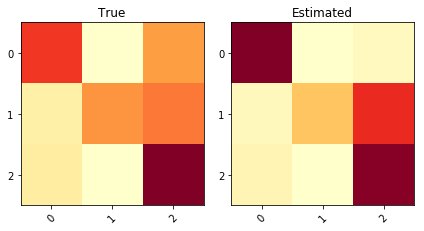

JS divergence: 0.0820	KL divergence: 0.1817


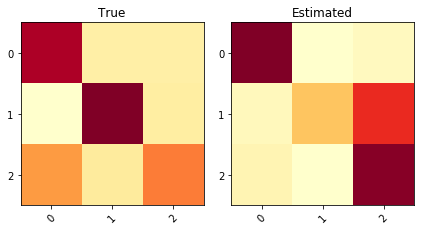

JS divergence: 0.2130	KL divergence: 1.3479


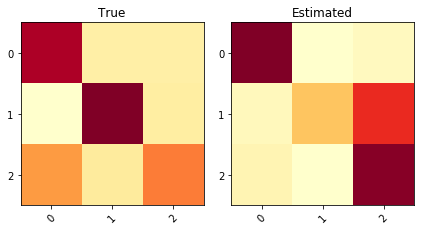

JS divergence: 0.2130	KL divergence: 1.3479


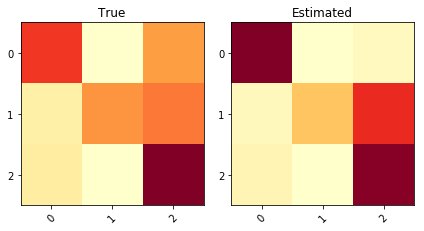

JS divergence: 0.0820	KL divergence: 0.1817


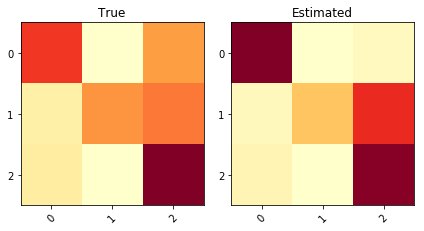

JS divergence: 0.0820	KL divergence: 0.1817


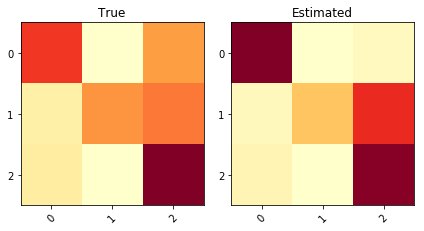

JS divergence: 0.0820	KL divergence: 0.1817


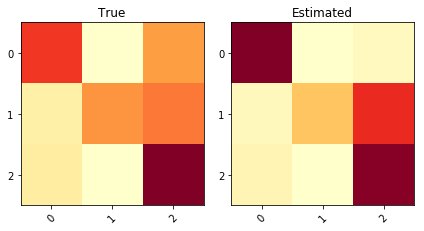

JS divergence: 0.0820	KL divergence: 0.1817


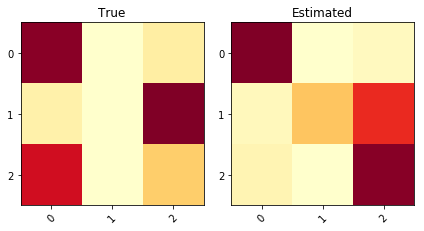

JS divergence: 0.1975	KL divergence: 0.4278
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.726089      0.726089   0.515963   0.136899    0.512335    0.136548
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.73138       0.73138
====  ======  ==========  ============


In [22]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


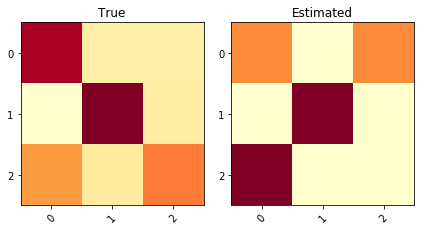

JS divergence: 0.2103	KL divergence: 3.8502


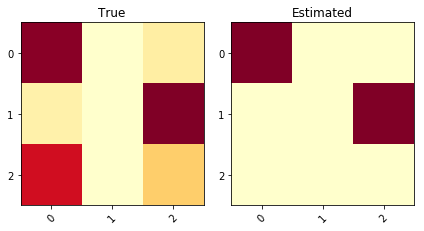

JS divergence: 1.1376	KL divergence: 0.9934


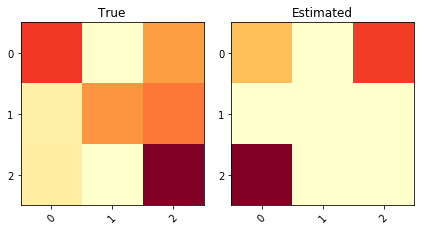

JS divergence: 0.3224	KL divergence: 4.8017


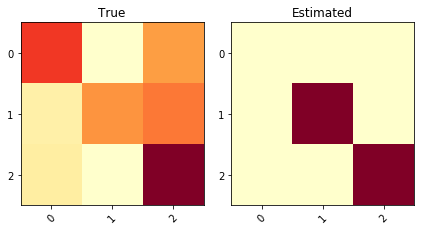

JS divergence: 1.2301	KL divergence: 3.3801


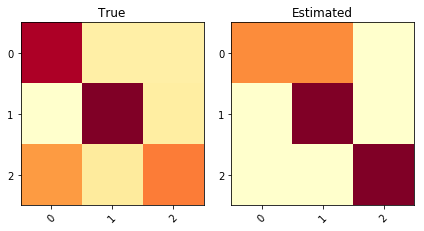

JS divergence: 0.1895	KL divergence: 3.4593


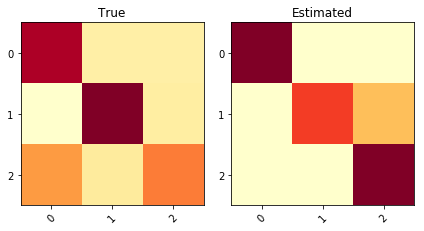

JS divergence: 0.1634	KL divergence: 3.3559


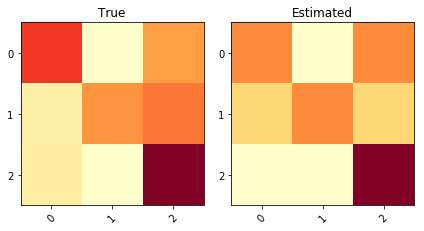

JS divergence: 0.0402	KL divergence: 0.5141


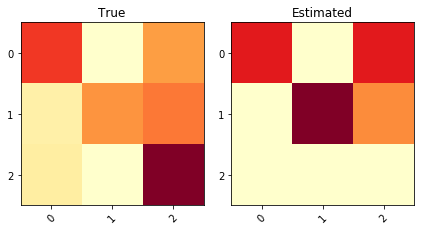

JS divergence: 1.1894	KL divergence: 0.6758


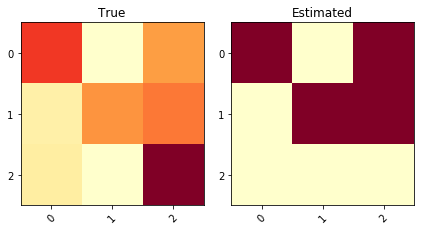

JS divergence: 1.1803	KL divergence: 0.6509


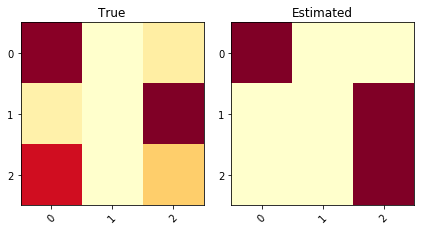

JS divergence: 0.2126	KL divergence: 4.6099


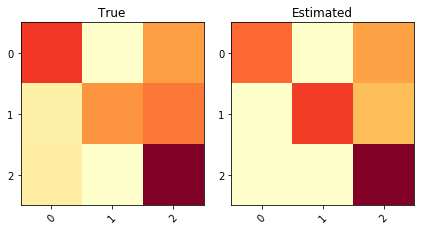

JS divergence: 0.0437	KL divergence: 0.8682


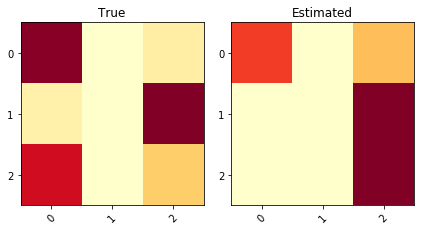

JS divergence: 0.2134	KL divergence: 4.2038


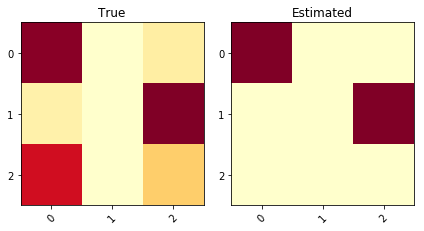

JS divergence: 1.1376	KL divergence: 0.9934


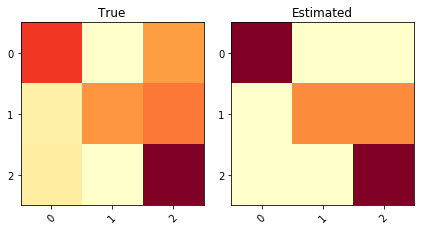

JS divergence: 0.1114	KL divergence: 2.7299


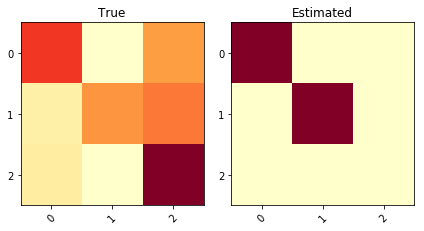

JS divergence: 1.3635	KL divergence: 4.9252
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.924705      0.924705    3.17568    0.53102     3.08039    0.403374
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.936508      0.936508
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


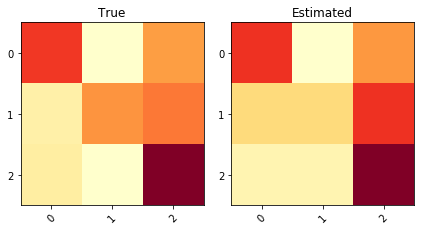

JS divergence: 0.0704	KL divergence: 0.1562


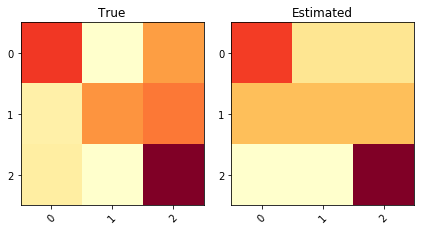

JS divergence: 0.1026	KL divergence: 0.2252


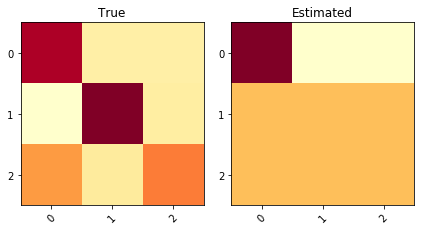

JS divergence: 0.1449	KL divergence: 0.3637


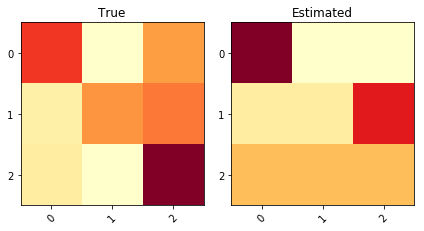

JS divergence: 0.1583	KL divergence: 0.3839


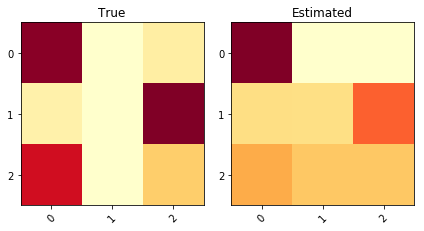

JS divergence: 0.1543	KL divergence: 0.3472


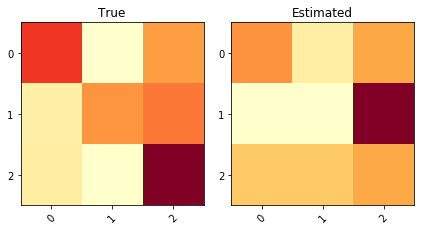

JS divergence: 0.1551	KL divergence: 0.3823


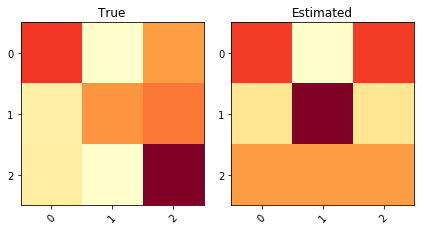

JS divergence: 0.1603	KL divergence: 0.3893


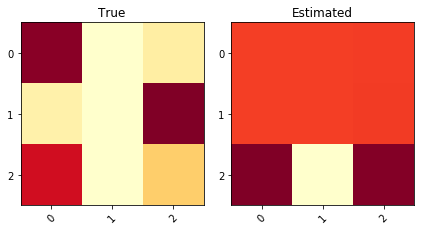

JS divergence: 0.2597	KL divergence: 0.6361


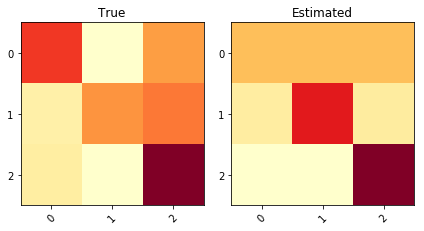

JS divergence: 0.1290	KL divergence: 0.2926


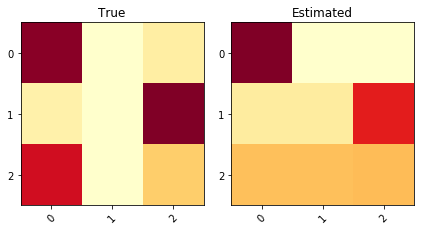

JS divergence: 0.1867	KL divergence: 0.4269


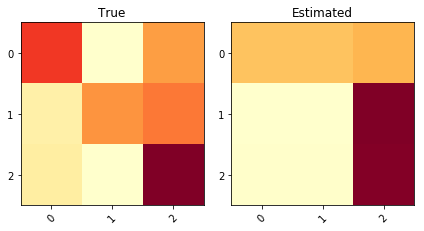

JS divergence: 0.1262	KL divergence: 0.2882


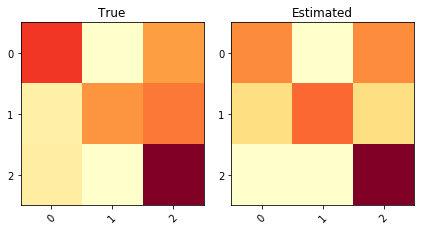

JS divergence: 0.1014	KL divergence: 0.2279


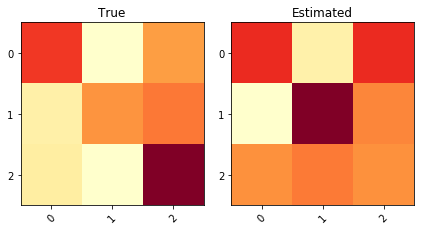

JS divergence: 0.1498	KL divergence: 0.3601


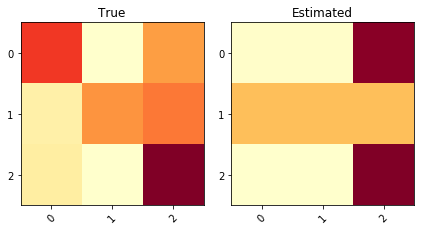

JS divergence: 0.1460	KL divergence: 0.3446


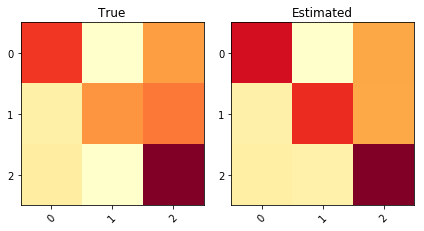

JS divergence: 0.0602	KL divergence: 0.1314
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.908425      0.908425   0.331395   0.138351    0.307953    0.128939     0.115309      0.123304
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.823897              0.795942               

In [24]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


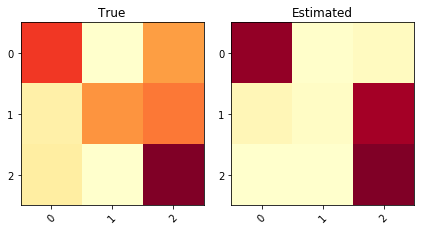

JS divergence: 0.1382	KL divergence: 0.6381


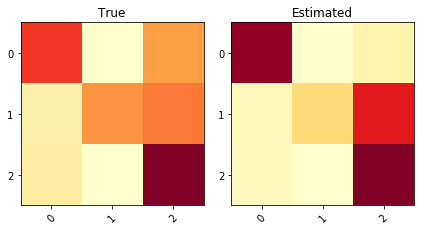

JS divergence: 0.0544	KL divergence: 0.1816


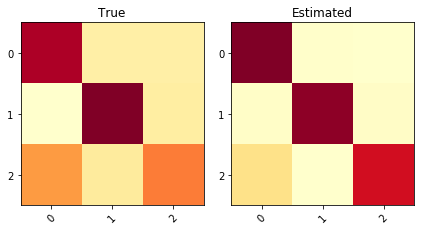

JS divergence: 0.0713	KL divergence: 0.3154


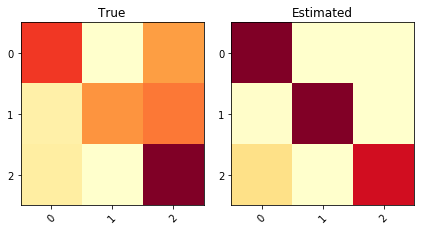

JS divergence: 0.1859	KL divergence: 1.1449


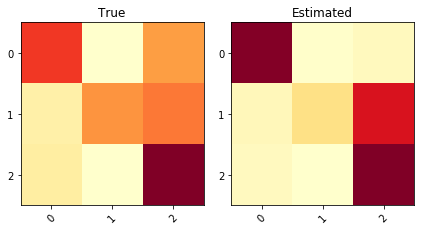

JS divergence: 0.0742	KL divergence: 0.2781


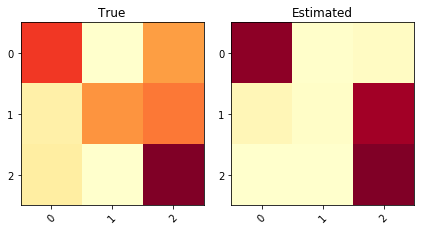

JS divergence: 0.1490	KL divergence: 0.7448


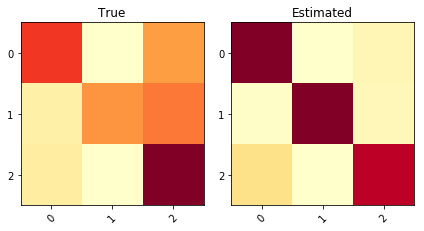

JS divergence: 0.1228	KL divergence: 0.4584


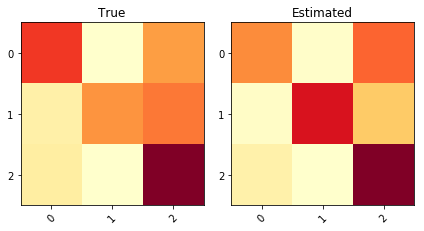

JS divergence: 0.0305	KL divergence: 0.0893


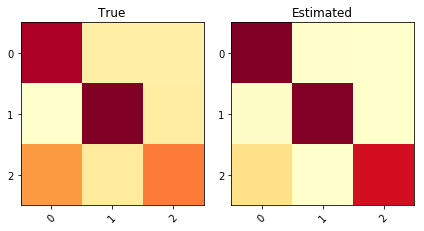

JS divergence: 0.0784	KL divergence: 0.3793


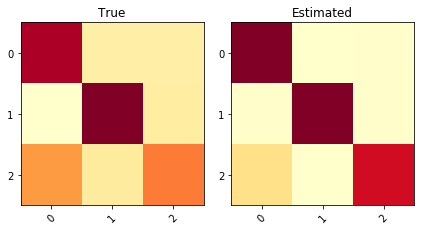

JS divergence: 0.0699	KL divergence: 0.2940


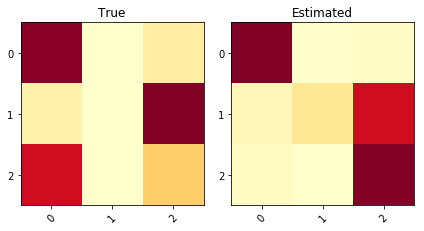

JS divergence: 0.1875	KL divergence: 0.7582


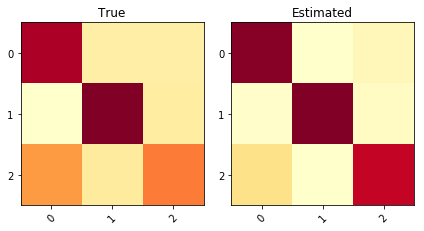

JS divergence: 0.0567	KL divergence: 0.2277


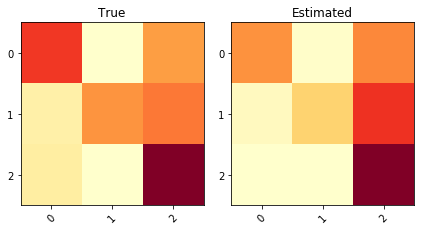

JS divergence: 0.0319	KL divergence: 0.1322


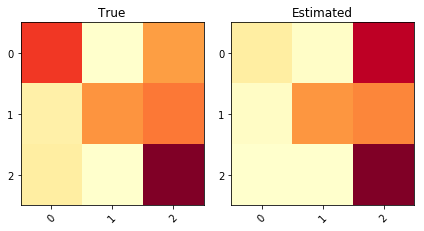

JS divergence: 0.0862	KL divergence: 0.3137


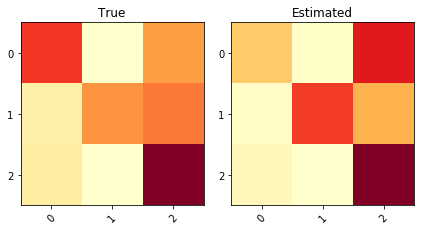

JS divergence: 0.0447	KL divergence: 0.1317
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.911681      0.911681   0.529978    0.11613    0.560983    0.118111     0.173505       0.17749
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.749202              0.594292               

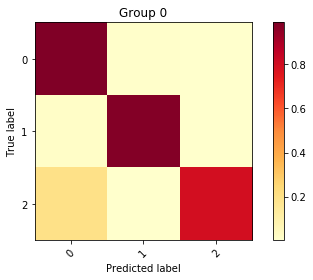

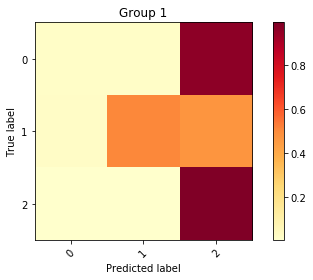

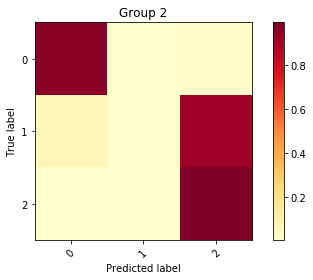

Inertia: 0.38083673390353273
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.399224    3957   0.228949     0.923131  0.0849029       0.940531   0.884696    0.758242      0.758242
   1         1  0.242535    2404   0.335548     0.506581  1.55844         0.40288    0.259871    0.34188       0.34188
   2         2  0.358241    3551   0.159925     0.659232  1.48429         0.533451   0.488848    0.638584      0.638584
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [25]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [26]:
prob_Gt

array([[0.  , 0.02, 0.98],
       [0.19, 0.07, 0.74],
       [0.98, 0.  , 0.02],
       ...,
       [0.02, 0.97, 0.  ],
       [1.  , 0.  , 0.  ],
       [0.78, 0.  , 0.22]])

In [ ]:
#maybe plot the conf with p(g) high entropy ?

*** Ours (1) multiples runs***
Train


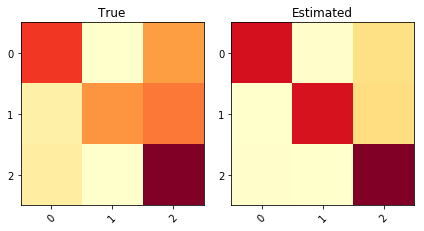

KL divergence: 0.2838	Pearson Correlation between diagonals: 0.9304


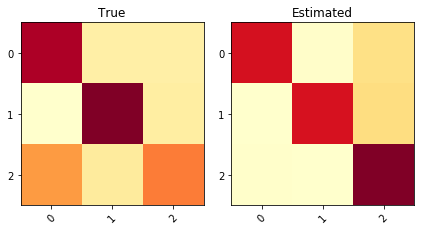

KL divergence: 0.6732	Pearson Correlation between diagonals: -0.9841


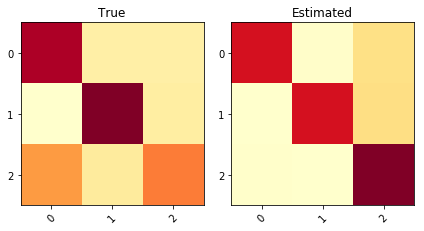

KL divergence: 0.6672	Pearson Correlation between diagonals: -0.9815


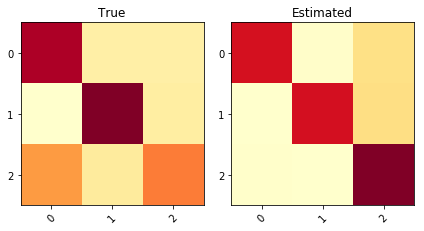

KL divergence: 0.6644	Pearson Correlation between diagonals: -0.9802


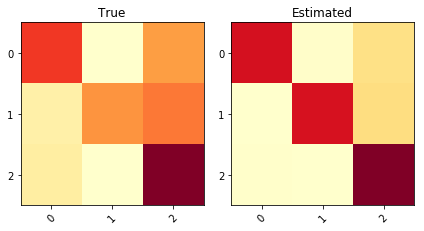

KL divergence: 0.2848	Pearson Correlation between diagonals: 0.9282


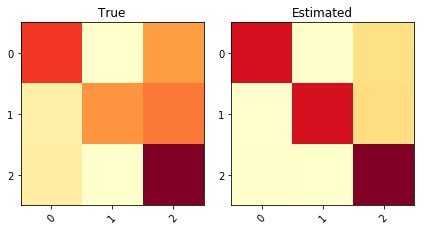

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9296


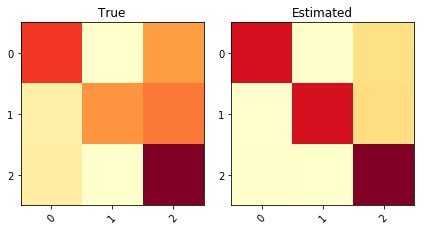

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9289


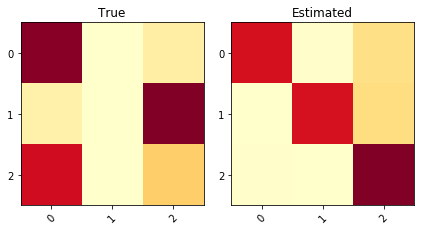

KL divergence: 1.6128	Pearson Correlation between diagonals: -0.2187


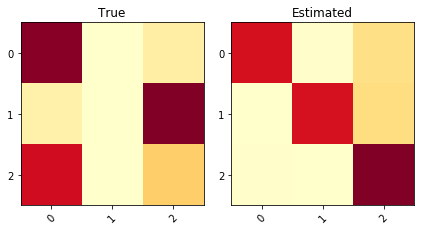

KL divergence: 1.6123	Pearson Correlation between diagonals: -0.2162


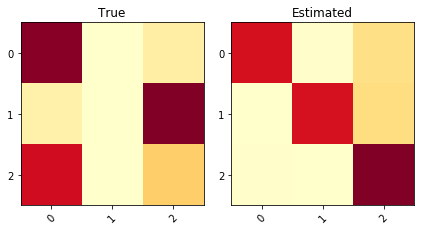

KL divergence: 1.6127	Pearson Correlation between diagonals: -0.2189


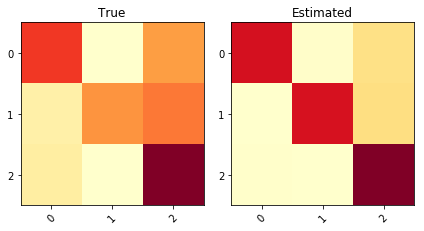

KL divergence: 0.2853	Pearson Correlation between diagonals: 0.9271


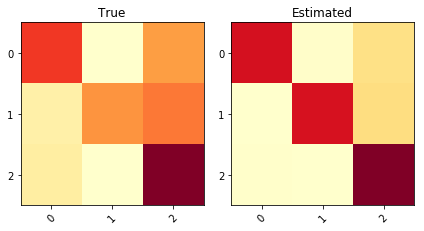

KL divergence: 0.2846	Pearson Correlation between diagonals: 0.9289


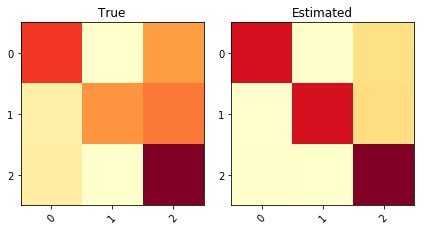

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9297


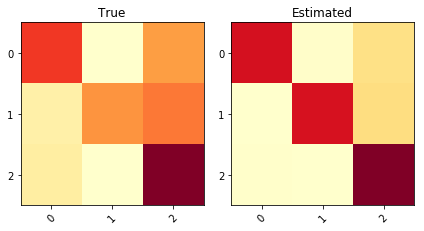

KL divergence: 0.2850	Pearson Correlation between diagonals: 0.9281


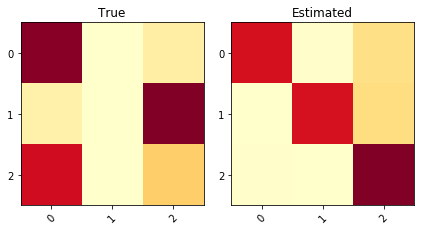

KL divergence: 1.6136	Pearson Correlation between diagonals: -0.2210
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.901099      0.901099   0.634778  0.0958811            0.227621        0.196777
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.601578                  0.8074
====  =======================  ======================
Test


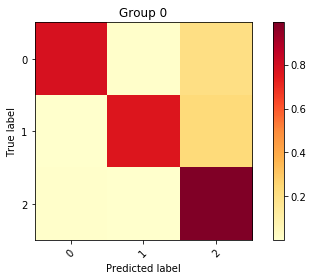

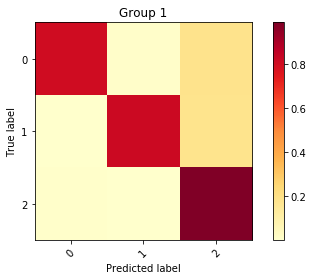

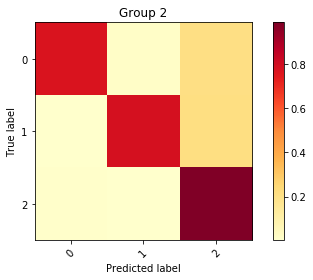

Inertia: 0.0006941696677434569
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.509769    5097   0.383405     0.847461   0.172483       0.91685    0.514128    0.664225      0.664225
   1         1  0.293071    2930   0.358103     0.871508   0.142037       0.931042   0.538174    0.714286      0.714286
   2         2  0.19716     1971   0.39276      0.850331   0.168667       0.918604   0.516998    0.684982      0.684982
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =====

In [28]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


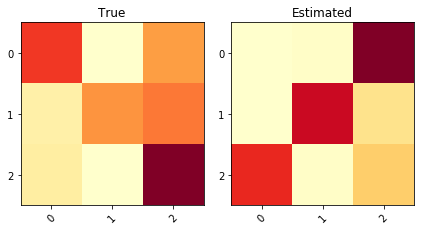

KL divergence: 1.7661	Pearson Correlation between diagonals: -0.5460


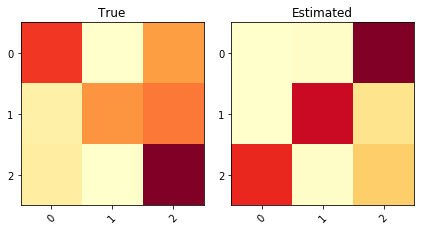

KL divergence: 1.7643	Pearson Correlation between diagonals: -0.5443


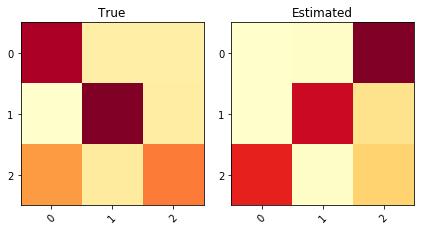

KL divergence: 2.0180	Pearson Correlation between diagonals: 0.3831


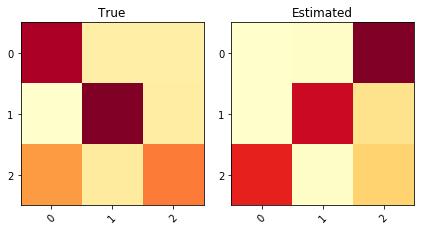

KL divergence: 2.0076	Pearson Correlation between diagonals: 0.3859


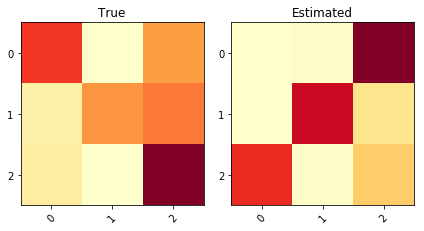

KL divergence: 1.7616	Pearson Correlation between diagonals: -0.5425


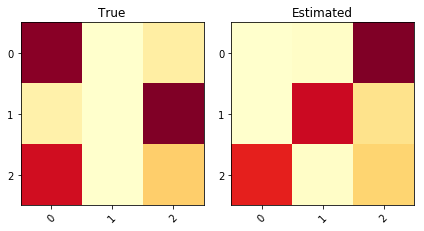

KL divergence: 2.7140	Pearson Correlation between diagonals: -0.9029


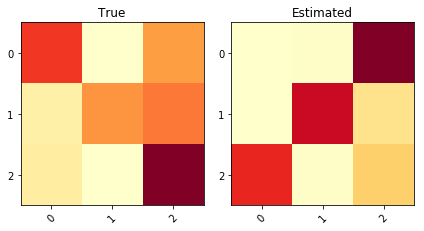

KL divergence: 1.7675	Pearson Correlation between diagonals: -0.5492


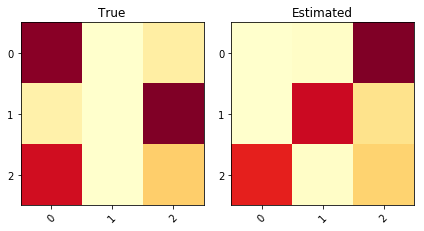

KL divergence: 2.7136	Pearson Correlation between diagonals: -0.9038


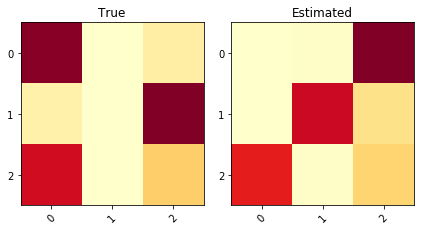

KL divergence: 2.7124	Pearson Correlation between diagonals: -0.9016


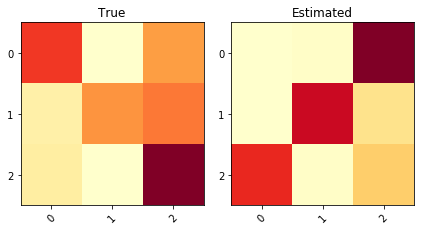

KL divergence: 1.7652	Pearson Correlation between diagonals: -0.5463


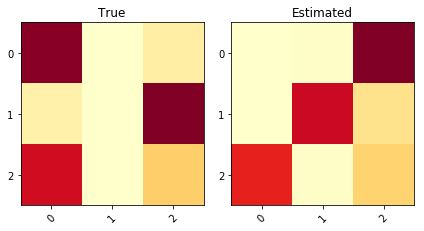

KL divergence: 2.7155	Pearson Correlation between diagonals: -0.9054


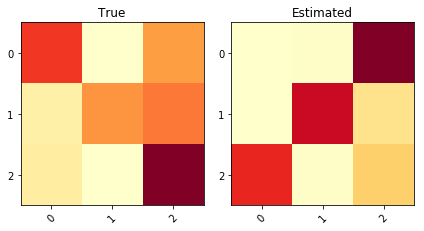

KL divergence: 1.7660	Pearson Correlation between diagonals: -0.5481


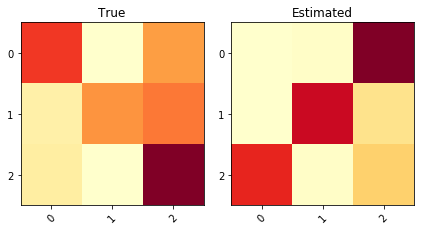

KL divergence: 1.7699	Pearson Correlation between diagonals: -0.5533


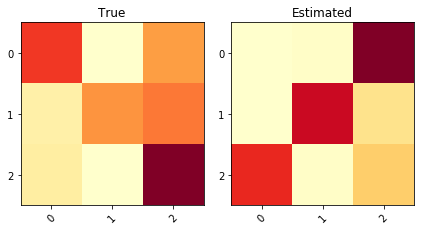

KL divergence: 1.7627	Pearson Correlation between diagonals: -0.5449


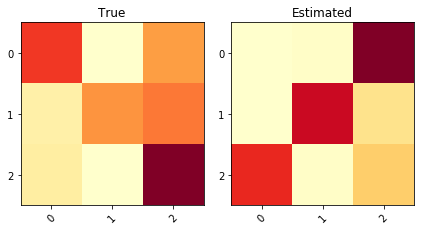

KL divergence: 1.7651	Pearson Correlation between diagonals: -0.5449
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.37851       0.37851    2.01078   0.219762            -0.38238        0.203455
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.599939                0.803456
====  =======================  ======================
Test


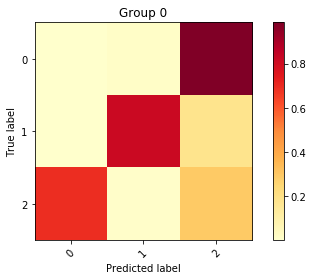

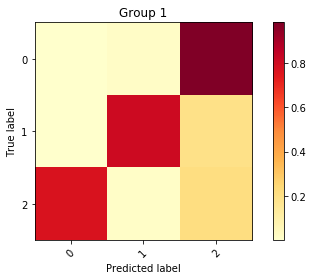

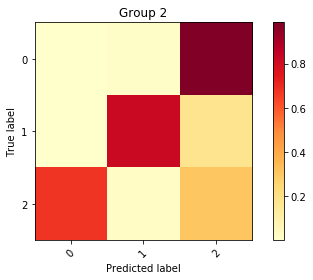

Inertia: 0.001275528554591195
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.502056    5020   0.402793     0.372082    3.05296       0.469439  0.0387491     0.67033       0.67033
   1         1  0.309751    3097   0.393764     0.340686    3.00726       0.436325  0.00735291    0.65812       0.65812
   2         2  0.188194    1881   0.417051     0.376822    2.72234       0.474936  0.0434882     0.671551      0.671551
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =

In [29]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 10 )

In [42]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6227106227106227


*** Soft-Majority (Train with softMV) ***
Train


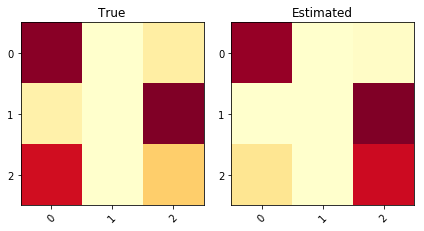

JS divergence: 0.1975	KL divergence: 0.4278


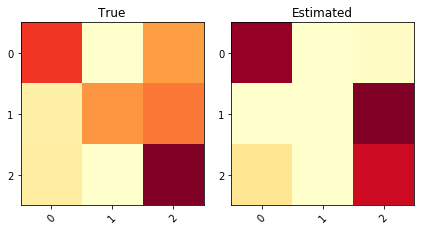

JS divergence: 0.0820	KL divergence: 0.1817


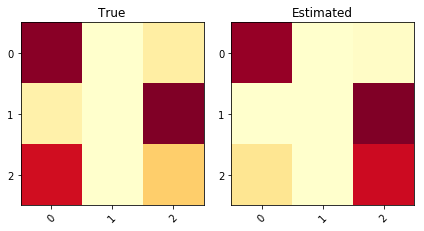

JS divergence: 0.1975	KL divergence: 0.4278


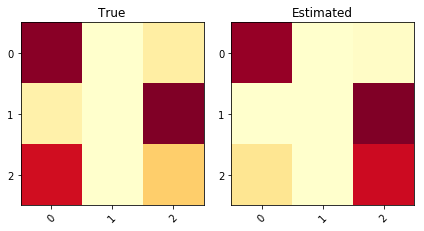

JS divergence: 0.1975	KL divergence: 0.4278


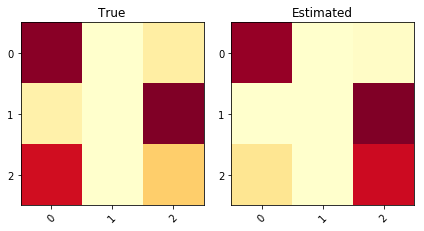

JS divergence: 0.1975	KL divergence: 0.4278


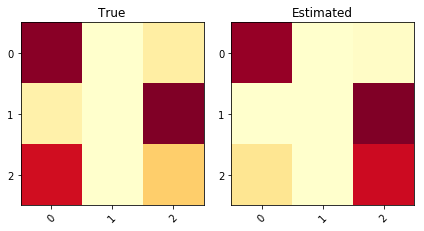

JS divergence: 0.1975	KL divergence: 0.4278


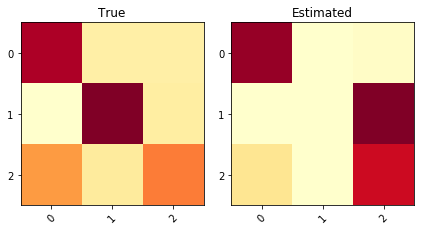

JS divergence: 0.2130	KL divergence: 1.3479


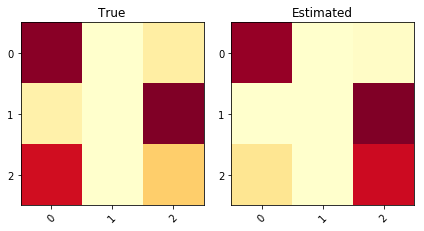

JS divergence: 0.1975	KL divergence: 0.4278


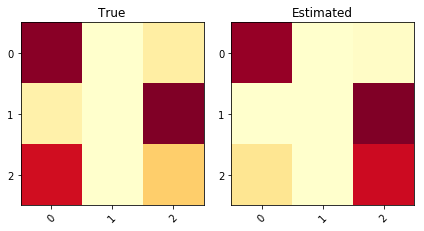

JS divergence: 0.1975	KL divergence: 0.4278


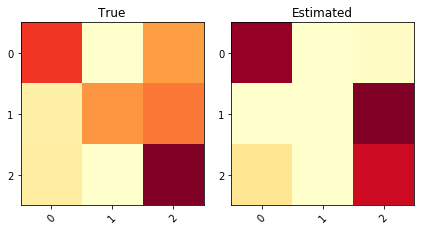

JS divergence: 0.0820	KL divergence: 0.1817


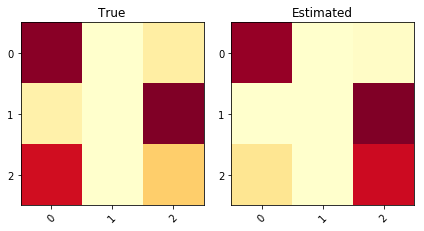

JS divergence: 0.1975	KL divergence: 0.4278


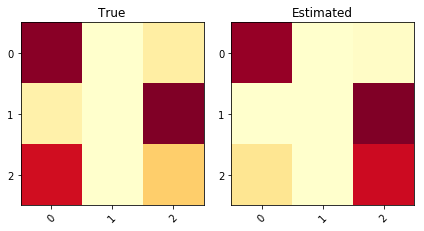

JS divergence: 0.1975	KL divergence: 0.4278


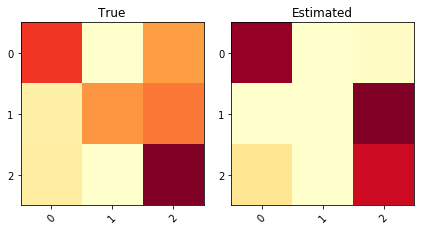

JS divergence: 0.0820	KL divergence: 0.1817


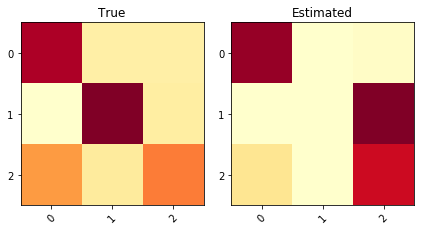

JS divergence: 0.2130	KL divergence: 1.3479


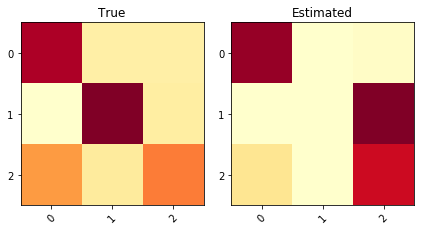

JS divergence: 0.2130	KL divergence: 1.3479
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.599105      0.599105    0.56421   0.159955
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.622711      0.622711
====  ======  ==========  ============


In [43]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


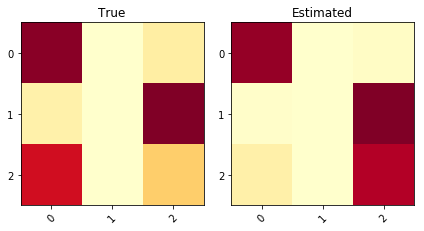

JS divergence: 0.1273	KL divergence: 0.2927


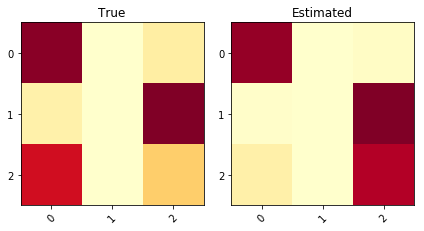

JS divergence: 0.1273	KL divergence: 0.2927


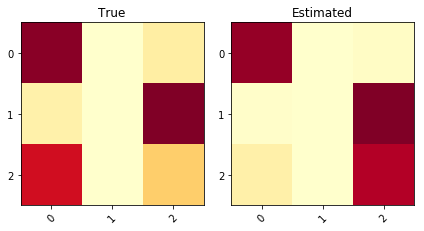

JS divergence: 0.1273	KL divergence: 0.2927


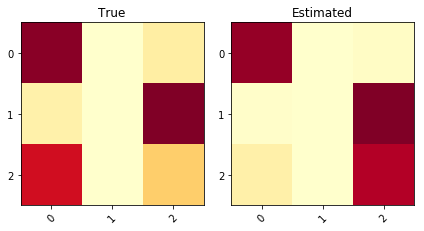

JS divergence: 0.1273	KL divergence: 0.2927


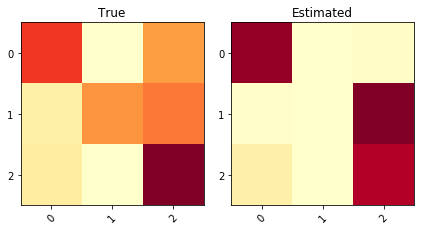

JS divergence: 0.1737	KL divergence: 2.3243


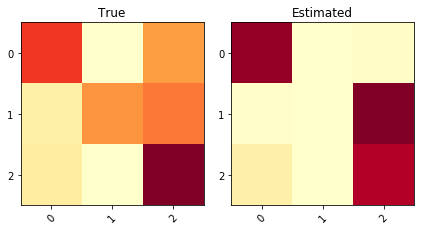

JS divergence: 0.1737	KL divergence: 2.3243


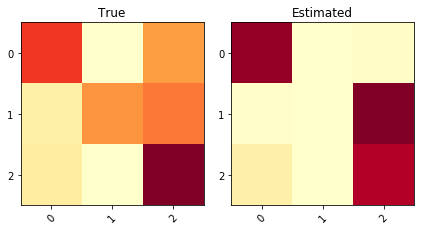

JS divergence: 0.1737	KL divergence: 2.3243


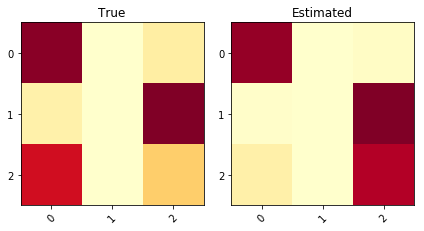

JS divergence: 0.1273	KL divergence: 0.2927


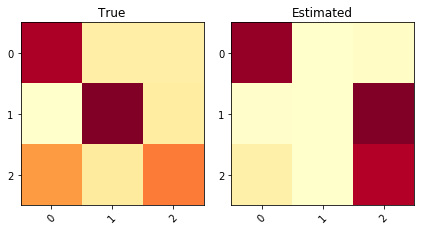

JS divergence: 0.3808	KL divergence: 6.0199


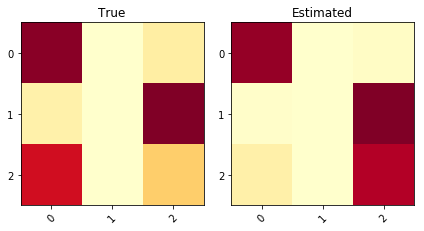

JS divergence: 0.1273	KL divergence: 0.2927


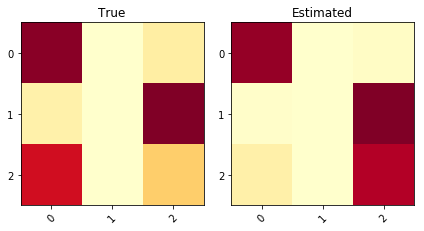

JS divergence: 0.1273	KL divergence: 0.2927


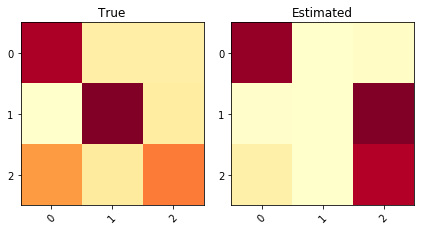

JS divergence: 0.3808	KL divergence: 6.0199


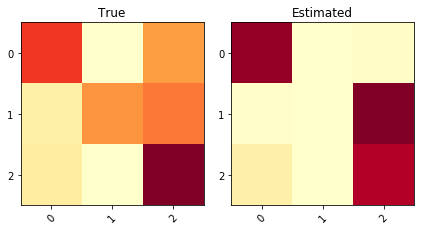

JS divergence: 0.1737	KL divergence: 2.3243


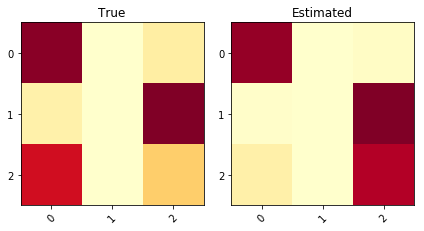

JS divergence: 0.1273	KL divergence: 0.2927


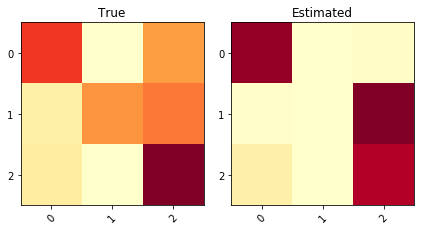

JS divergence: 0.1737	KL divergence: 2.3243
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.619455      0.619455    2.41745   0.205771
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.644689      0.644689
====  ======  ==========  ============


In [44]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


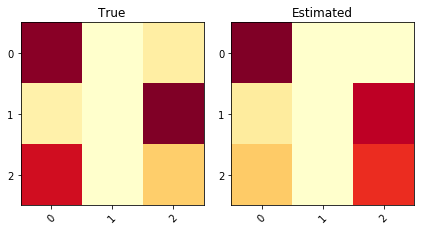

JS divergence: 0.0691	KL divergence: 0.5063


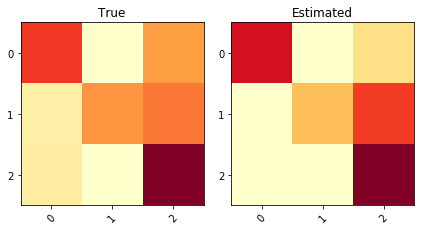

JS divergence: 0.0491	KL divergence: 0.8859


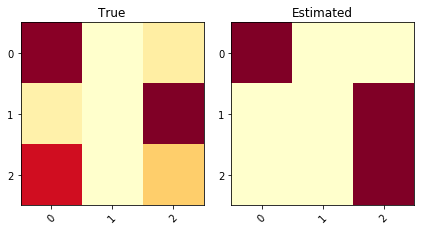

JS divergence: 0.2126	KL divergence: 4.6099


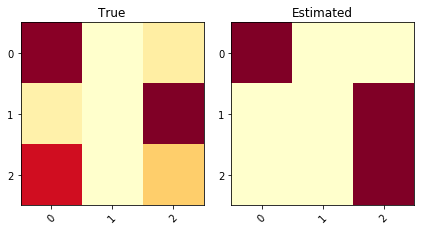

JS divergence: 0.2126	KL divergence: 4.6099


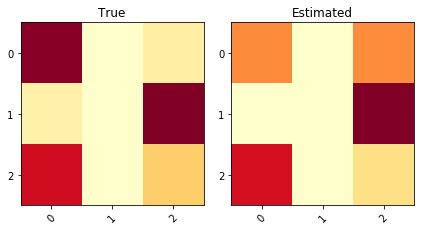

JS divergence: 0.0631	KL divergence: 0.4864


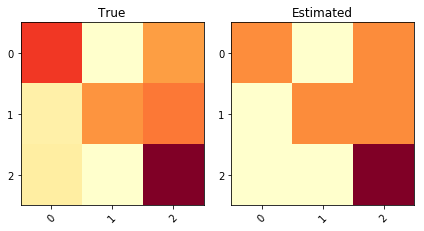

JS divergence: 0.0371	KL divergence: 0.8504


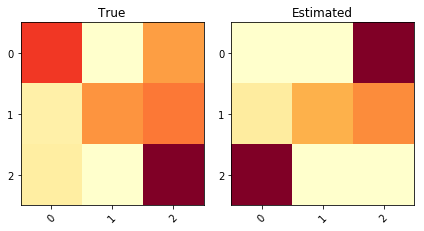

JS divergence: 0.3849	KL divergence: 7.7364


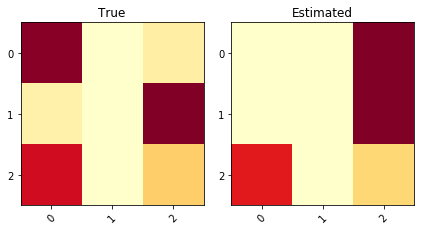

JS divergence: 0.2646	KL divergence: 5.0595


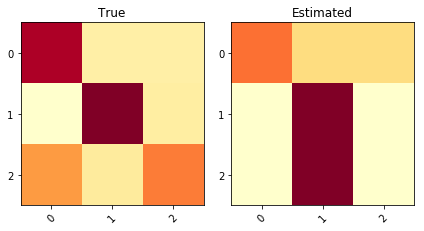

JS divergence: 0.2775	KL divergence: 4.8971


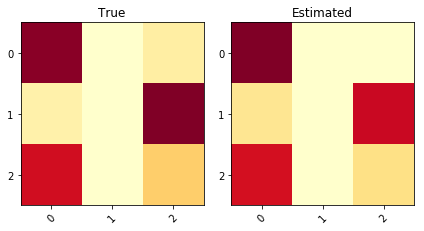

JS divergence: 0.0229	KL divergence: 0.4657


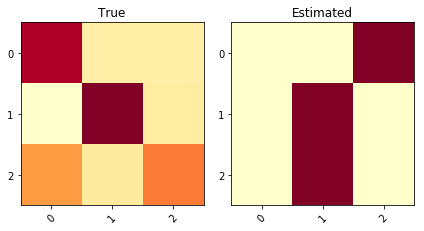

JS divergence: 0.5147	KL divergence: 9.3699


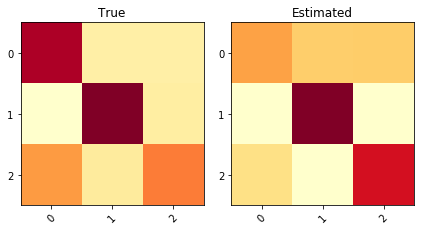

JS divergence: 0.0953	KL divergence: 1.1335


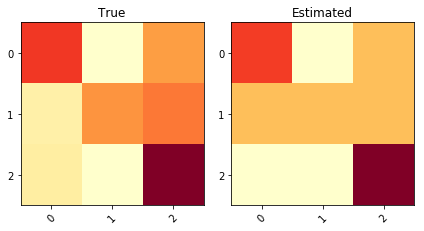

JS divergence: 0.0415	KL divergence: 0.5111


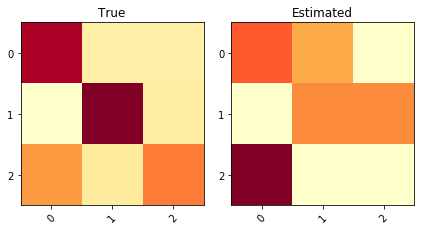

JS divergence: 0.2223	KL divergence: 3.4740


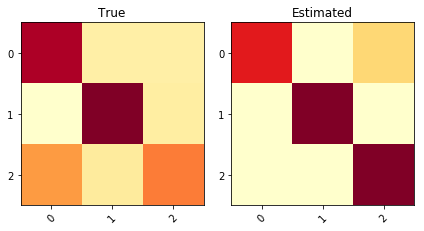

JS divergence: 0.1533	KL divergence: 3.3719
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.674807      0.674807    2.09928   0.139405
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.692308      0.692308
====  ======  ==========  ============


In [45]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


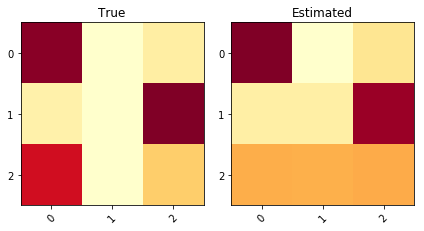

JS divergence: 0.1344	KL divergence: 0.3037


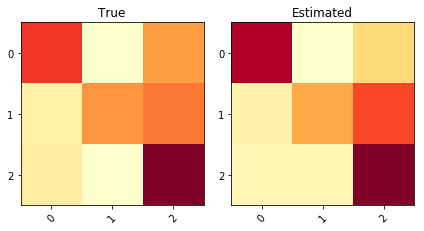

JS divergence: 0.0603	KL divergence: 0.1308


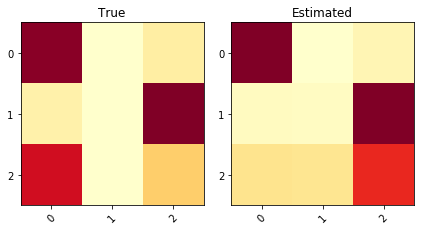

JS divergence: 0.1439	KL divergence: 0.3507


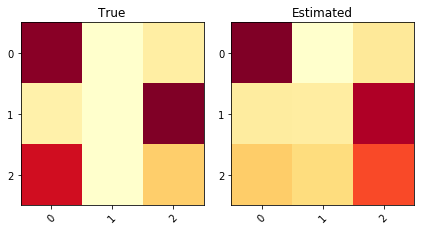

JS divergence: 0.1317	KL divergence: 0.3142


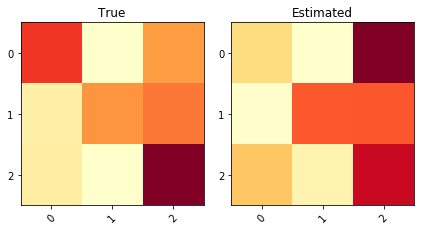

JS divergence: 0.0915	KL divergence: 0.2294


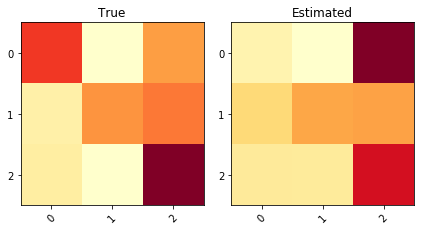

JS divergence: 0.1146	KL divergence: 0.3240


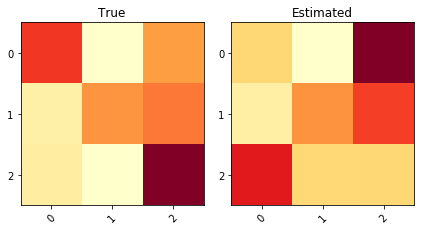

JS divergence: 0.1712	KL divergence: 0.4542


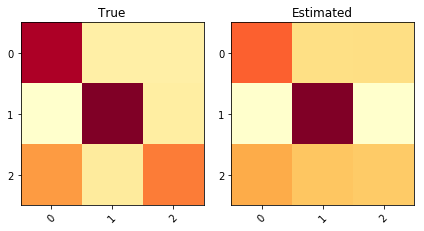

JS divergence: 0.0656	KL divergence: 0.1590


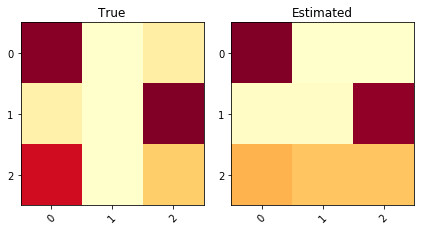

JS divergence: 0.1143	KL divergence: 0.2516


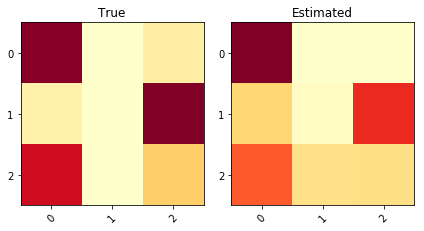

JS divergence: 0.1168	KL divergence: 0.2553


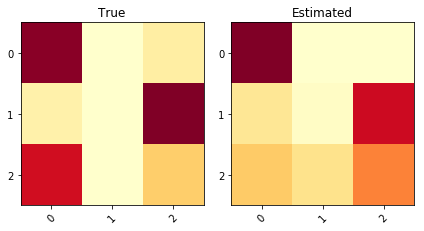

JS divergence: 0.1083	KL divergence: 0.2557


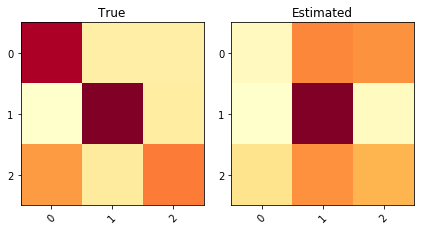

JS divergence: 0.1645	KL divergence: 0.4656


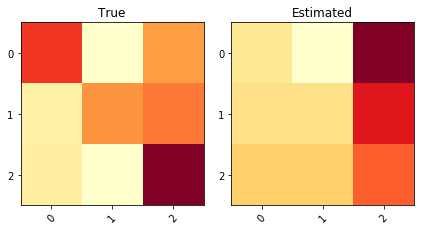

JS divergence: 0.1408	KL divergence: 0.3650


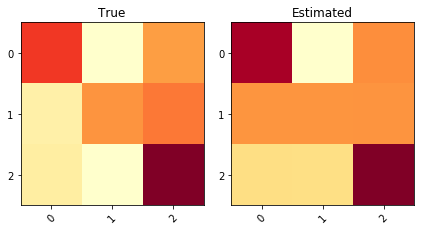

JS divergence: 0.0877	KL divergence: 0.1963


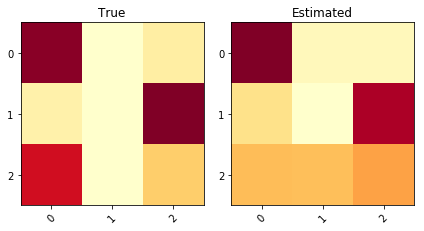

JS divergence: 0.1346	KL divergence: 0.3079
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.657306      0.657306   0.265789   0.111109    0.256232     0.10712     0.126173      0.124531
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.747943                0.751687
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ====== 

In [46]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


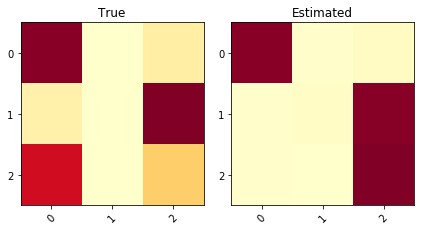

JS divergence: 0.1836	KL divergence: 0.9536


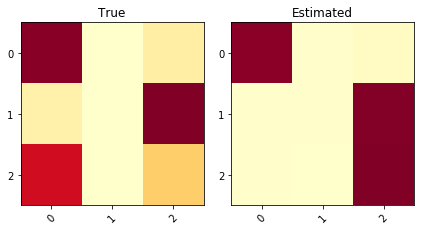

JS divergence: 0.1852	KL divergence: 1.0272


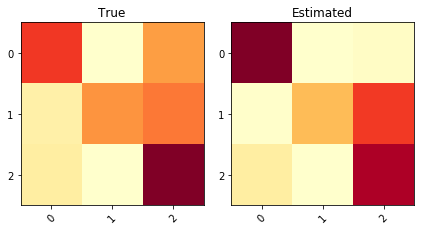

JS divergence: 0.0730	KL divergence: 0.3278


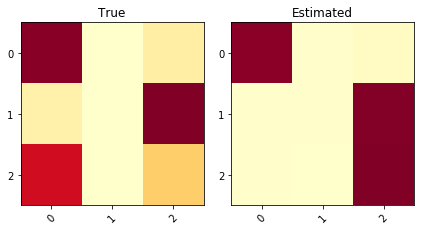

JS divergence: 0.1852	KL divergence: 1.0256


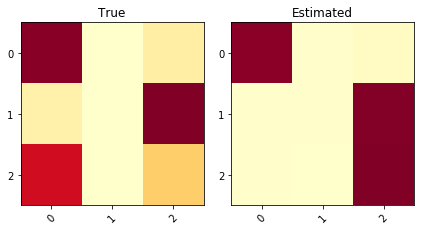

JS divergence: 0.1848	KL divergence: 1.0077


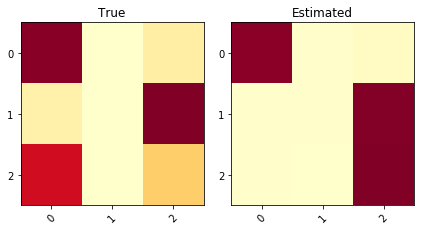

JS divergence: 0.1849	KL divergence: 1.0141


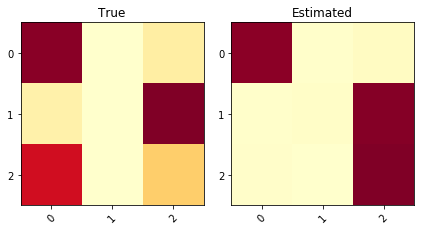

JS divergence: 0.1842	KL divergence: 0.9820


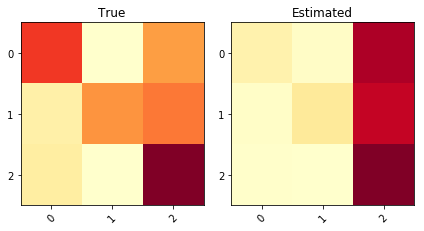

JS divergence: 0.1236	KL divergence: 0.4272


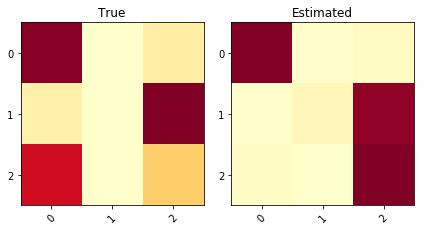

JS divergence: 0.1796	KL divergence: 0.8116


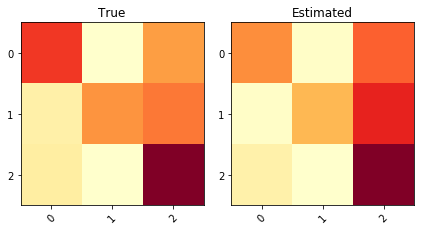

JS divergence: 0.0211	KL divergence: 0.0628


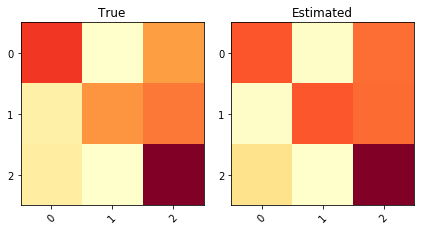

JS divergence: 0.0149	KL divergence: 0.0460


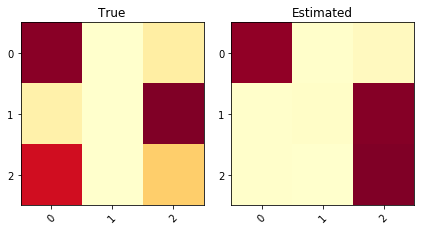

JS divergence: 0.1830	KL divergence: 0.9894


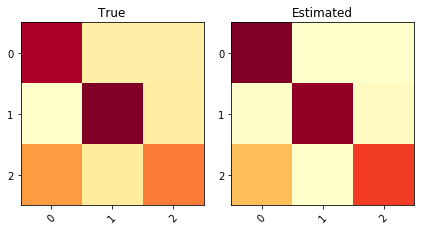

JS divergence: 0.0534	KL divergence: 0.2608


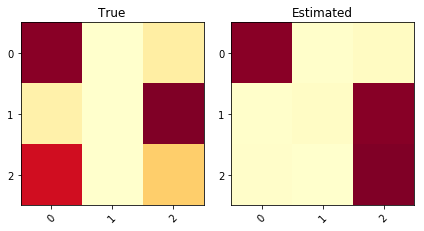

JS divergence: 0.1830	KL divergence: 0.9312


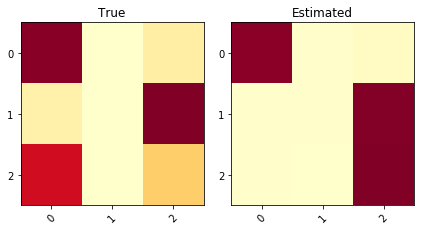

JS divergence: 0.1849	KL divergence: 1.0114
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.828246      0.828246   0.591227   0.126859      0.6007    0.127351     0.170099      0.170312
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.68612                0.672571
====  =======================  ======================
Test


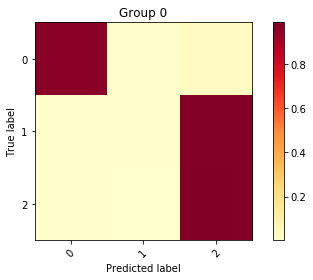

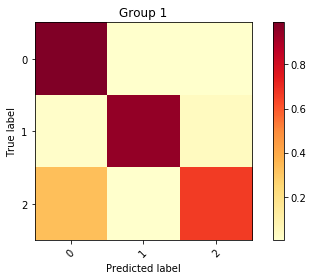

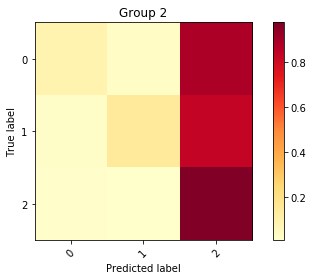

Inertia: 0.35404606122296894
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.399149     798   0.125511     0.653697   1.49741        0.529042   0.480545    0.605617      0.605617
   1         1  0.455877     911   0.315372     0.868432   0.156533       0.893004   0.802648    0.660562      0.660562
   2         2  0.144974     289   0.353014     0.404574   1.4494         0.292575   0.106861    0.333333      0.333333
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [47]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 7) configuration: Manny annot v1 + soft ($T$ = 2000, $T_{max}$ = 10 )

In [21]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7822547822547823


*** Soft-Majority (Train with softMV) ***
Train


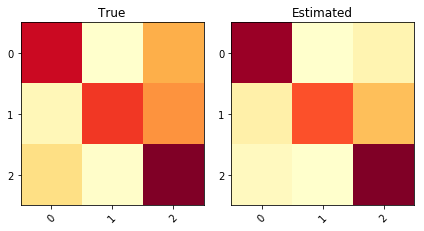

JS divergence: 0.1260	KL divergence: 0.3539


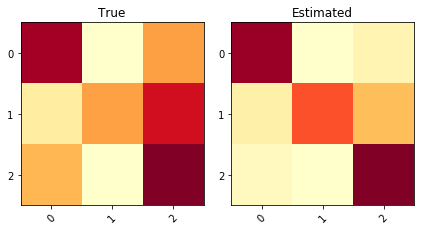

JS divergence: 0.1298	KL divergence: 0.2647


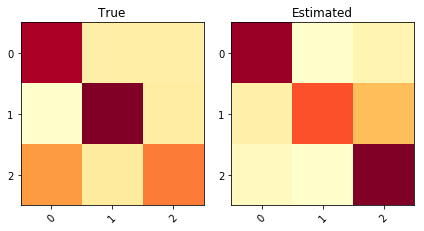

JS divergence: 0.2090	KL divergence: 0.8315


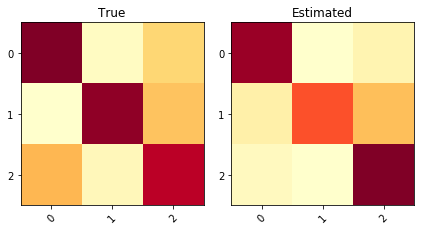

JS divergence: 0.1348	KL divergence: 0.5132


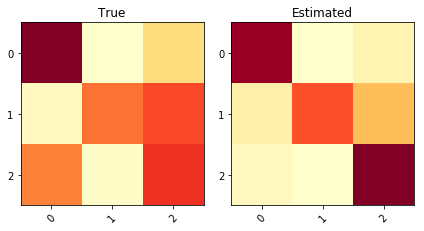

JS divergence: 0.1151	KL divergence: 0.3568


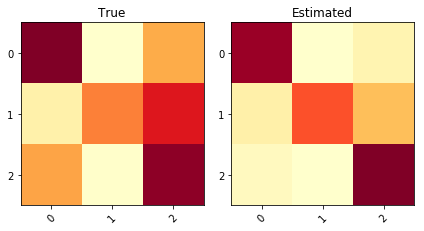

JS divergence: 0.1164	KL divergence: 0.2805


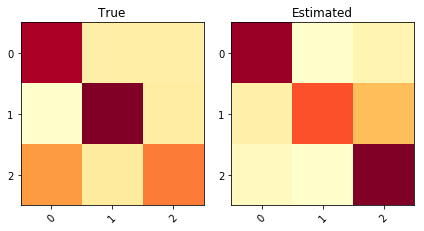

JS divergence: 0.2090	KL divergence: 0.8315


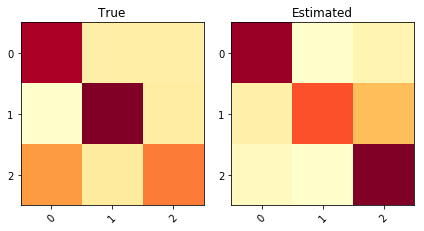

JS divergence: 0.2090	KL divergence: 0.8315


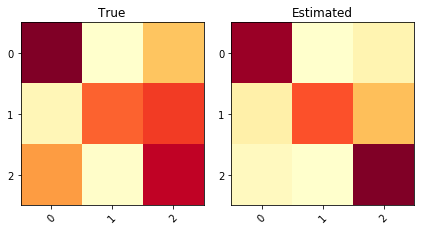

JS divergence: 0.1122	KL divergence: 0.3187


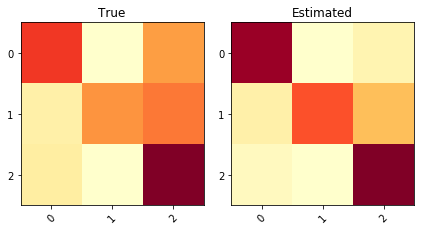

JS divergence: 0.1525	KL divergence: 0.3169


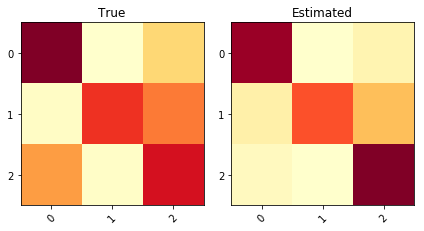

JS divergence: 0.1147	KL divergence: 0.3834


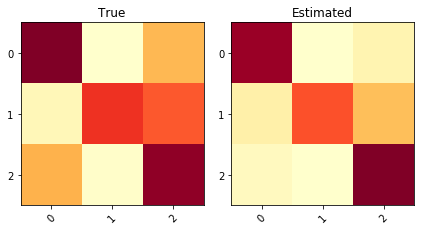

JS divergence: 0.1140	KL divergence: 0.3381


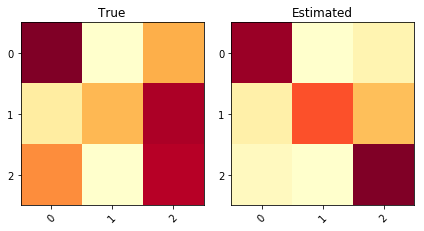

JS divergence: 0.1321	KL divergence: 0.2687


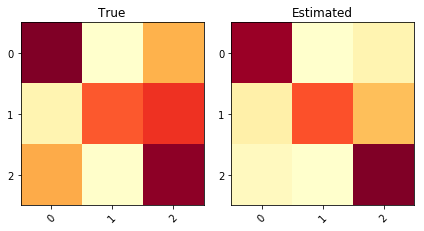

JS divergence: 0.1138	KL divergence: 0.3036


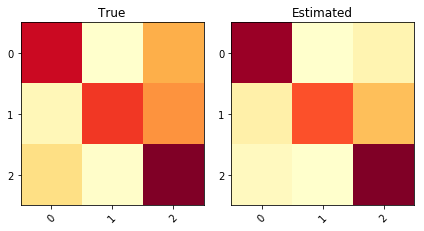

JS divergence: 0.1260	KL divergence: 0.3539
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.822548      0.822548   0.376285   0.137079    0.376021    0.136797
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.808303      0.808303
====  ======  ==========  ============


In [23]:
#soft mv one
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


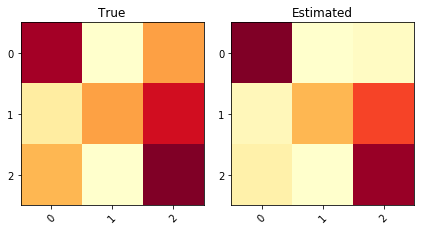

JS divergence: 0.0575	KL divergence: 0.1295


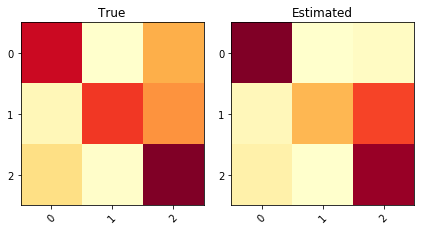

JS divergence: 0.0833	KL divergence: 0.3816


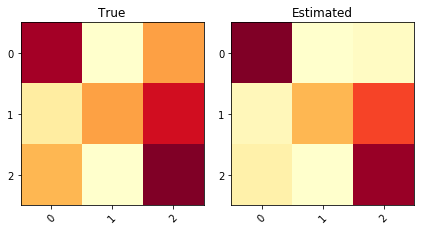

JS divergence: 0.0575	KL divergence: 0.1295


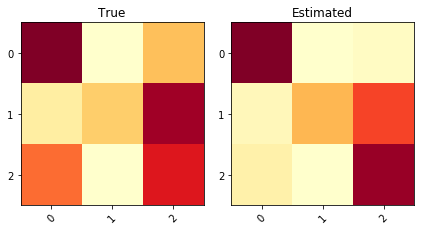

JS divergence: 0.0659	KL divergence: 0.1495


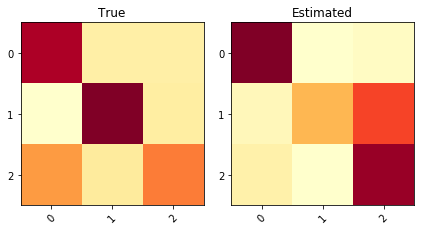

JS divergence: 0.2130	KL divergence: 1.3479


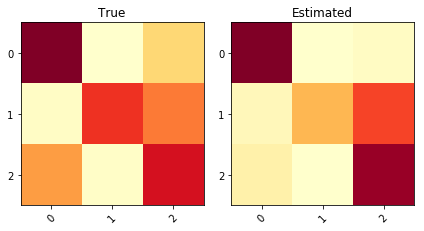

JS divergence: 0.0826	KL divergence: 0.5088


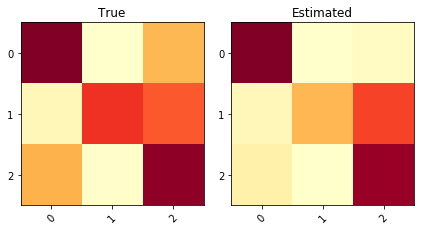

JS divergence: 0.0733	KL divergence: 0.3891


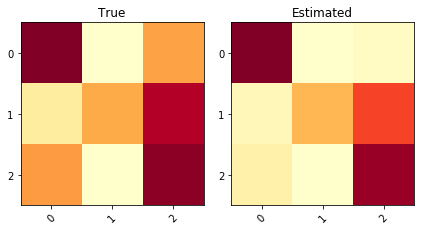

JS divergence: 0.0571	KL divergence: 0.1288


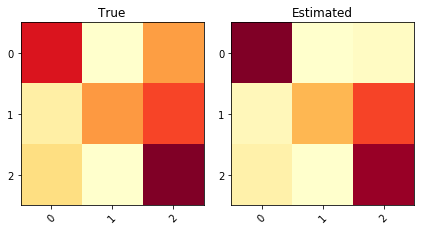

JS divergence: 0.0661	KL divergence: 0.1483


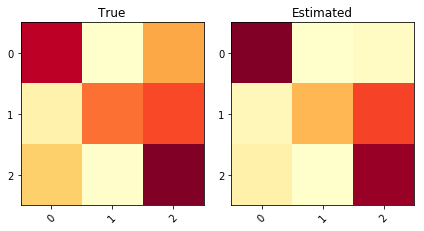

JS divergence: 0.0661	KL divergence: 0.2391


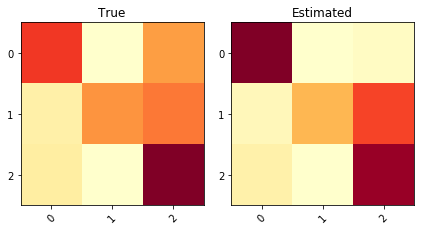

JS divergence: 0.0820	KL divergence: 0.1817


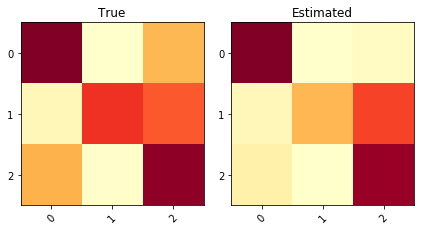

JS divergence: 0.0733	KL divergence: 0.3891


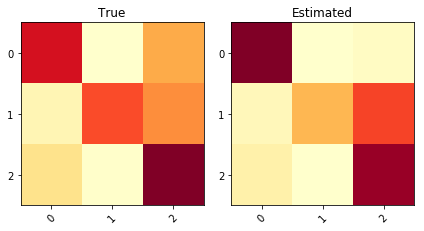

JS divergence: 0.0815	KL divergence: 0.3350


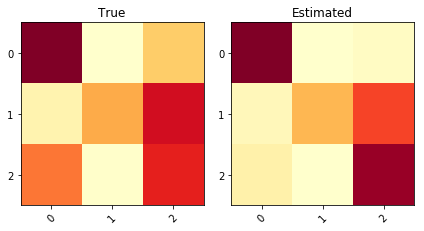

JS divergence: 0.0663	KL divergence: 0.2543


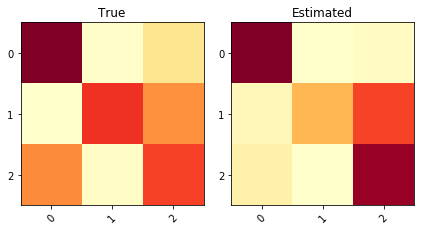

JS divergence: 0.0962	KL divergence: 0.6278
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.736264      0.736264   0.402163  0.0894108    0.402483   0.0892522
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.735043      0.735043
====  ======  ==========  ============


In [25]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


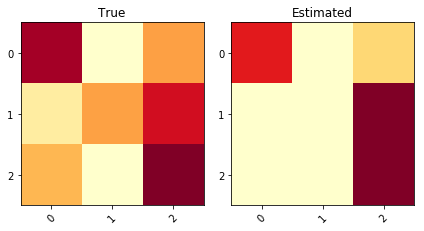

JS divergence: 0.1311	KL divergence: 3.1260


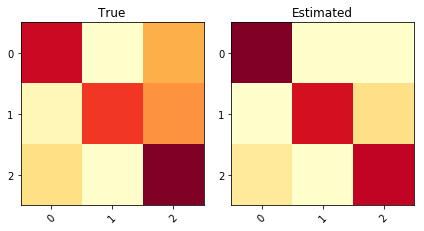

JS divergence: 0.0961	KL divergence: 2.0378


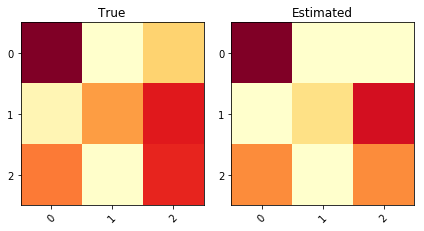

JS divergence: 0.0696	KL divergence: 1.4868


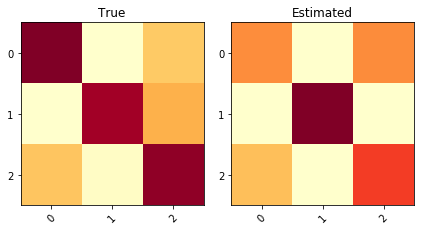

JS divergence: 0.0997	KL divergence: 2.0555


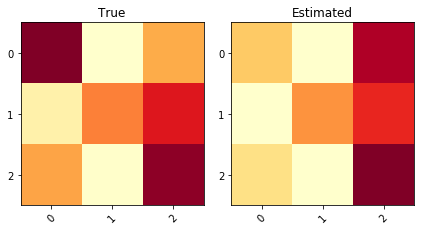

JS divergence: 0.0778	KL divergence: 0.6026


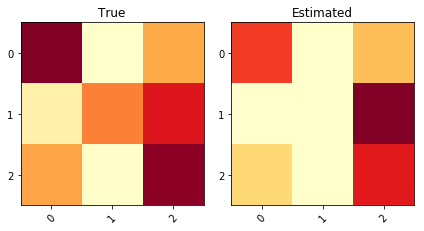

JS divergence: 0.0984	KL divergence: 2.2491


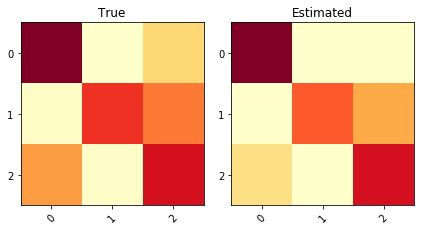

JS divergence: 0.0730	KL divergence: 1.5821


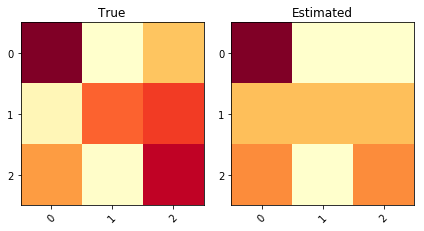

JS divergence: 0.0894	KL divergence: 0.8727


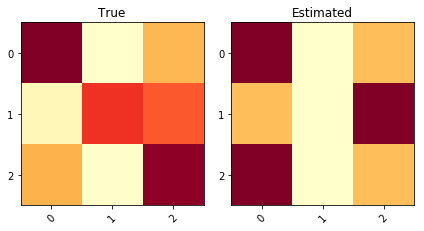

JS divergence: 0.1694	KL divergence: 2.8416


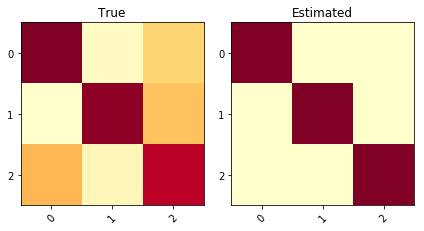

JS divergence: 0.1731	KL divergence: 3.3506


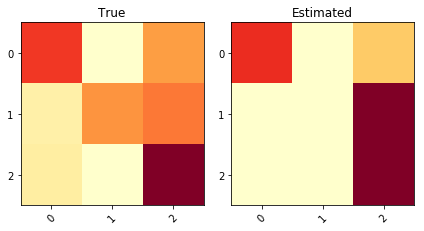

JS divergence: 0.1286	KL divergence: 2.9174


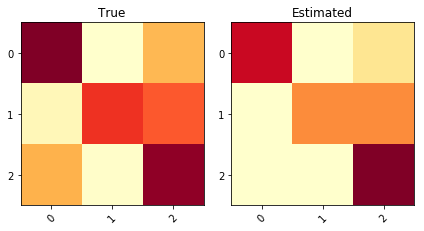

JS divergence: 0.0796	KL divergence: 1.8360


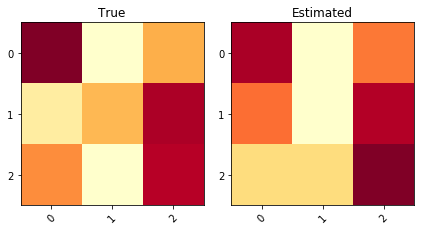

JS divergence: 0.1051	KL divergence: 1.3130


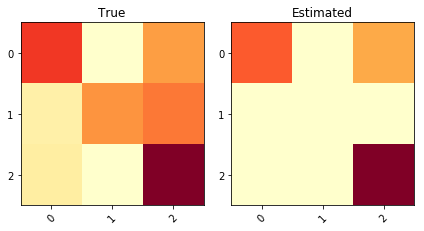

JS divergence: 0.0728	KL divergence: 0.5085


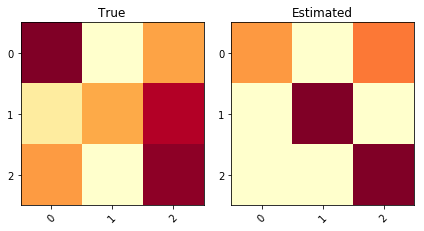

JS divergence: 0.2458	KL divergence: 5.1028
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.920635      0.920635    2.41456   0.137457     2.19636    0.126011
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.92674       0.92674
====  ======  ==========  ============


In [26]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


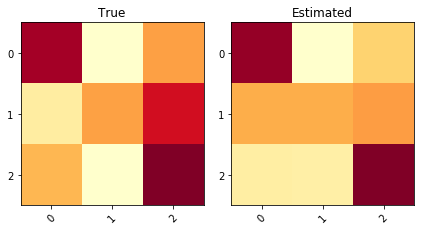

JS divergence: 0.0858	KL divergence: 0.1890


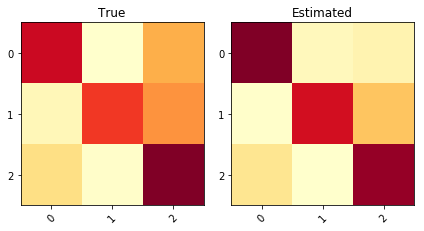

JS divergence: 0.0284	KL divergence: 0.0724


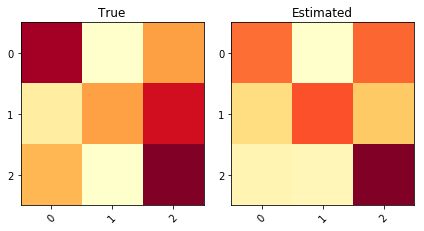

JS divergence: 0.0808	KL divergence: 0.1942


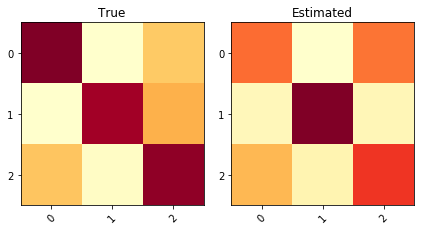

JS divergence: 0.0450	KL divergence: 0.1180


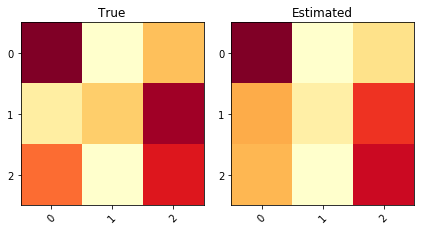

JS divergence: 0.0590	KL divergence: 0.1307


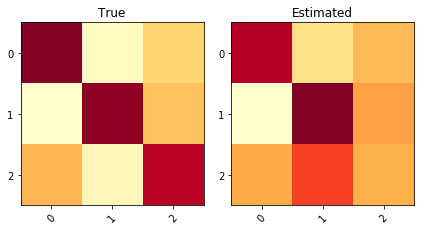

JS divergence: 0.0704	KL divergence: 0.1809


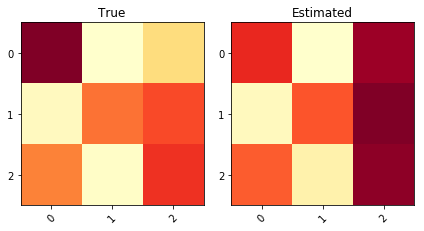

JS divergence: 0.0485	KL divergence: 0.1279


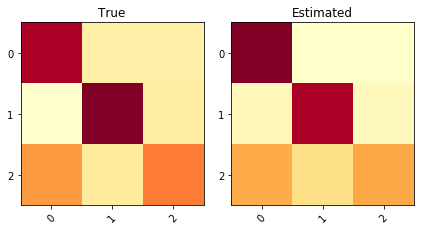

JS divergence: 0.0451	KL divergence: 0.1014


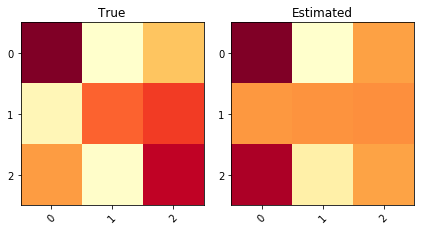

JS divergence: 0.0673	KL divergence: 0.1723


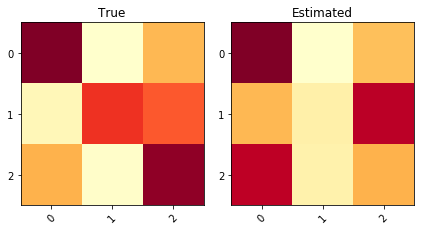

JS divergence: 0.0886	KL divergence: 0.2561


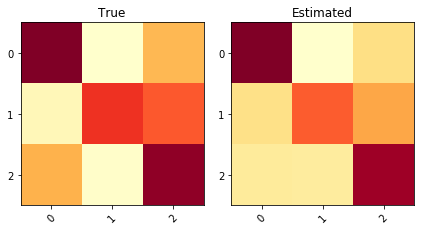

JS divergence: 0.0359	KL divergence: 0.0858


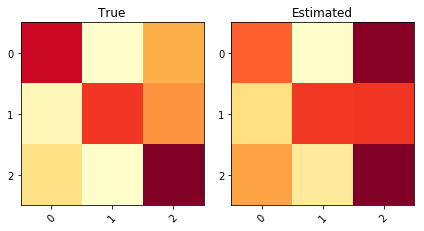

JS divergence: 0.0569	KL divergence: 0.1476


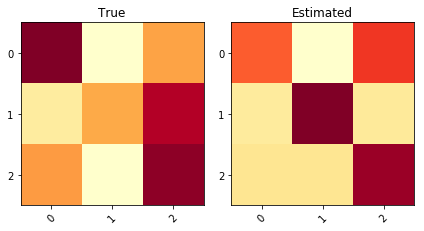

JS divergence: 0.1219	KL divergence: 0.3085


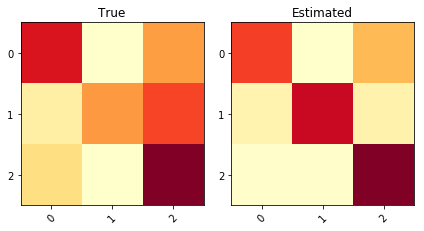

JS divergence: 0.0761	KL divergence: 0.1958


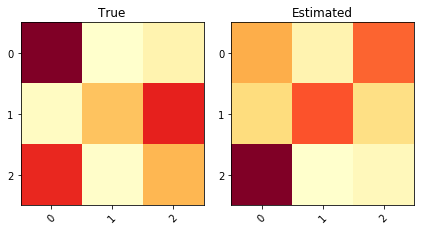

JS divergence: 0.1291	KL divergence: 0.3543
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global     0.84534       0.84534   0.190983  0.0764432    0.181949   0.0727143     0.150384      0.148878
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.677985              0.856763               

In [27]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


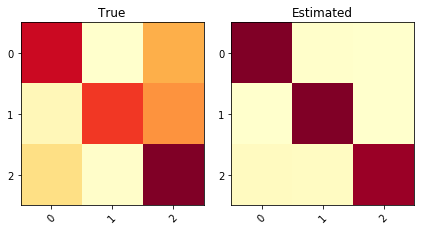

JS divergence: 0.1554	KL divergence: 0.9645


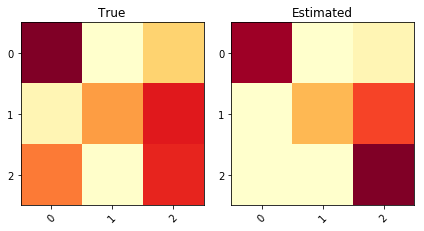

JS divergence: 0.0876	KL divergence: 0.4325


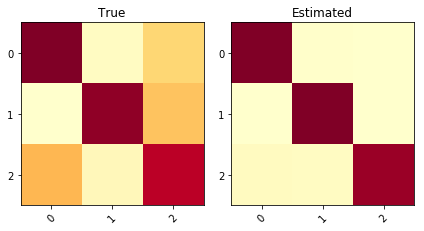

JS divergence: 0.1236	KL divergence: 0.6820


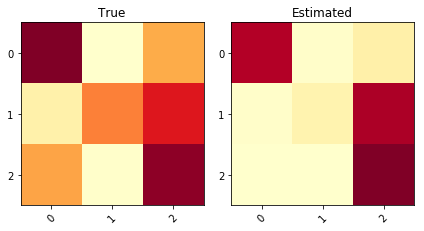

JS divergence: 0.1050	KL divergence: 0.5030


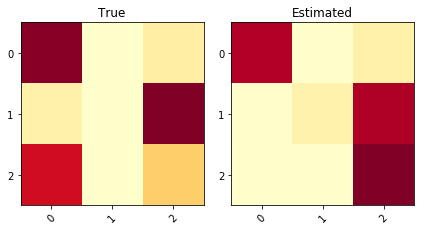

JS divergence: 0.1969	KL divergence: 1.1453


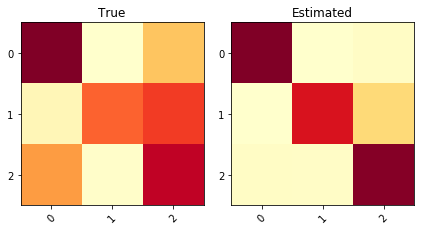

JS divergence: 0.1017	KL divergence: 0.4082


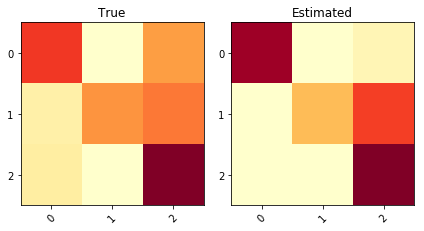

JS divergence: 0.0626	KL divergence: 0.2279


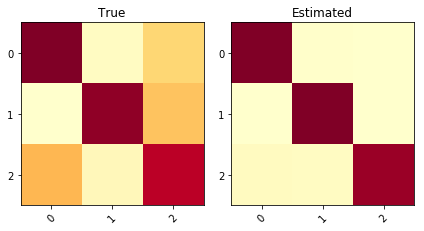

JS divergence: 0.1237	KL divergence: 0.6831


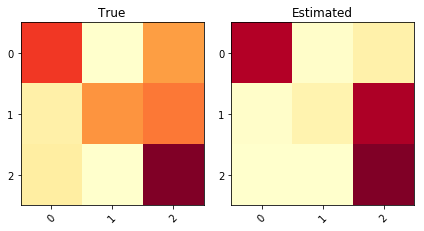

JS divergence: 0.0961	KL divergence: 0.3501


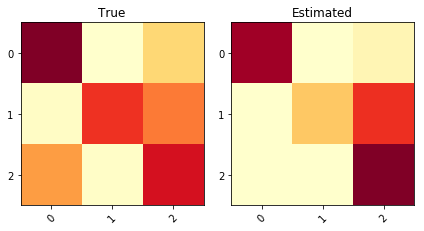

JS divergence: 0.0912	KL divergence: 0.4078


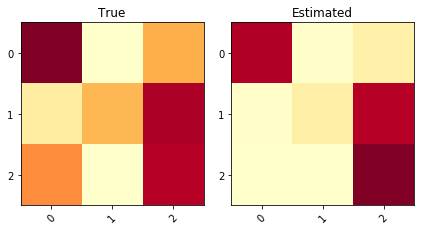

JS divergence: 0.0964	KL divergence: 0.5003


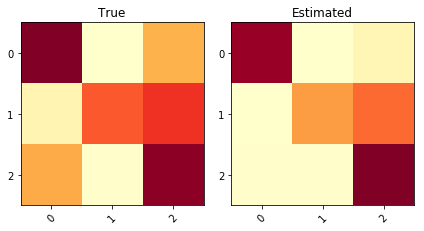

JS divergence: 0.0673	KL divergence: 0.2941


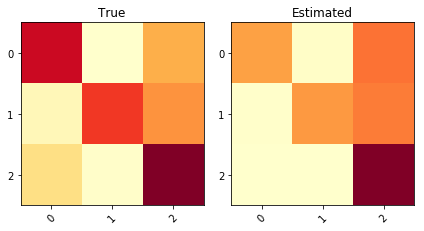

JS divergence: 0.0518	KL divergence: 0.2289


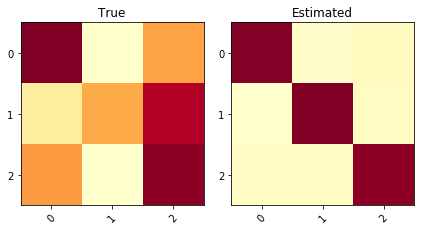

JS divergence: 0.2138	KL divergence: 0.9011


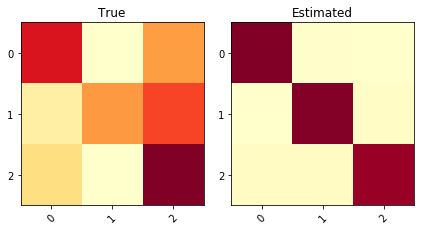

JS divergence: 0.1977	KL divergence: 0.9999
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.894587      0.894587   0.585882   0.124883    0.591474    0.125279     0.185192      0.183877
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.666401              0.757745               

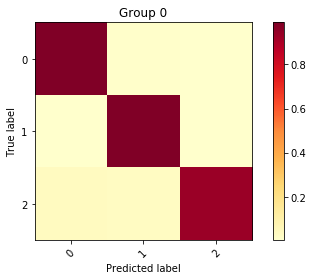

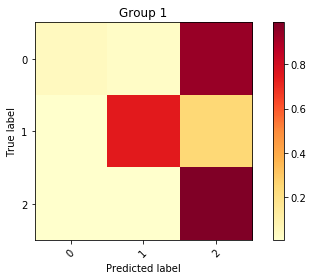

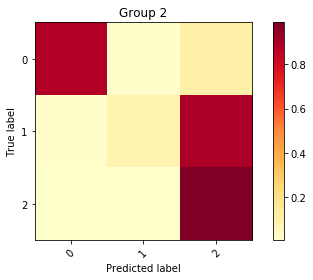

Inertia: 0.30906477997767395
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.508974    1017   0.141239     0.970559  0.0302601       0.978342   0.955838    0.89011       0.89011
   1         1  0.236059     472   0.316448     0.590981  1.1731          0.507368   0.386471    0.382173      0.382173
   2         2  0.254966     509   0.28075      0.653221  0.860866        0.592014   0.479831    0.638584      0.638584
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [30]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
### uno de prueba.. scenario v1 con soft y bad mv??

In [20]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6109076109076109


*** Soft-Majority (Train with softMV) ***
Train


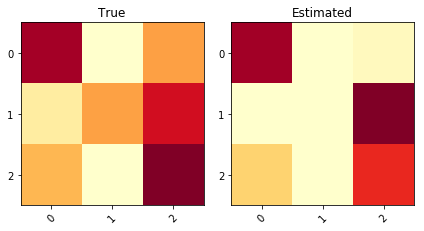

JS divergence: 0.1054	KL divergence: 1.9549


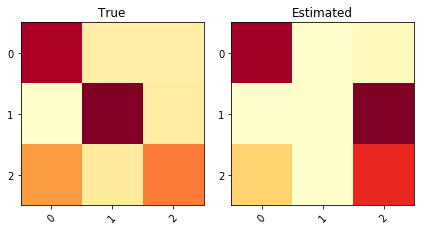

JS divergence: 0.3405	KL divergence: 5.7888


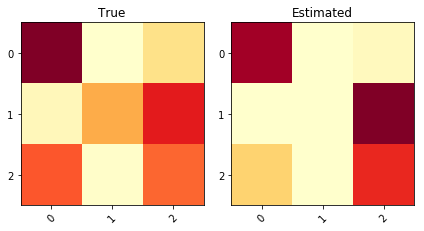

JS divergence: 0.1189	KL divergence: 2.1352


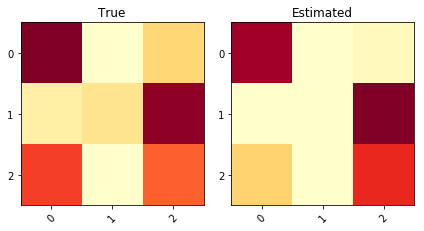

JS divergence: 0.0687	KL divergence: 1.0649


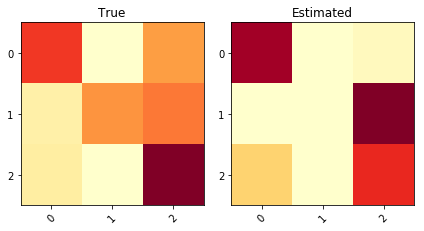

JS divergence: 0.1628	KL divergence: 2.5835


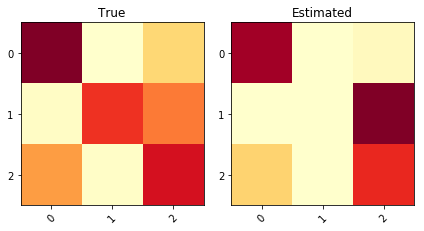

JS divergence: 0.1688	KL divergence: 3.2651


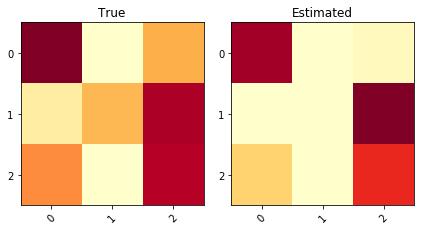

JS divergence: 0.0852	KL divergence: 1.6131


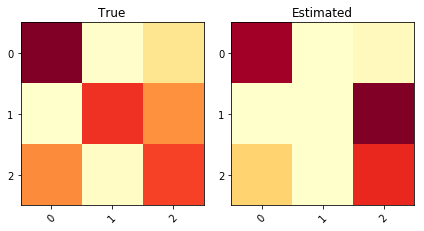

JS divergence: 0.1826	KL divergence: 3.4727


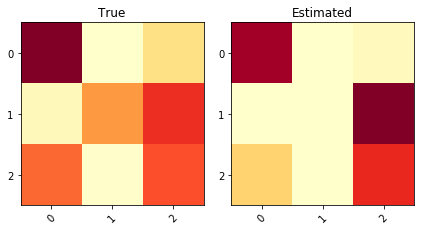

JS divergence: 0.1286	KL divergence: 2.3959


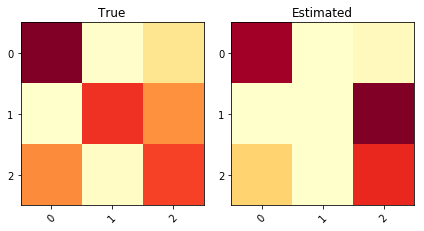

JS divergence: 0.1826	KL divergence: 3.4727


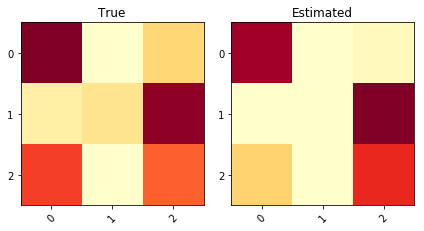

JS divergence: 0.0687	KL divergence: 1.0649


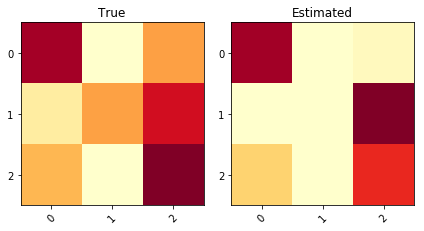

JS divergence: 0.1054	KL divergence: 1.9549


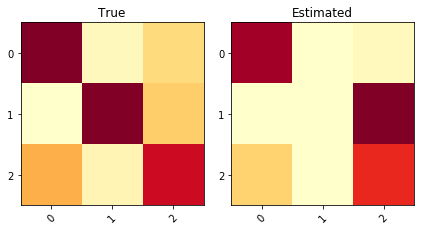

JS divergence: 0.2494	KL divergence: 4.6156


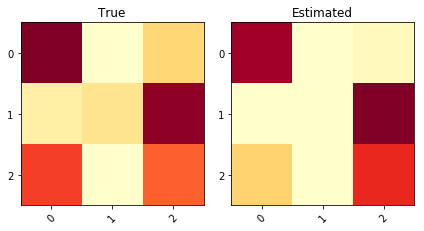

JS divergence: 0.0687	KL divergence: 1.0649


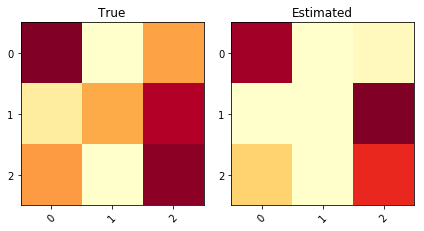

JS divergence: 0.0932	KL divergence: 1.7620
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.557184      0.557184    2.39987   0.139728     2.40462    0.139913
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.581197      0.581197
====  ======  ==========  ============


In [21]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


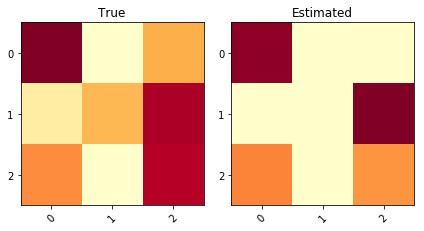

JS divergence: 0.1103	KL divergence: 1.3651


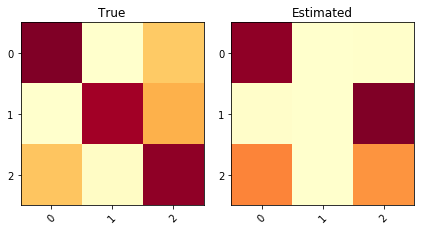

JS divergence: 0.2373	KL divergence: 4.0552


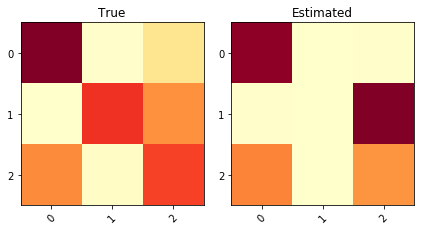

JS divergence: 0.2127	KL divergence: 3.4657


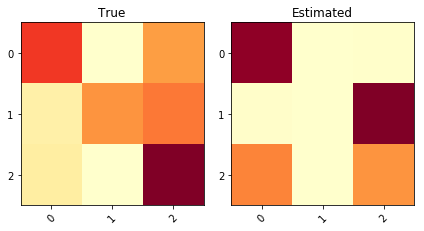

JS divergence: 0.1737	KL divergence: 2.3243


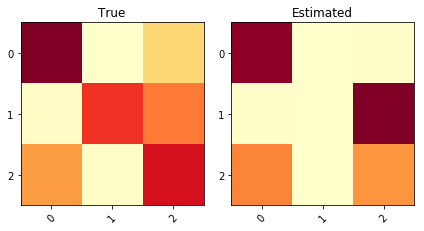

JS divergence: 0.1944	KL divergence: 3.2077


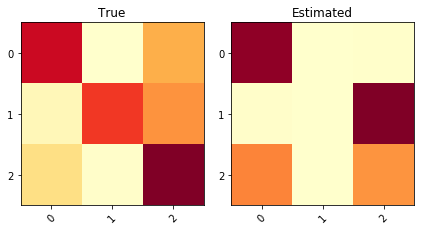

JS divergence: 0.1975	KL divergence: 3.1566


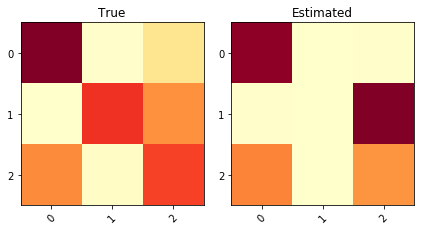

JS divergence: 0.2127	KL divergence: 3.4657


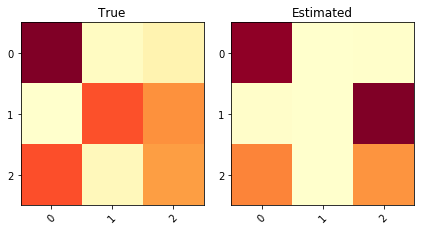

JS divergence: 0.2386	KL divergence: 3.5285


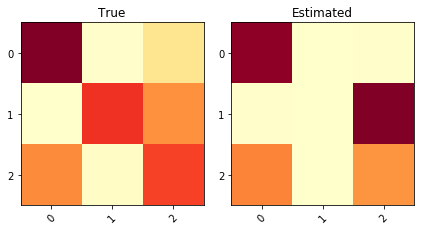

JS divergence: 0.2127	KL divergence: 3.4657


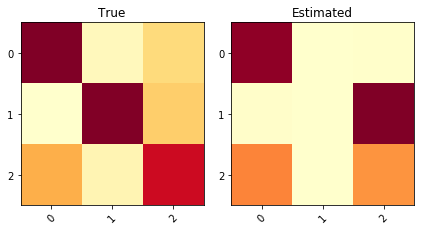

JS divergence: 0.2735	KL divergence: 4.6832


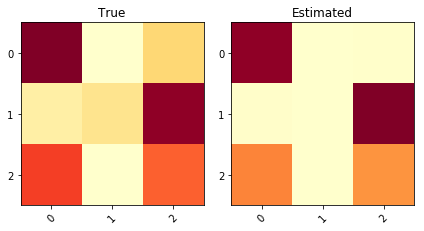

JS divergence: 0.1025	KL divergence: 0.8244


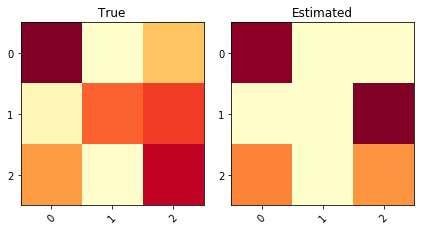

JS divergence: 0.1624	KL divergence: 2.5519


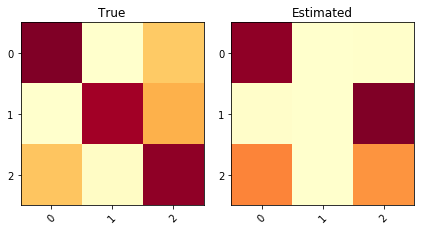

JS divergence: 0.2373	KL divergence: 4.0552


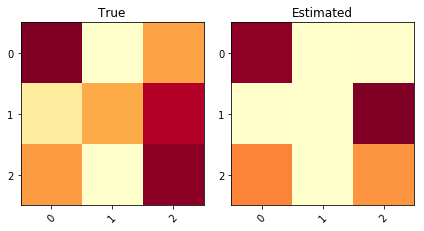

JS divergence: 0.1160	KL divergence: 1.5122


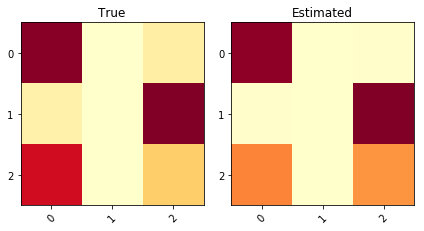

JS divergence: 0.1273	KL divergence: 0.2927
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.484737      0.484737    2.27314   0.169915     2.27798    0.170034
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.525031      0.525031
====  ======  ==========  ============


In [22]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


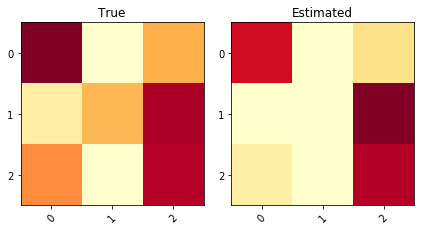

JS divergence: 0.0897	KL divergence: 1.6428


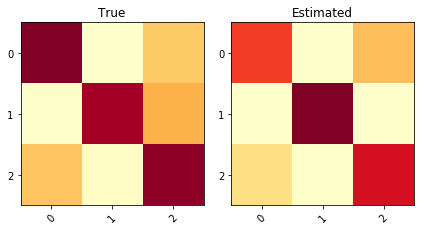

JS divergence: 0.0869	KL divergence: 2.0222


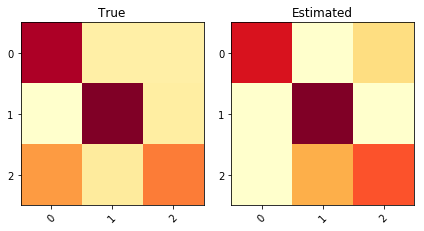

JS divergence: 0.1268	KL divergence: 2.8291


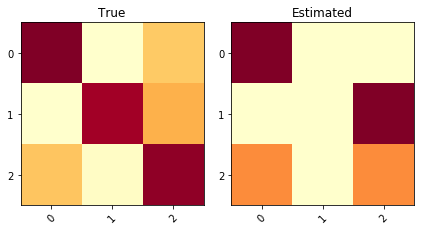

JS divergence: 0.2443	KL divergence: 5.1354


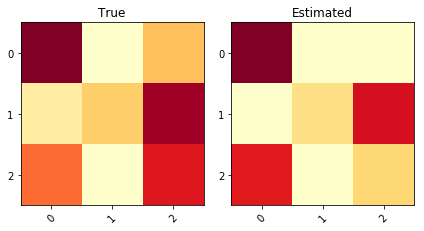

JS divergence: 0.0885	KL divergence: 1.6084


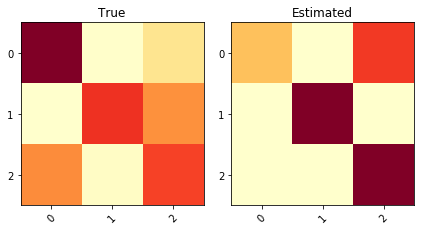

JS divergence: 0.2566	KL divergence: 4.7336


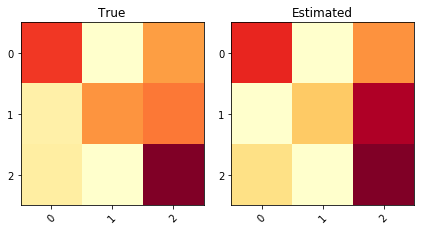

JS divergence: 0.0296	KL divergence: 0.4269


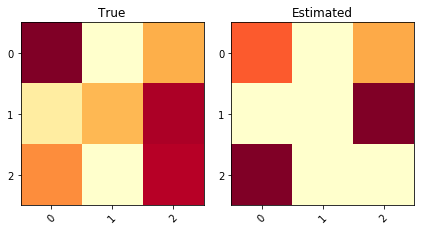

JS divergence: 0.2144	KL divergence: 4.7991


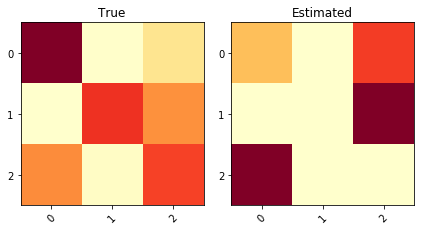

JS divergence: 0.3247	KL divergence: 4.4887


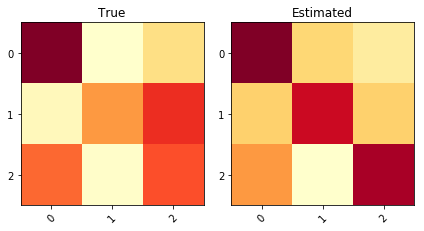

JS divergence: 0.0673	KL divergence: 0.3077


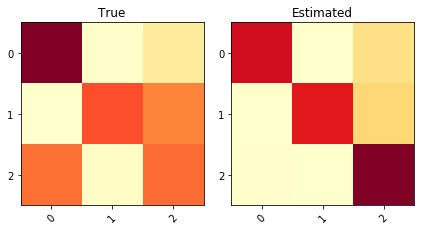

JS divergence: 0.1294	KL divergence: 1.1826


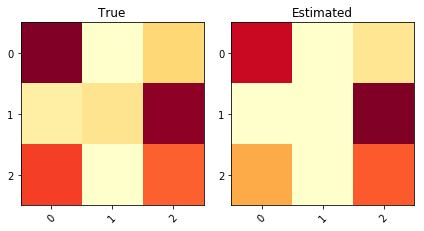

JS divergence: 0.0463	KL divergence: 1.0133


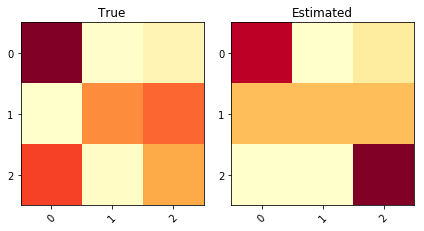

JS divergence: 0.1875	KL divergence: 3.3933


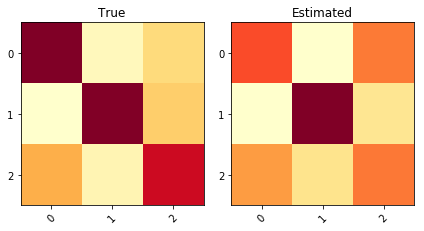

JS divergence: 0.0429	KL divergence: 0.4516


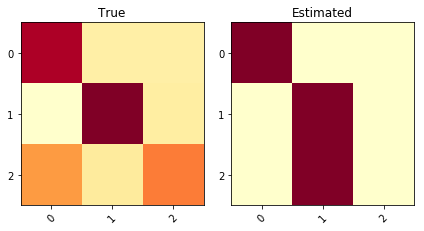

JS divergence: 0.2934	KL divergence: 5.6664
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.724054      0.724054    2.68355   0.154734     2.46757    0.142987
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.735043      0.735043
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


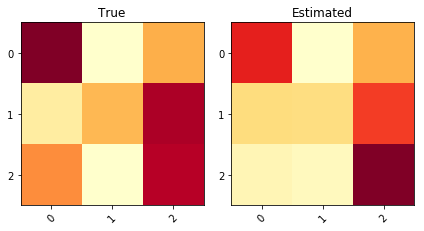

JS divergence: 0.0601	KL divergence: 0.1469


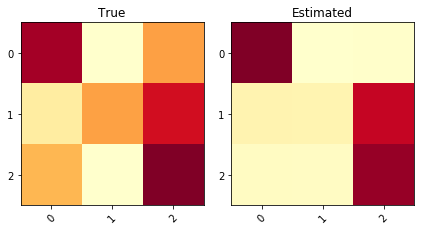

JS divergence: 0.0676	KL divergence: 0.1679


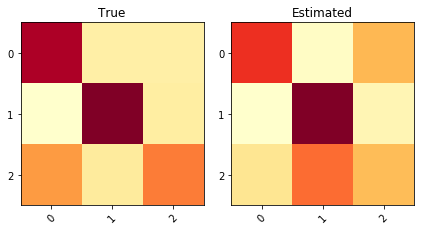

JS divergence: 0.0787	KL divergence: 0.1912


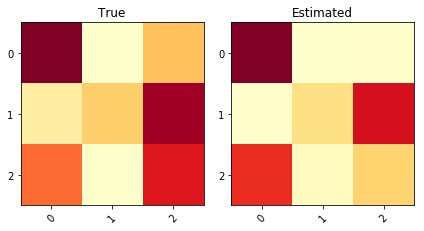

JS divergence: 0.0652	KL divergence: 0.1521


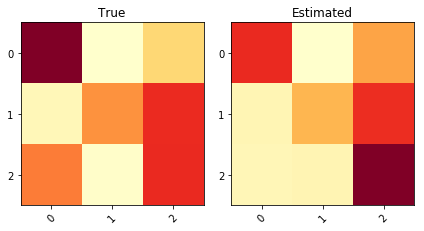

JS divergence: 0.0543	KL divergence: 0.1454


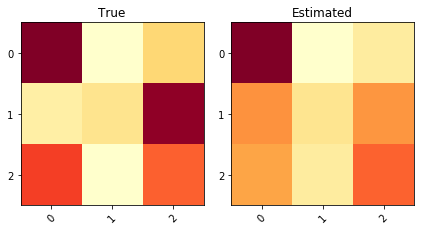

JS divergence: 0.0876	KL divergence: 0.2047


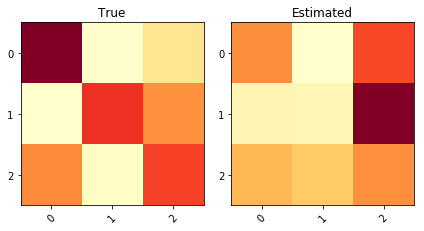

JS divergence: 0.1068	KL divergence: 0.3056


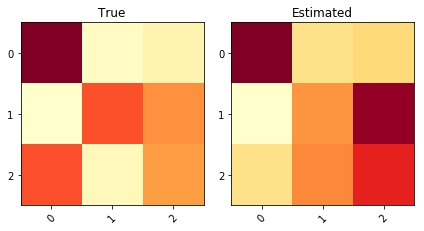

JS divergence: 0.0825	KL divergence: 0.2183


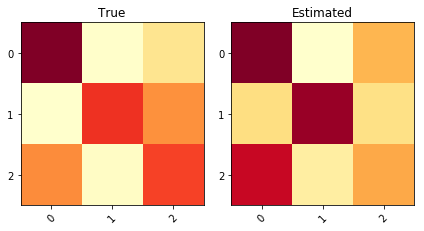

JS divergence: 0.0438	KL divergence: 0.1168


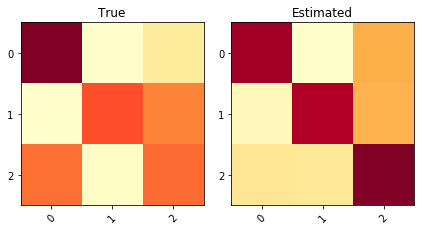

JS divergence: 0.0485	KL divergence: 0.1330


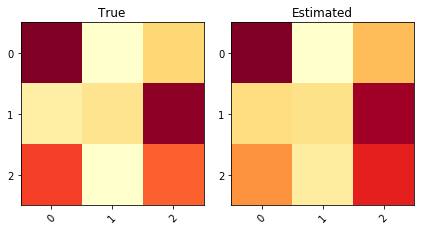

JS divergence: 0.0607	KL divergence: 0.1348


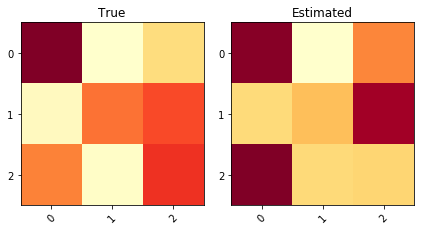

JS divergence: 0.0671	KL divergence: 0.1790


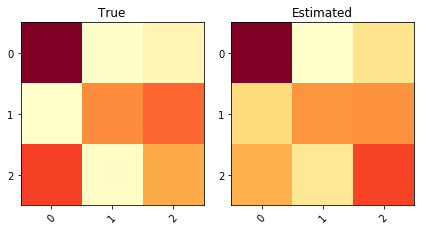

JS divergence: 0.0450	KL divergence: 0.1142


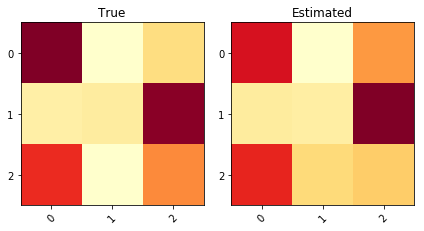

JS divergence: 0.0798	KL divergence: 0.1789


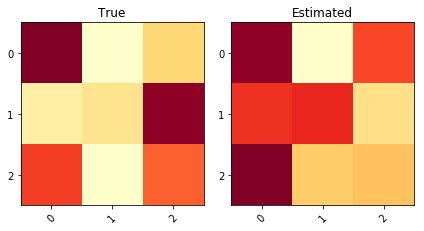

JS divergence: 0.1674	KL divergence: 0.4383
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.654864      0.654864   0.221326  0.0883099    0.213691   0.0851454     0.142425      0.141221
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.681957              0.832462               

In [24]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


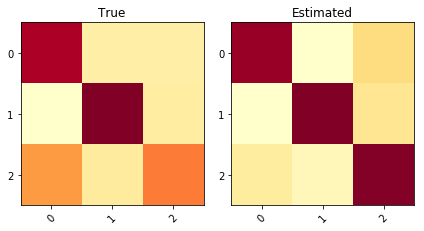

JS divergence: 0.0520	KL divergence: 0.1729


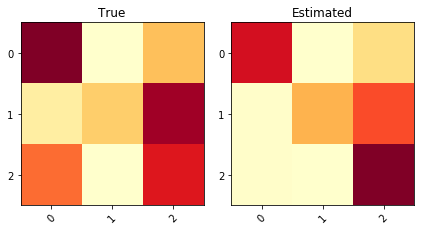

JS divergence: 0.0852	KL divergence: 0.4145


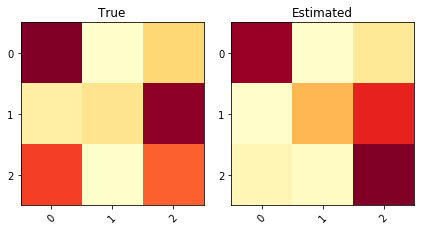

JS divergence: 0.0882	KL divergence: 0.3082


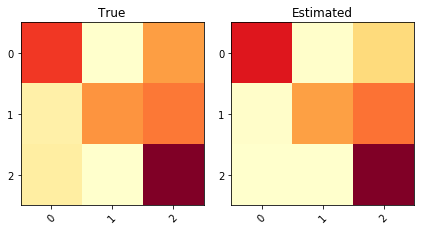

JS divergence: 0.0309	KL divergence: 0.1295


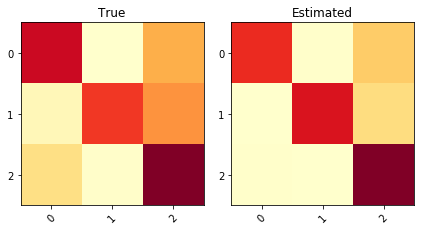

JS divergence: 0.0468	KL divergence: 0.2078


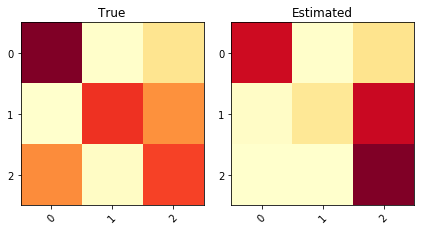

JS divergence: 0.1391	KL divergence: 0.6998


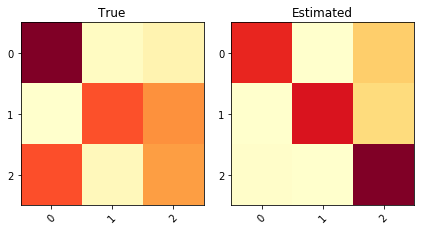

JS divergence: 0.1475	KL divergence: 0.6831


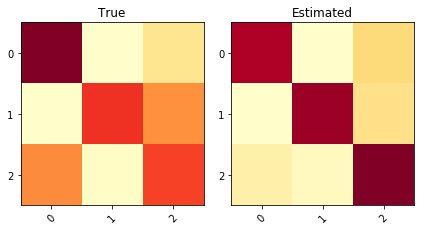

JS divergence: 0.0600	KL divergence: 0.2003


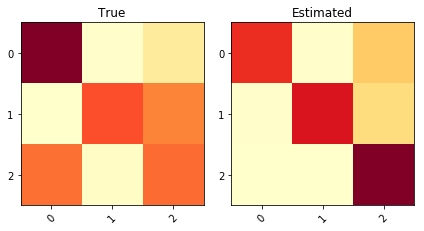

JS divergence: 0.1293	KL divergence: 0.7024


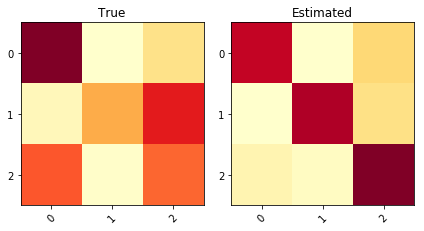

JS divergence: 0.1175	KL divergence: 0.3983


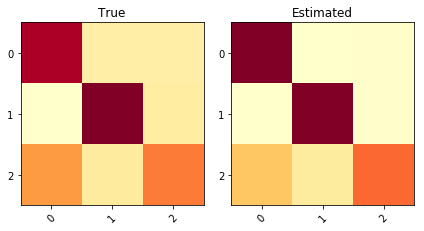

JS divergence: 0.0287	KL divergence: 0.1029


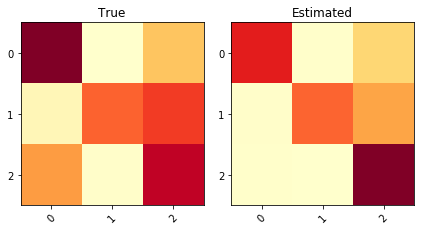

JS divergence: 0.0714	KL divergence: 0.3953


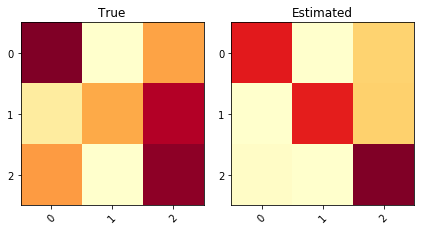

JS divergence: 0.0951	KL divergence: 0.3510


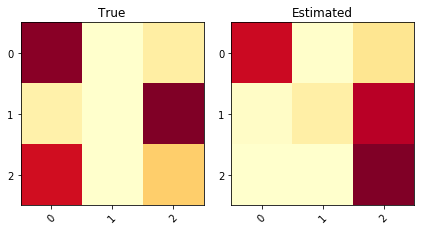

JS divergence: 0.1988	KL divergence: 1.1358


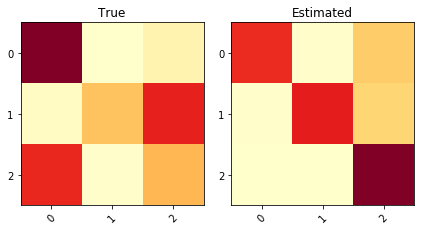

JS divergence: 0.2084	KL divergence: 1.1028
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.665853      0.665853   0.489938    0.10487    0.496108    0.105102     0.146281      0.142974
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.660091              0.720126               

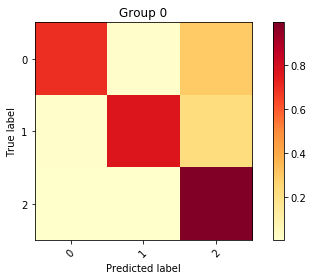

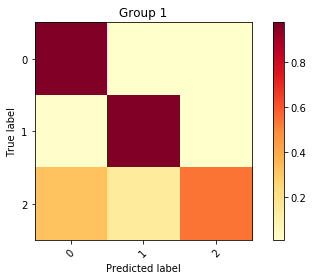

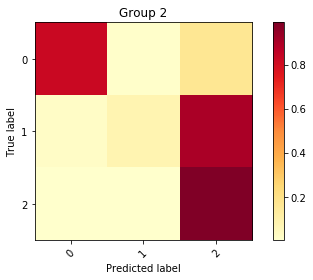

Inertia: 0.21635406908774243
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.454366     908   0.423096     0.819694   0.210133       0.855279   0.729541    0.68254       0.68254
   1         1  0.205741     411   0.418712     0.829184   0.222893       0.852557   0.743776    0.652015      0.652015
   2         2  0.339892     679   0.307908     0.631172   0.924381       0.567824   0.446758    0.620269      0.620269
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [25]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
### scenario v2 con bad mv (para perjudicar aun mas raykar y ds)

## Variation $M$ = #Groups
---

In [ ]:
from code.evaluation import Evaluation_metrics
import pickle

logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(1,15+1):
    for _ in range(5):
        gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",16,1,BatchN=False,drop=0.2)
        gMixture_Global.lambda_random = True #with lambda random --necessary
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)

        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Wmean KL"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
        results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)

        del gMixture_Global
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 15
R = 5
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.002951 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.60327834]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -24029.352	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23112.272	Tol1: 0.03816	Tol2: 0.22453	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22618.367	Tol1: 0.02137	Tol2: 0.10824	Tol3: 0.00000	
Iter 4/50
M step:

In [30]:
gMixture3.get_confusionM()[0][0,0] - np.mean(gMixture3.get_confusionM()[0][1:,0])

0.7690195

In [32]:
gMixture3.get_confusionM()[0][1,1] - np.mean(gMixture3.get_confusionM()[0][[0,2],1])

-0.23092328

In [31]:
gMixture3.get_confusionM()[0][2,2] - np.mean(gMixture3.get_confusionM()[0][[0,1],2])

-0.101780534

In [29]:
#save it
aux = [logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence1_Mchange,divergence2_Mchange,probGt_Mchange,inertia_Mchange]

# Store data (serialize)
with open('exp_Mchange_mvclose_t8.pickle', 'wb') as handle:
    pickle.dump(aux, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
# Load data (deserialize)
import pickle
with open('exp_Mchange_mean.pickle', 'rb') as handle:
    aux = pickle.load(handle)
logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence1_Mchange,divergence2_Mchange,probGt_Mchange,inertia_Mchange = aux

In [30]:
import math
def plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
        divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange):
    def add_plot(aux):
        aux.xticks(M_values)
        aux.xlabel("M change")
        aux.legend()
        #aux.show()
    
    #first some plots
    M_values = range(1,1+len(logL_Mchange))
    
    aux = math.ceil(len(M_values)/3)
    f,axx = plt.subplots(3,aux,figsize=(15,7))
    for m in range(len(M_values)):
        axx[int(m/aux),m%aux].bar(range(len(probas_Mchange[m])),probas_Mchange[m])
        axx[int(m/aux),m%aux].set_title("#%d groups"%(m+1))
    f.tight_layout()
    plt.show()

    try:
        plt.figure(figsize=(15,5))
        for m in range(len(M_values)):
            plt.plot(range(len(logL_Mchange[m])),logL_Mchange[m],'o-',label="Log-like training #"+str(m+1))
        plt.legend()
        plt.show()
        plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,plot_logL,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()
    except:
        plt.clf() #clf()
        #plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,logL_Mchange,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,divergence1_Mchange,label="Divergence to real T matrixs")
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(M_values,divergence2_Mchange,label="Divergence JS to real T matrixs")
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,accTR_Mchange,label="Acc training")
    plt.plot(M_values,accTE_Mchange,label="Acc test")
    plt.plot(M_values,best_group_acc_Mchange,label="Acc test best group")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0,1)
    plt.show()

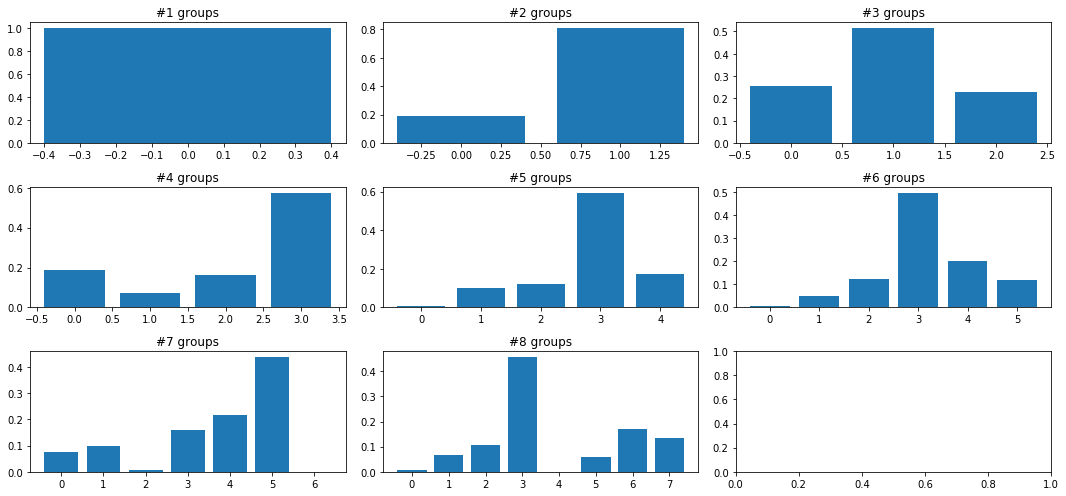

<Figure size 1080x360 with 0 Axes>

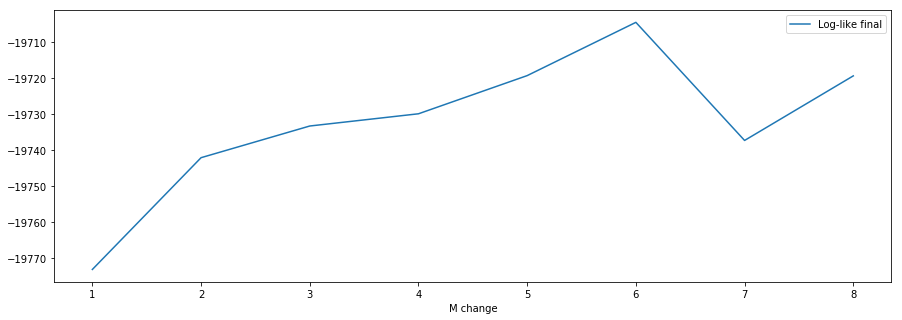

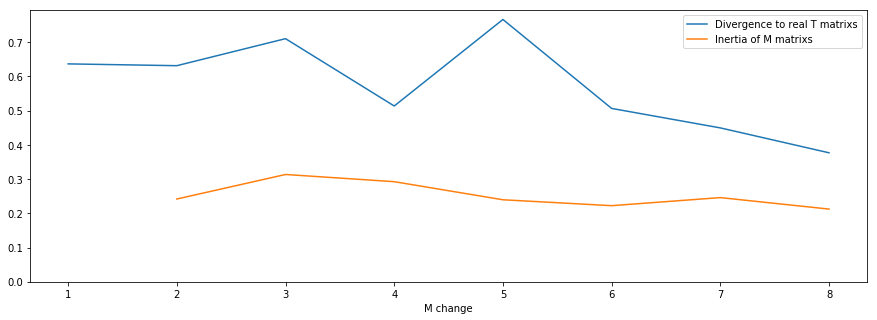

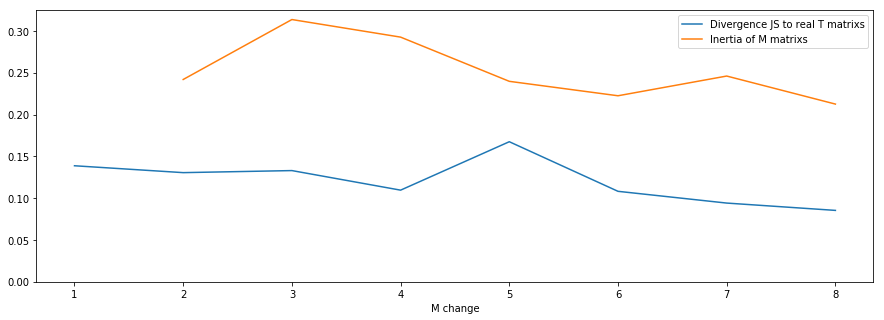

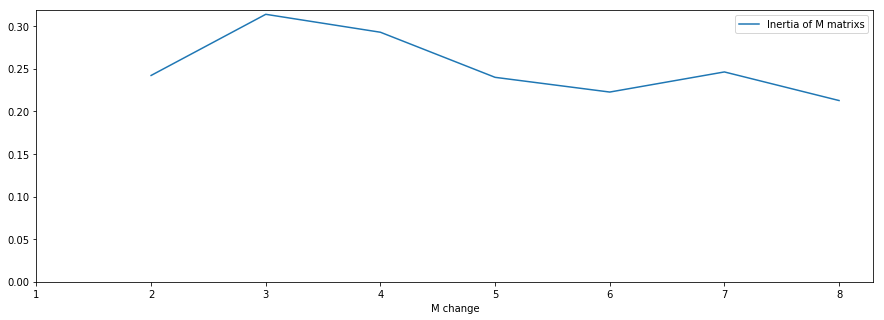

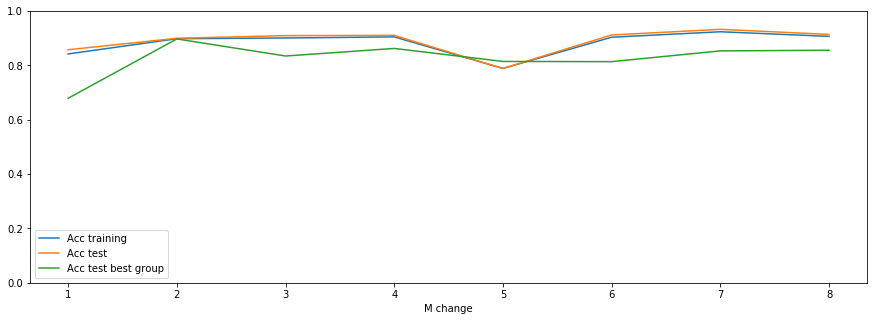

In [31]:
#version mv_Close
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

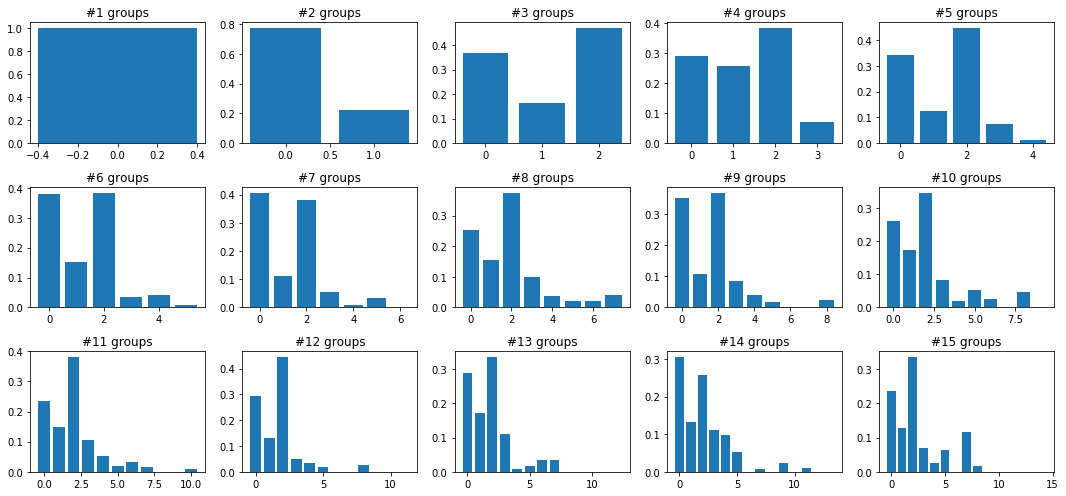

<Figure size 1080x360 with 0 Axes>

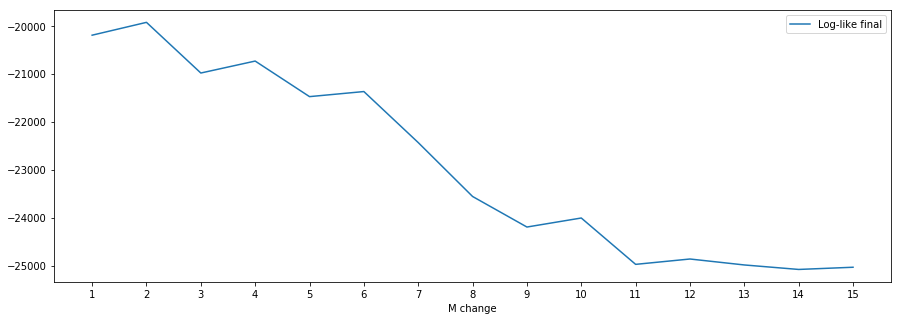

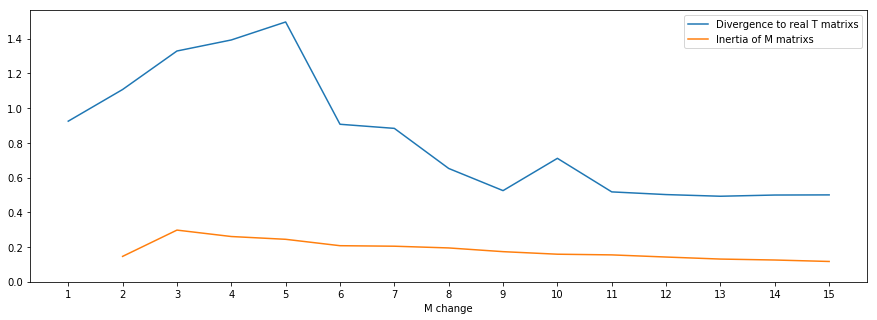

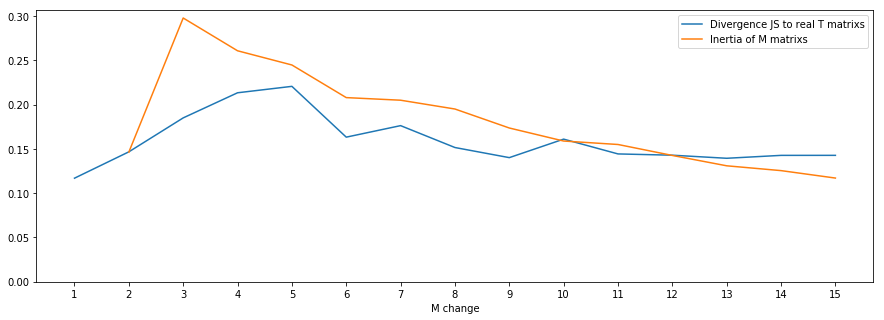

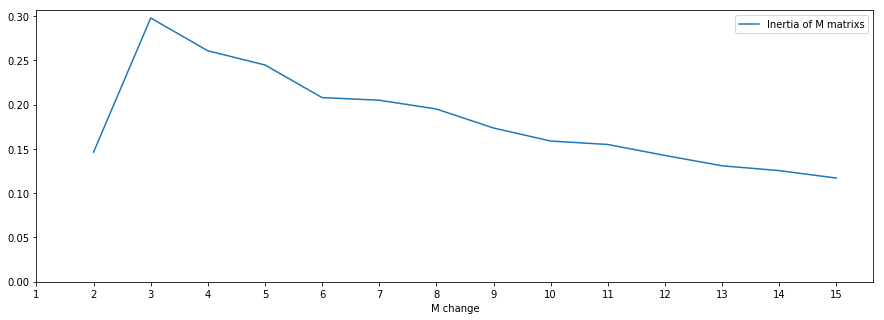

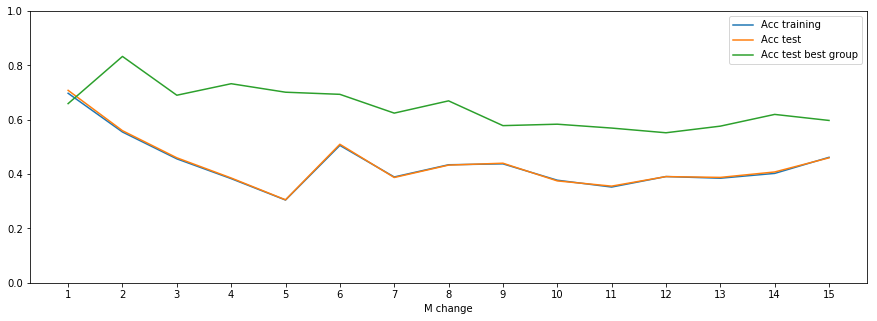

In [23]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

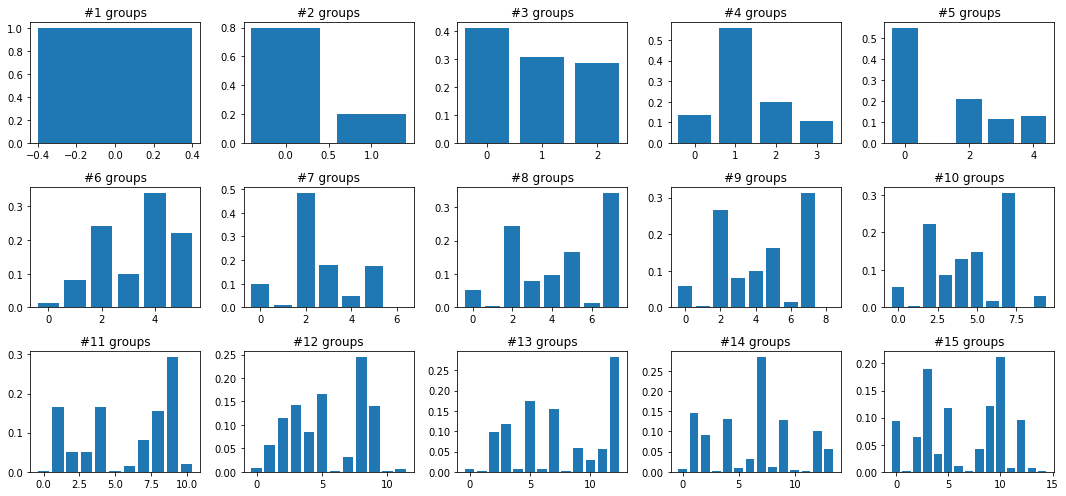

<Figure size 1080x360 with 0 Axes>

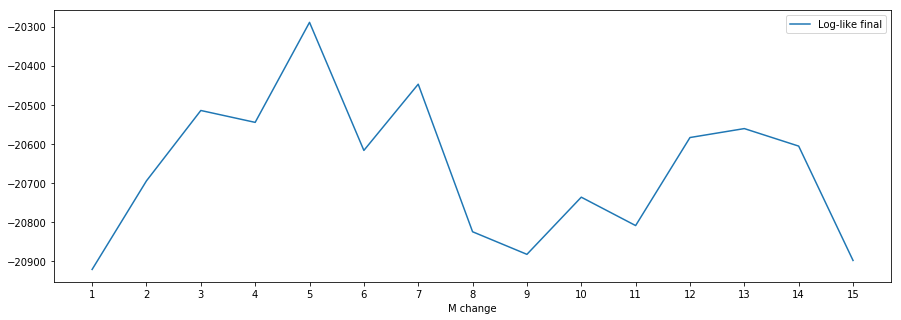

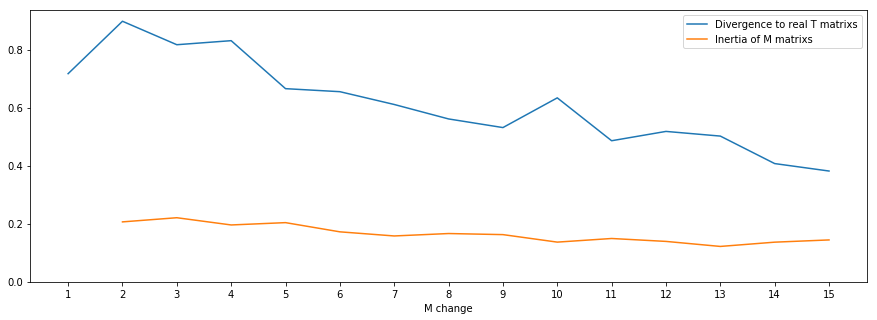

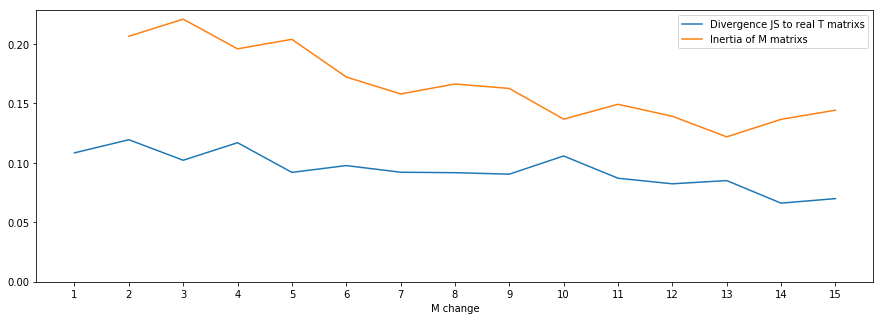

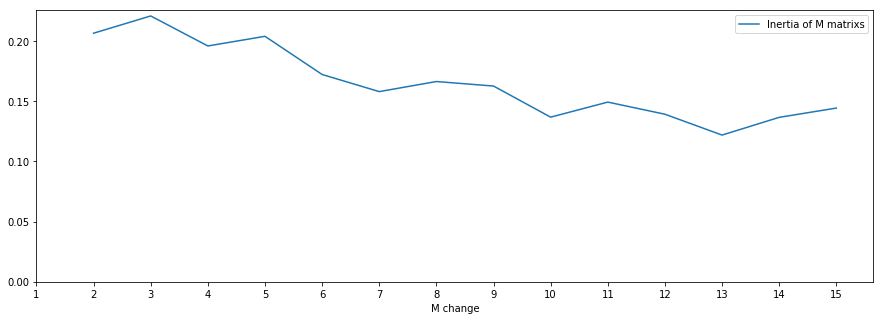

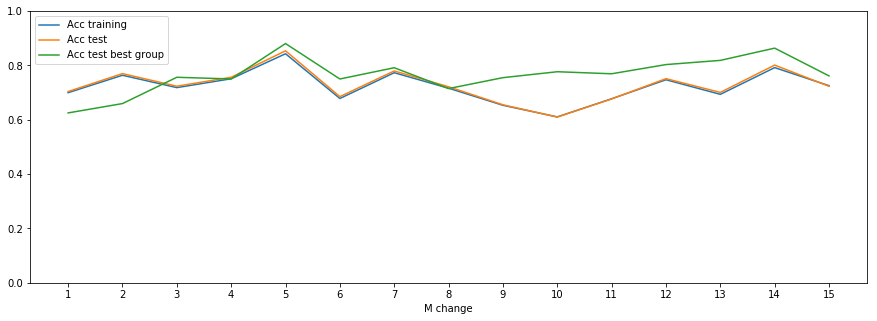

In [14]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

In [4]:
#T if i know T
M_values = range(1,1+len(logL_Mchange))
print(T)
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

100


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0         1              1              1                   1   
1         2              2              2                   2   
2         3              3              3                   3   
3         4              4              4                   4   
4         5              5              4                   5   
5         6              5              5                   6   
6         7              5              5                   4   
7         8              8              8                   5   
8         9              7              6                   3   
9        10              8              7                   3   
10       11              8              6                   1   
11       12              7              6                   3   
12       13              7              6                   4   
13       14              7              7                   1   
14       15              8              7                   1   

    Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                 1                                1  
1                                 2                                2  
2                                 3                                3  
3                                 4                                4  
4                                 5                                5  
5                                 6                                6  
6                                 7                                7  
7                                 8                                8  
8                                 9                                9  
9                                10                               10  
10                               11                                9  
11                               11                               10  
12                               13                               13  
13                               13                               11  
14                               15                               13